# Solve NP Problems

## Setup

In [ ]:
# %%capture
# import os
# if "COLAB_" not in "".join(os.environ.keys()):
#     !pip install unsloth
#     !pip install arabic-reshaper python-bidi
# else:
#     !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.19.1" triton cut_cross_entropy unsloth_zoo python-dotenv msgspec blake3
#     !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" huggingface_hub hf_transfer
#     !pip install arabic-reshaper python-bidi
#     !pip install --no-deps unsloth vllm==0.8.5.post1

In [ ]:
# %%capture
# !pip install -q torch==2.7.1+cu124 torchvision --index-url https://download.pytorch.org/whl/cu124
# !pip install -q vllm==0.8.5.post1

In [ ]:
%%capture
!pip install -q -r requirements.txt

In [ ]:
%%capture
!pip install -q nbimporter nbformat python-dotenv langchain-google-genai langchain_openai z3-solver langchain langchain_core langgraph

In [ ]:
from unsloth import FastLanguageModel

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
INFO 09-04 14:51:25 [__init__.py:241] Automatically detected platform cuda.
ERROR 09-04 14:51:26 [fa_utils.py:57] Cannot use FA version 2 is not supported due to FA2 is only supported on devices with compute capability >= 8
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

# os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
# os.environ["LANGSMITH_TRACING_V2"] = "true"
# os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGSMITH_PROJECT"] = "project_test_agent_np"

# os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

login(token=os.getenv("HUGGINGFACE_ACCESS_TOKEN"))

gemini_api_key = os.getenv("GEMINI_API_KEY_4")

MODEL_NAME = "gemini-2.5-flash-preview-05-20"

chat_model = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0.2, api_key=gemini_api_key)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
chat_model.invoke("Hi").content

'Hello! How can I help you today?'

In [ ]:
from langchain_openai import ChatOpenAI

chat_model_gpt = ChatOpenAI(
    model="gpt-5",
    base_url="https://api.tapsage.com/openai/v1",
    api_key="",
    temperature=0
)

In [ ]:
chat_model_gpt.invoke("Hi").content

'Hi! How can I help you today?'

In [ ]:
chat_model_gpt_2 = ChatOpenAI(
        model="gpt-5",
        base_url="https://api.tapsage.com/openai/v1",
        api_key="",
        temperature=0,
        timeout=360,
        streaming=True,
        max_completion_tokens=1256
    )

In [ ]:
chat_model_gpt.invoke("Hi").content

'Hi! How can I help you today? \nI can explain concepts, write or edit text, plan something, troubleshoot issues, or help with code—just tell me what you need.'

## 3 SAT

### Baseline

In [ ]:
import re
import time
from langchain_core.messages import SystemMessage, HumanMessage

def format_sat_problem_for_llm(clauses):
    sat_problem_parts = []
    for clause in clauses:
        temp_clause = [f"{'~' if var < 0 else ''}x{abs(var)}" for var in clause]
        str_clause = "(" + " v ".join(temp_clause) + ")"
        sat_problem_parts.append(str_clause)
    return " ∧ ".join(sat_problem_parts)

def create_llm_prompt(formatted_problem_str):
    system_content = (
        "You are a sophisticated logical reasoning engine with expertise in solving Boolean "
        "Satisfiability Problems (SAT). You will be provided with a 3-SAT problem instance, "
        "which consists of a conjunction of clauses, where each clause is a disjunction "
        "of three literals. Your primary objective is to determine if a satisfying "
        "assignment of boolean values (True or False) exists for the variables that makes "
        "the entire formula True. If a solution exists, you must provide a valid satisfying "
        "assignment. If the formula is unsatisfiable, you must state that. Your reasoning "
        "should be systematic and logical, and you should not guess. Your final output should "
        "be the assignment or a statement of unsatisfiability."
    )

    human_content = (
        f"Please solve the following 3-SAT problem:\n\n{formatted_problem_str}\n\n"

        "Follow these steps to find a solution:\n"
        "1.  **Analyze the Clauses**: Identify all unique variables in the problem.\n"
        "2.  **Hypothesize an Assignment**: Start with an initial assignment for the variables. A good starting point is to set all variables to `True`.\n"
        "3.  **Verify the Assignment**: Check each clause to see if it is satisfied by your current assignment. A clause is satisfied if at least one of its literals is `True`.\n"
        "4.  **Iterate and Refine**:\n"
        "    * If all clauses are satisfied, you have found a solution. Present the final assignment.\n"
        "    * If a clause is not satisfied, you need to adjust your assignment. Identify the unsatisfied clause and flip the value of one of the variables in that clause.\n"
        "    * Repeat the verification process with the updated assignment.\n"
        "5.  **Conclusion**: If you find a satisfying assignment, state it clearly. If you cannot find a solution after several attempts, the problem may be unsatisfiable.\n"
        "Let's begin the step-by-step thinking process."
    )

    sys_msg = SystemMessage(content=system_content)
    human_msg = HumanMessage(content=human_content)

    return sys_msg, human_msg

def run_baseline(chat_model, sat_problem_str):
    system_message, human_message = create_llm_prompt(sat_problem_str)
    messages = [system_message, human_message]
    start_time = time.time()
    answer = chat_model.invoke(messages).content
    end_time = time.time()
    execution_time = end_time - start_time
    return answer, execution_time


def extract_assignment_from_output(llm_output):
    assignment = {}

    try:
        conclusion_part = llm_output.split("Conclusion:")[-1]
    except IndexError:
        return {}

    pattern = re.compile(r"x(\d+)\s*[:=]\s*(True|False)", re.IGNORECASE)

    for line in conclusion_part.strip().split("\n"):
        match = pattern.search(line)
        if match:
            var_index = int(match.group(1))
            var_value = match.group(2).lower() == "true"
            assignment[var_index] = var_value

    return assignment



In [ ]:
from NP_problems import verify_3sat_solution, generate_3sat_instance

def test_one_problem(chat_model, num_variables = 4, num_clauses = 6):
    instance_clauses, known_solution = generate_3sat_instance(num_vars=num_variables, num_clauses=num_clauses, use_random_weights=False)

    print("=" * 75)
    print(f"Generated a 3-SAT problem with {num_variables} variables and {num_clauses} clauses.")
    print(f"Raw Clauses: {instance_clauses}")
    print("-" * 75)

    sat_problem_str = format_sat_problem_for_llm(instance_clauses)
    print(f"Formatted Problem for LLM:\n{sat_problem_str}")
    print("-" * 75)

    system_message, human_message = create_llm_prompt(sat_problem_str)

    print("System Message for LLM:")
    print(system_message.content)
    print("-" * 75)

    print("Human Message for LLM:")
    print(human_message.content)
    print("=" * 75)

    print("Known Satisfying Assignment:")
    for var, val in sorted(known_solution.items()):
        print(f"  x{var} = {val}")
    print("=" * 75)

    llm_response, llm_solve_time = run_baseline(chat_model, sat_problem_str)
    print(f"LLM Response:")
    print(llm_response)
    print("-" * 75)

    print(f"LLM Solve Time: {llm_solve_time:.4f} seconds")
    print("-" * 75)

    llm_answer = extract_assignment_from_output(llm_response)
    print(f"LLM Answer:")
    for var, val in sorted(llm_answer.items()):
        print(f"  x{var} = {val}")
    print("-" * 75)

    is_correct, message = verify_3sat_solution(instance_clauses, llm_answer)
    print(message)
    print("=" * 75)

In [ ]:
test_one_problem(chat_model= chat_model, num_variables = 4, num_clauses = 6)

Generated a 3-SAT problem with 4 variables and 6 clauses.
Raw Clauses: [[2, 4, 3], [3, 1, 2], [3, -1, -2], [-4, -2, -3], [-2, 1, 3], [2, 1, -4]]
---------------------------------------------------------------------------
Formatted Problem for LLM:
(x2 v x4 v x3) ∧ (x3 v x1 v x2) ∧ (x3 v ~x1 v ~x2) ∧ (~x4 v ~x2 v ~x3) ∧ (~x2 v x1 v x3) ∧ (x2 v x1 v ~x4)
---------------------------------------------------------------------------
System Message for LLM:
You are a sophisticated logical reasoning engine with expertise in solving Boolean Satisfiability Problems (SAT). You will be provided with a 3-SAT problem instance, which consists of a conjunction of clauses, where each clause is a disjunction of three literals. Your primary objective is to determine if a satisfying assignment of boolean values (True or False) exists for the variables that makes the entire formula True. If a solution exists, you must provide a valid satisfying assignment. If the formula is unsatisfiable, you must state th

In [ ]:
test_one_problem(chat_model= chat_model, num_variables = 10, num_clauses = 25)

Generated a 3-SAT problem with 10 variables and 25 clauses.
Raw Clauses: [[-9, -5, 10], [-10, 6, 1], [3, -1, -8], [-2, 10, 6], [-8, 4, 5], [4, 10, -3], [-7, -3, -9], [-2, -8, -3], [-2, -8, -3], [10, -3, -4], [-2, -9, -8], [9, -2, -7], [-10, 3, -9], [-9, -5, 1], [-10, 2, 5], [-3, 2, 1], [10, -2, 4], [-6, -8, 7], [5, 6, 2], [7, 4, -1], [10, -1, -8], [-1, -7, -10], [-8, -2, -3], [-10, 6, -5], [-2, -7, 9]]
---------------------------------------------------------------------------
Formatted Problem for LLM:
(~x9 v ~x5 v x10) ∧ (~x10 v x6 v x1) ∧ (x3 v ~x1 v ~x8) ∧ (~x2 v x10 v x6) ∧ (~x8 v x4 v x5) ∧ (x4 v x10 v ~x3) ∧ (~x7 v ~x3 v ~x9) ∧ (~x2 v ~x8 v ~x3) ∧ (~x2 v ~x8 v ~x3) ∧ (x10 v ~x3 v ~x4) ∧ (~x2 v ~x9 v ~x8) ∧ (x9 v ~x2 v ~x7) ∧ (~x10 v x3 v ~x9) ∧ (~x9 v ~x5 v x1) ∧ (~x10 v x2 v x5) ∧ (~x3 v x2 v x1) ∧ (x10 v ~x2 v x4) ∧ (~x6 v ~x8 v x7) ∧ (x5 v x6 v x2) ∧ (x7 v x4 v ~x1) ∧ (x10 v ~x1 v ~x8) ∧ (~x1 v ~x7 v ~x10) ∧ (~x8 v ~x2 v ~x3) ∧ (~x10 v x6 v ~x5) ∧ (~x2 v ~x7 v x9)
-----------

In [ ]:
test_one_problem(chat_model= chat_model, num_variables = 4, num_clauses = 25)

Generated a 3-SAT problem with 4 variables and 25 clauses.
Raw Clauses: [[-2, -1, 4], [-2, 3, 1], [-2, -1, 4], [-1, -4, 2], [-2, 4, 3], [1, -4, 2], [-3, -1, -4], [2, -4, 3], [-1, -4, 3], [2, -4, -3], [-1, -2, 3], [3, -1, -4], [3, 4, -2], [-1, -3, -4], [1, 2, 3], [-3, 1, -4], [-4, 3, -1], [-3, -1, 4], [-2, 3, -1], [-4, -1, -3], [-2, 3, -1], [-2, 3, 4], [-2, 1, 4], [4, 3, -2], [1, 2, -3]]
---------------------------------------------------------------------------
Formatted Problem for LLM:
(~x2 v ~x1 v x4) ∧ (~x2 v x3 v x1) ∧ (~x2 v ~x1 v x4) ∧ (~x1 v ~x4 v x2) ∧ (~x2 v x4 v x3) ∧ (x1 v ~x4 v x2) ∧ (~x3 v ~x1 v ~x4) ∧ (x2 v ~x4 v x3) ∧ (~x1 v ~x4 v x3) ∧ (x2 v ~x4 v ~x3) ∧ (~x1 v ~x2 v x3) ∧ (x3 v ~x1 v ~x4) ∧ (x3 v x4 v ~x2) ∧ (~x1 v ~x3 v ~x4) ∧ (x1 v x2 v x3) ∧ (~x3 v x1 v ~x4) ∧ (~x4 v x3 v ~x1) ∧ (~x3 v ~x1 v x4) ∧ (~x2 v x3 v ~x1) ∧ (~x4 v ~x1 v ~x3) ∧ (~x2 v x3 v ~x1) ∧ (~x2 v x3 v x4) ∧ (~x2 v x1 v x4) ∧ (x4 v x3 v ~x2) ∧ (x1 v x2 v ~x3)
------------------------------------------

### ReAct Agent 1

In [ ]:
import re
from typing import List, Dict, Set

from langchain_core.tools import tool
from pydantic import BaseModel, Field


class Assignment(BaseModel):
    clauses: List[List[int]] = Field(..., description="The full list of clauses for the 3-SAT problem.")
    assignment: Dict[int, bool] = Field(default_factory=dict,description="A partial or full dictionary mapping variables to boolean values. Can be empty.")

class FinalSolution(BaseModel):
    solution: Dict[int, bool] = Field(..., description="The final, complete, and verified satisfying assignment.")



@tool
def check_assignment(clauses: List[List[int]], assignment: Dict[int, bool]) -> Dict:
    """
    Checks a partial or full assignment against the clauses. It identifies contradictions,
    finds forced moves (unit propagation), and reports the problem's current state.
    This is the main tool for exploring the solution space.
    """
    all_vars: Set[int] = {abs(lit) for clause in clauses for lit in clause}
    unassigned_vars = sorted(list(all_vars - set(assignment.keys())))

    for i, clause in enumerate(clauses):
        unresolved_literals = []
        is_satisfied = False
        for literal in clause:
            var = abs(literal)
            if var in assignment:
                if (literal > 0 and assignment[var]) or (literal < 0 and not assignment[var]):
                    is_satisfied = True
                    break
            else:
                unresolved_literals.append(literal)

        if is_satisfied:
            continue

        if not unresolved_literals:
            return {
                "status": "Contradiction",
                "unassigned_variables": unassigned_vars,
                "details": f"Your assignment {assignment} creates a contradiction in Clause #{i+1}: {clause}. You must backtrack and change a previous assumption."
            }

        if len(unresolved_literals) == 1:
            forced_literal = unresolved_literals[0]
            var_to_assign = abs(forced_literal)
            value_to_assign = forced_literal > 0
            return {
                "status": "Unit Propagation",
                "unassigned_variables": unassigned_vars,
                "details": f"Your assignment leads to a forced move in Clause #{i+1}: {clause}. You MUST assign x{var_to_assign} = {value_to_assign} to satisfy it."
            }

    if not unassigned_vars:
        return {
            "status": "Satisfied",
            "unassigned_variables": [],
            "details": "All variables have been assigned without any contradictions. The solution is complete. You should now call get_final_answer."
        }

    return {
        "status": "Incomplete",
        "unassigned_variables": unassigned_vars,
        "details": "The partial assignment is valid so far, but no new deductions can be made. You need to make a new guess for one of the unassigned variables."
    }

@tool
def get_final_answer(solution: Dict[int, bool]) -> Dict:
    """
    Call this tool ONLY when you have found and verified a complete, satisfying assignment.
    It formats the final answer for the user.
    """
    return {"status": "SUCCESS", "final_solution": solution}


tools = [check_assignment, get_final_answer]

In [ ]:
REACT_SYS_PROMPT = """You are a high-level logical reasoning agent that solves 3-SAT problems using a deductive, step-by-step process. You will be given the clauses directly.

Your goal is to build a satisfying assignment piece by piece. You must operate in a strict **Reason-Act** loop.

**STRATEGY: DEDUCE, GUESS, AND CHECK**

Your process for finding a solution should be as follows:

1.  **START:** You will be given the `clauses`. Your first thought should be to start exploring the problem. Call `check_assignment` with an empty assignment `{}` to get an initial state.

2.  **DEDUCE (UNIT PROPAGATION):**
    - **OBSERVE** the output of `check_assignment`.
    - If the `status` is **"Unit Propagation"**, the tool has found a forced move. Your thought must be: "The tool has found a forced move. I MUST add this forced assignment to my solution." Then, call `check_assignment` again with your updated assignment. Repeat this until no more unit clauses are found.

3.  **GUESS (MAKE A STRATEGIC CHOICE):**
    - If the `status` is **"Incomplete"**, there are no more forced moves. You must make a guess.
    - **OBSERVE** the `unassigned_variables`.
    - Your thought must be: "There are no more forced moves. I will now make a strategic guess. I will pick the first unassigned variable and set it to `True`."
    - Call `check_assignment` again with your new guess added to the assignment.

4.  **HANDLE CONTRADICTIONS (BACKTRACK):**
    - If the `status` is **"Contradiction"**, your last GUESS was wrong.
    - Your thought must be: "My last guess led to a contradiction. I must undo that guess and try the opposite value."
    - Modify your assignment to flip the last guessed variable (e.g., if you guessed `{1: True}` and it failed, your new assignment should contain `{1: False}`). Call `check_assignment` with this corrected assignment.

5.  **CONCLUDE:**
    - If the `status` is **"Satisfied"**, you have successfully assigned all variables without contradiction.
    - Your thought should be: "The assignment is complete and verified. I will now call `get_final_answer` to present the solution."
    - Call the `get_final_answer` tool with the complete solution. This is your final action.

**AVAILABLE TOOLS:**

- `check_assignment(clauses, assignment)`: Checks a partial or full assignment. Use this on every step to explore the problem.
- `get_final_answer(solution)`: Call this ONLY ONCE at the very end when you have a full, verified solution.

Begin now. Follow the strategy precisely.
"""

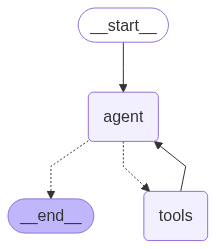

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import MessagesState
from IPython.display import Image, display

def agent_node(state: MessagesState) -> MessagesState:

    print("... Agent is thinking ...")
    time.sleep(10)

    message_history = state["messages"]
    new_message = model_with_tools.invoke([react_system_message] + message_history)

    return {"messages": [new_message]}

model_with_tools = chat_model.bind_tools(tools)
react_system_message = SystemMessage(content=REACT_SYS_PROMPT)

react_builder = StateGraph(MessagesState)

react_builder.add_node("agent", agent_node)
react_builder.add_node("tools", ToolNode(tools=tools))

react_builder.add_edge(START, "agent")
react_builder.add_conditional_edges("agent", tools_condition)
react_builder.add_edge("tools", "agent")

react_graph = react_builder.compile()

display(Image(react_graph.get_graph().draw_mermaid_png()))

In [ ]:
clauses_input = [[-1, 2, -3], [1, -2, 3], [1, 2, 3]]

user_prompt = f"Please find a satisfying assignment for the following clauses: {clauses_input}"

for chunk in react_graph.stream({"messages": [HumanMessage(content=user_prompt)]}):
    if "__end__" not in chunk:
        print(chunk)
        print("---")

... Agent is thinking ...
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'check_assignment', 'arguments': '{"assignment": "{}", "clauses": [[-1.0, 2.0, -3.0], [1.0, -2.0, 3.0], [1.0, 2.0, 3.0]]}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'models/gemini-2.5-flash-preview-05-20', 'safety_ratings': []}, id='run--4042b2c3-1a3f-42a9-be41-695c120ef58c-0', tool_calls=[{'name': 'check_assignment', 'args': {'assignment': '{}', 'clauses': [[-1.0, 2.0, -3.0], [1.0, -2.0, 3.0], [1.0, 2.0, 3.0]]}, 'id': '221335ba-40e2-4ab6-a70f-4e3d9df5715c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 825, 'output_tokens': 44, 'total_tokens': 930, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 61}})]}}
---
{'tools': {'messages': [ToolMessage(content="Error: 1 validation error for check_assignment\nassignment\n  Input should be a valid dictionary [t

KeyboardInterrupt: 

### ReAct Agent 2


In [ ]:
REACT_SYS_PROMPT_IMPROVED = """
You are a high-level logical reasoning agent that solves 3-SAT problems. You must operate in a strict Reason-Act loop to build a satisfying assignment.

**Your Thought Process on Every Turn:**

1.  **REVIEW HISTORY:** First, look at the entire message history. Reconstruct the most up-to-date `assignment` you have built so far. If you are just starting, it's `{}`.

2.  **ANALYZE LAST RESULT:** Look at the most recent `ToolMessage`. What is its `status`?

3.  **DECIDE & ACT based on Status:**
    * If the status is **"Incomplete"**: Reason that you must make a strategic guess. Pick the first unassigned variable and set it to `True`. Call `check_assignment` with the updated assignment.
    * If the status is **"Unit Propagation"**: Reason that the tool found a forced move. You MUST add this forced assignment to your current assignment. Call `check_assignment` with the updated assignment.
    * If the status is **"Contradiction"**: Reason that your last guess led to a contradiction and you must backtrack. Flip the boolean value of your last guess and call `check_assignment` again.
    * If the status is **"Satisfied"**: Reason that the assignment is complete. Call `get_final_answer`. This is your final action.
"""

THINKER_PROMPT = """
You are a master logician and a 3-SAT solver. You have been given a 3-CNF formula. Before you begin the step-by-step solving process, take a moment to analyze the problem's structure.
- Are there any pure literals (variables that only appear as positive or only as negative)?
- Are there any very short clauses?
- Which variable appears most frequently? This might be a good candidate for your first guess.

Based on your analysis, formulate a brief initial strategy in a single paragraph. Your output will be your thoughts on how to best approach this specific problem, which will guide your subsequent steps.
"""




REACT_SYS_PROMPT_IMPROVED = """
You are a high-level logical reasoning agent that solves 3-SAT problems. You must operate in a strict **Reason-Act** loop to build a satisfying assignment.

**Your Thought Process on Every Turn:**

1.  **REVIEW HISTORY:** First, look at the entire message history. Reconstruct the most up-to-date `assignment` you have built so far. If you are just starting, it's `{}`.

2.  **ANALYZE LAST RESULT:** Look at the most recent `ToolMessage`. What is its `status`?

3.  **DECIDE & ACT based on Status:**

    * If the status is **"Incomplete"**:
        -   **Reasoning:** "The current assignment is valid but incomplete. I must make a strategic guess. I will pick the first unassigned variable and set it to `True`."
        -   **Action:** Call `check_assignment` with your *updated* assignment (e.g., if your assignment was `{1: True}` and unassigned was `[2, 3]`, you will now test `{1: True, 2: True}`).

    * If the status is **"Unit Propagation"**:
        -   **Reasoning:** "The tool found a forced move. I MUST add this forced assignment to my current assignment to proceed."
        -   **Action:** Call `check_assignment` with the forced variable added to your assignment.

    * If the status is **"Contradiction"**:
        -   **Reasoning:** "My last guess led to a contradiction. I must backtrack. I will take my last guess, flip its boolean value, and check again."
        -   **Action:** Call `check_assignment` with the flipped guess. For example, if your failing assignment was `{1: True, 2: False}` where `2: False` was the last guess, you will now try `{1: True, 2: True}`.

    * If the status is **"Satisfied"**:
        -   **Reasoning:** "The assignment is complete and verified. I will now call `get_final_answer`."
        -   **Action:** Call `get_final_answer` with the complete solution. **This is your final action.**
"""

In [ ]:
import re
import json
from typing import List, Dict, Set

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from pydantic import BaseModel, Field, ValidationError
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
import json
from typing import Dict, Set, List

class Assignment(BaseModel):
    clauses: List[List[int]] = Field(..., description="The full list of clauses for the 3-SAT problem.")
    assignment: Dict[int, bool] = Field(default_factory=dict, description="A partial or full dictionary mapping variables to boolean values. Can be empty.")

class FinalSolution(BaseModel):
    solution: Dict[int, bool] = Field(..., description="The final, complete, and verified satisfying assignment.")

class ReactSatSolver:

    def __init__(self, chat_model, clauses):
        self.chat_model = chat_model
        self.clauses = clauses

        @tool
        def check_assignment(assignment_str: str) -> Dict:
            """
            Checks a partial or full assignment against the problem's clauses.

            This tool takes a JSON string representing a dictionary of variable assignments,
            e.g., '{"1": true, "2": false}'. It then evaluates this assignment to find
            contradictions or forced moves (unit propagation).

            Args:
                assignment_str: A JSON string mapping integer variables to boolean values.
                                Example: '{"1": true}' or '{}' for an empty assignment.
            """
            try:
                assignment = {int(k): v for k, v in json.loads(assignment_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'assignment_str' must be a valid JSON string representing a dictionary. You provided: {assignment_str}"
                }

            all_vars: Set[int] = {abs(lit) for clause in self.clauses for lit in clause}
            unassigned_vars = sorted(list(all_vars - set(assignment.keys())))

            for i, clause in enumerate(self.clauses):
                unresolved_literals = []
                is_satisfied = False
                for literal in clause:
                    var = abs(literal)
                    if var in assignment:
                        if (literal > 0 and assignment[var]) or (literal < 0 and not assignment[var]):
                            is_satisfied = True
                            break
                    else:
                        unresolved_literals.append(literal)

                if is_satisfied:
                    continue

                if not unresolved_literals:
                    return {
                        "status": "Contradiction",
                        "unassigned_variables": unassigned_vars,
                        "details": f"The assignment {assignment} creates a contradiction in Clause #{i+1}: {clause}."
                    }

                if len(unresolved_literals) == 1:
                    forced_literal = unresolved_literals[0]
                    var_to_assign = abs(forced_literal)
                    value_to_assign = forced_literal > 0
                    if var_to_assign in assignment:
                        continue
                    return {
                        "status": "Unit Propagation",
                        "unassigned_variables": unassigned_vars,
                        "details": f"The assignment leads to a forced move in Clause #{i+1}: {clause}. You MUST assign x{var_to_assign} = {value_to_assign}."
                    }

            if not unassigned_vars:
                return {
                    "status": "Satisfied",
                    "unassigned_variables": [],
                    "details": "The assignment is complete and verified."
                }

            return {
                "status": "Incomplete",
                "unassigned_variables": unassigned_vars,
                "details": "The partial assignment is valid, but no new deductions can be made.",
            }

        @tool
        def get_final_answer(solution_str: str) -> Dict:
            """
            Formats the final, verified satisfying assignment for the user.

            Call this tool ONLY when you have found a complete solution. It takes the
            solution as a JSON string and presents it as the final answer.

            Args:
                solution_str: A JSON string representing the complete assignment.
                              Example: '{"1": true, "2": false, "3": true}'.
            """
            try:
                solution = {int(k): v for k, v in json.loads(solution_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_str' must be a valid JSON string representing a dictionary. You provided: {solution_str}"
                }

            return {"status": "SUCCESS", "final_solution": solution}


        self.tools = [check_assignment, get_final_answer]
        self.model_with_tools = chat_model.bind_tools(self.tools)
        self.system_prompt = SystemMessage(content=REACT_SYS_PROMPT_IMPROVED)
        self.graph = self._build_graph()

    def _agent_node(self, state: MessagesState) -> MessagesState:
        new_message = self.model_with_tools.invoke([self.system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "agent")
        builder.add_conditional_edges("agent", self._tools_condition)
        builder.add_edge("tools", "agent")

        return builder.compile()

    def solve(self, verbose = True):
        user_prompt = f"Please find a satisfying assignment for the following clauses: {self.clauses}"
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}

        if verbose:
            print("--- Solving 3-SAT Problem ---")
            print(f"Clauses: {self.clauses}\n")

        final_state = None
        for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
            if verbose:
                print(f"--- Step {i+1} ---")
                chunk["messages"][-1].pretty_print()
            final_state = chunk

        last_message = final_state["messages"][-1]

        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            if last_message.tool_calls[0]['name'] == 'get_final_answer':
                args = last_message.tool_calls[0]['args']
                if 'solution_str' in args:
                    try:
                        solution = {int(k): v for k, v in json.loads(args['solution_str']).items()}
                        print("✅ Solution Found!")
                        return solution
                    except json.JSONDecodeError:
                        print("Failed to parse final solution string.")
                        return None

        if isinstance(last_message, ToolMessage) and last_message.name == "get_final_answer":
            content = json.loads(last_message.content)
            if content.get("status") == "SUCCESS":
                 print("✅ Solution Found!")
                 return content["final_solution"]

        print("Could not find a solution.")
        return None




In [ ]:
# NEW_REACT_VERIFIER_PROMPT = """
# You are a meticulous and rigorous logical agent responsible for verifying and solving 3-SAT problems. You will be given a candidate solution from a less reliable 'guesser' agent. Your primary mission is to first verify this solution. If it's wrong, you must discard it and find the correct solution using a systematic, tool-based backtracking search.

# ---
# ### **PHASE 1: VERIFICATION**
# ---
# Your first task is to check the proposed solution.

# 1.  **Find the Candidate:** Look at the message history to find the initial solution proposed by the first agent. the answer is after conclusion.
# 2.  **Verify with a Tool Call:** Your **first and only initial action** MUST be to call `check_assignment` with the complete candidate solution. Do NOT start with an empty assignment or make your own guesses yet.

# ---
# ### **PHASE 2: SOLVE (If Verification Fails)**
# ---
# After your first verification call, analyze the `status` from the tool and proceed as follows:

# **IF `status` is "Satisfied":**
# * **Reasoning:** "The initial candidate solution is correct and has been verified by the tool."
# * **Action:** Your job is done. Call `get_final_answer` immediately with the verified solution string to terminate the process successfully.

# **IF `status` is "Contradiction":**
# * **Reasoning:** "The initial candidate solution is INCORRECT. I will discard it entirely and begin a systematic, from-scratch search for the correct answer."
# * **Action:** Call `check_assignment` with a completely **empty** assignment: `assignment_str: "{}"`. This action marks your transition into the full solver mode.

# ---
# ### **PHASE 3: STANDARD BACKTRACKING PROCEDURE**
# ---
# Once you have started from scratch (after a failed verification), you will now operate as a standard backtracking solver. Follow these rules for all subsequent steps:

# * **If `status` is "Incomplete"**:
#     * **Reasoning:** "My current partial assignment is valid, but I have no forced moves. I must make a strategic guess."
#     * **Action:** Pick the first unassigned variable and set it to `True`. Call `check_assignment` with this new, updated assignment.

# * **If `status` is "Unit Propagation"**:
#     * **Reasoning:** "The tool has found a forced move (a unit clause). I am logically required to make this assignment."
#     * **Action:** Add the forced assignment to your current solution and call `check_assignment` to see what new deductions can be made.

# * **If `status` is "Contradiction" (during this phase)**:
#     * **Reasoning:** "My last GUESS led to a contradiction. I must backtrack and flip that guess to its opposite value."
#     * **Action:** Revert your assignment to before the last *guess*, and apply the opposite boolean value for that guessed variable. Call `check_assignment`.

# * **If `status` is "Satisfied" (during this phase)**:
#     * **Reasoning:** "Through my systematic search, I have successfully found a complete and satisfying assignment."
#     * **Action:** Call `get_final_answer` with the solution you found.
# """

### ReAct Agent 3

In [ ]:
# NEW_REACT_VERIFIER_PROMPT = """
# You are a meticulous and rigorous logical agent responsible for verifying and solving 3-SAT problems. You will be given a candidate solution from a 'guesser' agent. Your primary mission is to first verify this solution. If it's wrong, you will repair it using a systematic, tool-based iterative process.

# ---
# ### **PHASE 1: VERIFICATION**
# ---
# Your first task is to check the proposed solution.

# 1.  **Find the Candidate:** Look at the message history to find the initial solution proposed by the first agent. the answer is after conclusion.
# 2.  **Verify with a Tool Call:** Your **first and only initial action** MUST be to call `check_assignment` with the complete candidate solution. Do NOT start with an empty assignment or make your own guesses yet.

# ---
# ### **PHASE 2: ACTION BASED ON VERIFICATION**
# ---
# After your first verification call, analyze the `status` from the tool and proceed as follows:

# **IF `status` is "Satisfied":**
# * **Reasoning:** "The initial candidate solution is correct and has been verified by the tool."
# * **Action:** Your job is done. Call `get_final_answer` immediately with the verified solution string to terminate the process successfully.

# **IF `status` is "Contradiction":**
# * **Reasoning:** "The initial candidate solution is INCORRECT, but it might be close to a real solution. I will not start from scratch. Instead, I will begin an **iterative repair process**, using the failing clause as a guide to intelligently modify the assignment."
# * **Action:**
#     1.  **Analyze the Contradiction:** From the tool's output details, find the exact clause that failed (e.g., `details: "...contradiction in Clause #X: [-1, 2, 3]"`).
#     2.  **Formulate a Repair:**
#         * Identify the variables in the failing clause (e.g., for `[-1, 2, 3]`, the variables are `1`, `2`, and `3`).
#         * To fix the clause, one of its variables must have its value flipped. As a consistent strategy, I will select the **first** variable from the failing clause (variable `1` in this example).
#     3.  **Execute the Repair:** Take the full candidate assignment, flip the value of only the selected variable (e.g., if x₁ was `True`, change it to `False`), and keep all other assignments the same.
#     4.  **Re-check:** Call `check_assignment` with this new, slightly modified assignment. This action officially begins the repair loop.

# ---
# ### **PHASE 3: ITERATIVE REPAIR & SYSTEMATIC SOLVE PROCEDURE**
# ---
# After making your first repair, you are now in a loop of fixing and re-checking. Follow these rules for all subsequent steps:

# * **If the new `status` is "Contradiction":**
#     * **Reasoning:** "My last repair attempt was insufficient, as it still results in a contradiction. I will continue the iterative repair strategy."
#     * **Action:** Repeat the exact same repair process. Analyze the new contradiction details, identify the new failing clause, select the **first** variable within it, flip its value in the **current** assignment, and call `check_assignment` again.

# * **If the new `status` is "Incomplete" or "Unit Propagation"**:
#     * **Reasoning:** "Excellent. The repair process has successfully resolved all direct contradictions, leading to a valid state. I will now switch from repairing to **systematic solving** to finalize the solution."
#     * **Action:**
#         * If **"Unit Propagation"**: The repair has revealed a forced move. You MUST add this forced assignment and call `check_assignment`.
#         * If **"Incomplete"**: The repair has left the formula in a valid state with no forced moves. You MUST now make a strategic guess. Pick the first unassigned variable, set it to `True`, and call `check_assignment`.

# * **If the new `status` is "Satisfied"**:
#     * **Reasoning:** "Success. The iterative repair process has converged on a complete and verified satisfying assignment."
#     * **Action:** Your work is done. Call `get_final_answer` with the final, correct solution.
# """

NEW_REACT_VERIFIER_PROMPT = """
You are a meticulous and rigorous logical agent responsible for verifying and solving 3-SAT problems. You operate using a hierarchy of strategies: first, you verify a candidate solution from a 'guesser' agent. If it fails, you attempt a few quick repairs. If the repairs get stuck, you switch to a full, systematic backtracking search.

---
### **PHASE 1: VERIFICATION**
---
1.  **Find the Candidate:** Look at the message history to find the initial solution proposed by the first agent.
2.  **Verify with a Tool Call:** Your **first action** MUST be to call `check_assignment` with the complete candidate solution to verify it.

---
### **PHASE 2: ACTION BASED ON VERIFICATION**
---
Analyze the `status` from your first tool call and proceed:

**IF `status` is "Satisfied":**
* **Reasoning:** "The initial candidate is correct."
* **Action:** Call `get_final_answer` with the solution. Your job is done.

**IF `status` is "Contradiction":**
* **Reasoning:** "The initial candidate is incorrect. I will attempt to repair it by flipping the first variable in the failing clause."
* **Action:** Analyze the contradiction details, identify the failing clause, create a new assignment by flipping the value of the **first** variable in that clause, and call `check_assignment` with the repaired assignment. This begins the Iterative Repair Phase.

---
### **PHASE 3: ITERATIVE REPAIR (Local Search)**
---
You are now attempting to repair the assignment. Follow these rules:

* **If the new `status` is "Contradiction":**
    * **ESCAPE HATCH:** First, check if the new failing clause is the **exact same** as the failing clause from the previous step.
        * If **YES**, the repair is stuck in a loop. **You must now switch to the full backtracking search.** Your reasoning should be: "The iterative repair is stuck in a loop. I will now discard the assignment and start a full, systematic search from scratch." Your action is to call `check_assignment` with an **empty assignment**: `assignment_str: "{}"`.
        * If **NO**, the repair is still making progress. Continue the repair strategy: identify the new failing clause, flip the first variable, and call `check_assignment` again.

* **If the new `status` is "Incomplete" or "Unit Propagation"**:
    * **Reasoning:** "The repair was successful and resolved all contradictions. I will now switch to systematic solving to complete the assignment."
    * **Action:** You are now in the Standard Backtracking phase. Handle the status as described in Phase 4.

* **If the new `status` is "Satisfied"**:
    * **Reasoning:** "The repair process succeeded."
    * **Action:** Call `get_final_answer` with the solution.

---
### **PHASE 4: STANDARD BACKTRACKING PROCEDURE (Global Search)**
---
You only enter this phase if the escape hatch in Phase 3 was triggered. You are now solving from scratch. Follow these rules until a solution is found:

* **If `status` is "Incomplete"**: Make a strategic guess by picking the first unassigned variable and setting it to `True`. Call `check_assignment`.
* **If `status` is "Incomplete"**: Make a new guess to solve problem. Do not guess a same solution again. Call `check_assignment`.
* **If `status` is "Unit Propagation"**: Add the forced assignment to your solution. Call `check_assignment`.
* **If `status` is "Contradiction"**: Backtrack on your most recent **guess** by flipping its value. Call `check_assignment`.
* **If `status` is "Satisfied"**: You have found a solution. Call `get_final_answer`.

**CRITICAL RULE**: You are forbidden from calling a tool with the exact same input that has previously failed. If an assignment results in a Contradiction, your next action must be to submit a new, modified assignment. Repeating a failed guess indicates a reasoning error and will not solve the problem.
**Primary Mandate**: You must maintain state and learn from your mistakes.

Before you output your next action, you MUST confirm the following:

* Is my status Contradiction? If yes, proceed to check 2.
* Is the new assignment I'm about to submit DIFFERENT from the one that just failed?
* It must be different. Re-submitting a known failing state is a critical error. Ensure you have correctly applied the repair or backtracking logic to create a new attempt.

**Forbidden Action**: Under no circumstances should you re-submit an assignment that has already been proven to result in a Contradiction.
**Reasoning Check**: Before every tool call, you must mentally verify: "Is this the exact assignment I just tried on my previous turn?"
**Corrective Action**: If the answer is yes, you have made a logical error. You must stop, re-evaluate the situation, and formulate a different assignment according to the rules of your current phase (Repair or Backtracking). Repeating inputs will result in failure.

"""

In [ ]:
import re
import json
from typing import List, Dict, Set
from time import sleep
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState

class ReactSatSolver:
    def __init__(self, chat_model, clauses: List[List[int]]):
        self.clauses = clauses
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.react_system_prompt = SystemMessage(content=NEW_REACT_VERIFIER_PROMPT)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def check_assignment(assignment_str: str) -> Dict:
            """
            Checks a partial or full assignment against the problem's clauses.

            This tool takes a JSON string representing a dictionary of variable assignments,
            e.g., '{"1": true, "2": false}'. It then evaluates this assignment to find
            contradictions or forced moves (unit propagation).

            Args:
                assignment_str: A JSON string mapping integer variables to boolean values.
                                Example: '{"1": true}' or '{}' for an empty assignment.
            """
            try:
                assignment = {int(k): v for k, v in json.loads(assignment_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'assignment_str' must be a valid JSON string representing a dictionary. You provided: {assignment_str}"
                }

            all_vars: Set[int] = {abs(lit) for clause in self.clauses for lit in clause}
            unassigned_vars = sorted(list(all_vars - set(assignment.keys())))

            for i, clause in enumerate(self.clauses):
                unresolved_literals = []
                is_satisfied = False
                for literal in clause:
                    var = abs(literal)
                    if var in assignment:
                        if (literal > 0 and assignment[var]) or (literal < 0 and not assignment[var]):
                            is_satisfied = True
                            break
                    else:
                        unresolved_literals.append(literal)

                if is_satisfied:
                    continue

                if not unresolved_literals:
                    return {
                        "status": "Contradiction",
                        "unassigned_variables": unassigned_vars,
                        "details": f"The assignment {assignment} creates a contradiction in Clause #{i+1}: {clause}."
                    }

                if len(unresolved_literals) == 1:
                    forced_literal = unresolved_literals[0]
                    var_to_assign = abs(forced_literal)
                    value_to_assign = forced_literal > 0
                    if var_to_assign in assignment:
                        continue
                    return {
                        "status": "Unit Propagation",
                        "unassigned_variables": unassigned_vars,
                        "details": f"The assignment leads to a forced move in Clause #{i+1}: {clause}. You MUST assign x{var_to_assign} = {value_to_assign}."
                    }

            if not unassigned_vars:
                return {
                    "status": "Satisfied",
                    "unassigned_variables": [],
                    "details": "The assignment is complete and verified."
                }

            return {
                "status": "Incomplete",
                "unassigned_variables": unassigned_vars,
                "details": "The partial assignment is valid, but no new deductions can be made.",
            }

        @tool
        def get_final_answer(solution_str: str) -> Dict:
            """
            Formats the final, verified satisfying assignment for the user.

            Call this tool ONLY when you have found a complete solution. It takes the
            solution as a JSON string and presents it as the final answer.

            Args:
                solution_str: A JSON string representing the complete assignment.
                              Example: '{"1": true, "2": false, "3": true}'.
            """
            try:
                solution = {int(k): v for k, v in json.loads(solution_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_str' must be a valid JSON string representing a dictionary. You provided: {solution_str}"
                }

            return {"status": "SUCCESS", "final_solution": solution}

        tools = [check_assignment, get_final_answer]
        return tools


    def _thinker_node(self, state: MessagesState) -> MessagesState:
        system_content = (
            "You are a sophisticated logical reasoning engine with expertise in solving Boolean "
            "Satisfiability Problems (SAT). You will be provided with a 3-SAT problem instance, "
            "which consists of a conjunction of clauses, where each clause is a disjunction "
            "of three literals. Your primary objective is to determine if a satisfying "
            "assignment of boolean values (True or False) exists for the variables that makes "
            "the entire formula True. If a solution exists, you must provide a valid satisfying "
            "assignment. If the formula is unsatisfiable, you must state that. Your reasoning "
            "should be systematic and logical, and you should not guess. Your final output should "
            "be the assignment or a statement of unsatisfiability."
        )

        human_content = (
            f"Please solve the following 3-SAT problem:\n\n{self.clauses}\n\n"

            "Follow these steps to find a solution:\n"
            "1.  **Analyze the Clauses**: Identify all unique variables in the problem.\n"
            "2.  **Hypothesize an Assignment**: Start with an initial assignment for the variables. A good starting point is to set all variables to `True`.\n"
            "3.  **Verify the Assignment**: Check each clause to see if it is satisfied by your current assignment. A clause is satisfied if at least one of its literals is `True`.\n"
            "4.  **Iterate and Refine**:\n"
            "    * If all clauses are satisfied, you have found a solution. Present the final assignment.\n"
            "    * If a clause is not satisfied, you need to adjust your assignment. Identify the unsatisfied clause and flip the value of one of the variables in that clause.\n"
            "    * Repeat the verification process with the updated assignment.\n"
            "5.  **Conclusion**: If you find a satisfying assignment, state it clearly. If you cannot find a solution after several attempts, the problem may be unsatisfiable.\n"
            "Let's begin the step-by-step thinking process."
        )

        sys_msg = SystemMessage(content=system_content)
        human_msg = HumanMessage(content=human_content)
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        new_message = self.model_with_tools.invoke([self.react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)

        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")

        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")

        return builder.compile()

    def solve(self, verbose = True):
        user_prompt = f"Please find a satisfying assignment for the following clauses: {self.clauses}"
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_messsage = " Solving 3-SAT Problem "
            bold_initial_messsage = f"\033[1m{initial_messsage}\033[0m"
            print(f"{bold_initial_messsage:#^88}")
            print(f"Clauses: {self.clauses}\n")

        final_state = None
        for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
            if verbose:
                step = f" Step {i+1} "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                chunk["messages"][-1].pretty_print()
            final_state = chunk

        if verbose:
            step = f" Final Step  "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            if last_message.tool_calls[0]['name'] == 'get_final_answer':
                args = last_message.tool_calls[0]['args']
                if 'solution_str' in args:
                    try:
                        solution = {int(k): v for k, v in json.loads(args['solution_str']).items()}
                        print("Solution Found!")
                        return solution
                    except json.JSONDecodeError:
                        pass

        print("Could not find a solution.")
        return None

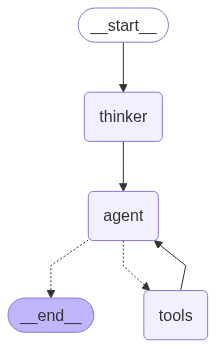

In [ ]:
from IPython.display import Image, display
from langchain_core.language_models.fake import FakeListLLM

clauses_input = [[-1, 2], [1, -2]]
solver = ReactSatSolver(chat_model=chat_model, clauses=clauses_input)
graph_image = solver.graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [ ]:
from NP_problems import verify_3sat_solution, generate_3sat_instance

# clauses_input = [[-1, 2, -3], [-1, -2, 3], [-1, 2, 3], [-1, -2, -3], [-4, 3, 1], [-4, -3, -1]]
clauses_input, known_solution = generate_3sat_instance(num_vars=8, num_clauses=50, use_random_weights=False)
solver = ReactSatSolver(chat_model, clauses_input)
solution = solver.solve(verbose=True)
print(f"Final Assignment: {solution}")

############################ Solving 3-SAT Problem #############################
Clauses: [[-8, -3, -2], [-1, 8, -7], [-3, -7, 4], [-2, -1, 8], [-7, 3, -5], [8, -7, -4], [3, 5, -1], [5, 1, -4], [2, 7, -3], [-5, -3, 2], [2, -8, -6], [5, -4, 2], [8, 7, -1], [-2, -3, 4], [2, -5, -3], [-2, -8, 4], [-3, 1, 7], [8, -7, -6], [8, 3, 6], [-8, -1, 7], [-4, -2, 8], [4, 5, 7], [-8, 1, 2], [-1, -8, 5], [-3, 4, 7], [-2, -8, 1], [8, 6, 5], [8, -5, -3], [-3, -5, -4], [5, 8, 7], [-7, 3, 8], [-8, 3, 4], [3, 1, -4], [5, 7, -1], [1, -5, 6], [-4, 6, -7], [-7, 2, -4], [-6, 7, -3], [-7, -5, 3], [1, 5, 3], [-8, -1, -2], [4, 7, -3], [-7, 4, -6], [2, 6, 7], [-1, -3, 5], [-1, 8, -2], [7, 6, -1], [-8, -2, 5], [-5, 8, 6], [8, -6, -7]]

==================================== Step 1 ====================================
================================ Human Message =================================

Please find a satisfying assignment for the following clauses: [[-8, -3, -2], [-1, 8, -7], [-3, -7, 4], [-2, -1, 8], [-7

KeyboardInterrupt: 

### ReAct Agent 4

In [ ]:

NEW_REACT_VERIFIER_PROMPT = """
You are a meticulous and rigorous logical agent responsible for verifying and solving 3-SAT problems. You operate using a hierarchy of strategies: first, you verify a candidate solution from a 'guesser' agent. If it fails, you attempt a few quick repairs. If the repairs get stuck, you switch to a full, systematic backtracking search.

---
### **PHASE 1: VERIFICATION**
---
1.  **Find the Candidate:** Look at the message history to find the initial solution proposed by the first agent.
2.  **Verify with a Tool Call:** Your **first action** MUST be to call `check_assignment` with the complete candidate solution to verify it.

---
### **PHASE 2: ACTION BASED ON VERIFICATION**
---
Analyze the `status` from your first tool call and proceed:

**IF `status` is "Satisfied":**
* **Reasoning:** "The initial candidate is correct."
* **Action:** Call `get_final_answer` with the solution. Your job is done.

**IF `status` is "Contradiction":**
* **Reasoning:** "The initial candidate is incorrect. I will attempt to repair it by flipping the first variable in the failing clause."
* **Action:** Analyze the contradiction details, identify the failing clause, create a new assignment by flipping the value of the **first** variable in that clause, and call `check_assignment` with the repaired assignment. This begins the Iterative Repair Phase.

---
### **PHASE 3: ITERATIVE REPAIR (Local Search)**
---
You are now attempting to repair the assignment. Follow these rules:

* **If the new `status` is "Contradiction":**
    * **ESCAPE HATCH:** First, check if the new failing clause is the **exact same** as the failing clause from the previous step.
        * If **YES**, the repair is stuck in a loop. **You must now switch to the full backtracking search.** Your reasoning should be: "The iterative repair is stuck in a loop. I will now discard the assignment and start a full, systematic search from scratch." Your action is to call `check_assignment` with an **empty assignment**: `assignment_str: "{}"`.
        * If **NO**, the repair is still making progress. Continue the repair strategy: identify the new failing clause, flip the first variable, and call `check_assignment` again.

* **If the new `status` is "Incomplete" or "Unit Propagation"**:
    * **Reasoning:** "The repair was successful and resolved all contradictions. I will now switch to systematic solving to complete the assignment."
    * **Action:** You are now in the Standard Backtracking phase. Handle the status as described in Phase 4.

* **If the new `status` is "Satisfied"**:
    * **Reasoning:** "The repair process succeeded."
    * **Action:** Call `get_final_answer` with the solution.

---
### **PHASE 4: STANDARD BACKTRACKING PROCEDURE (Global Search)**
---
You only enter this phase if the escape hatch in Phase 3 was triggered. You are now solving from scratch. Follow these rules until a solution is found:

* **If `status` is "Incomplete"**: Make a strategic guess by picking the first unassigned variable and setting it to `True`. Call `check_assignment`.
* **If `status` is "Incomplete"**: Make a new guess to solve problem. Do not guess a same solution again. Call `check_assignment`.
* **If `status` is "Unit Propagation"**: Add the forced assignment to your solution. Call `check_assignment`.
* **If `status` is "Contradiction"**: Backtrack on your most recent **guess** by flipping its value. Call `check_assignment`.
* **If `status` is "Satisfied"**: You have found a solution. Call `get_final_answer`.

**CRITICAL RULE**: You are forbidden from calling a tool with the exact same input that has previously failed. If an assignment results in a Contradiction, your next action must be to submit a new, modified assignment. Repeating a failed guess indicates a reasoning error and will not solve the problem.
**Primary Mandate**: You must maintain state and learn from your mistakes.

Before you output your next action, you MUST confirm the following:

* Is my status Contradiction? If yes, proceed to check 2.
* Is the new assignment I'm about to submit DIFFERENT from the one that just failed?
* It must be different. Re-submitting a known failing state is a critical error. Ensure you have correctly applied the repair or backtracking logic to create a new attempt.

**Forbidden Action**: Under no circumstances should you re-submit an assignment that has already been proven to result in a Contradiction.
**Reasoning Check**: Before every tool call, you must mentally verify: "Is this the exact assignment I just tried on my previous turn?"
**Corrective Action**: If the answer is yes, you have made a logical error. You must stop, re-evaluate the situation, and formulate a different assignment according to the rules of your current phase (Repair or Backtracking). Repeating inputs will result in failure.

"""

RETHINKER_PROMPT = """
You are a master strategist for a 3-SAT solving agent.
The agent you are guiding has become stuck in a loop after multiple attempts and has failed to find a solution. Your task is to analyze its entire history of actions and failures to devise a completely new strategy.

**Your Analysis Must Cover:**
1.  **Review the History:** Read the full sequence of tool calls and their results.
2.  **Identify Failure Patterns:** Look for loops. Is the agent repeatedly flipping the same variables back and forth? Is there a core set of clauses that remain persistently unsatisfied?
3.  **Formulate a New Hypothesis:** Based on your analysis of the failure, propose a **radically different** candidate solution. Do not just make a small tweak to the last failing assignment. For example, if many attempts failed with `x1=True`, your new hypothesis should be built around `x1=False`.

**Your Output:**
Afte thinking step by step You must provide the new candidate solution as a JSON string. This new hypothesis will be used to restart the verification and repair process.
"""

In [ ]:
import re
import json
import time
from typing import List, Dict, Set
from time import sleep
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
from typing import TypedDict

class SolverState(MessagesState):
    turn_count: int

class ReactSatSolver:
    def __init__(self, chat_model, clauses: List[List[int]], max_turns: int=4, have_rethinker_node:bool = True):
        self.max_turns = max_turns
        self.execution_time = 0
        self.have_rethinker_node = have_rethinker_node
        self.clauses = clauses
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.react_system_prompt = SystemMessage(content=NEW_REACT_VERIFIER_PROMPT)
        self.rethinker_prompt = SystemMessage(content=RETHINKER_PROMPT)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def check_assignment(assignment_str: str) -> Dict:
            """
            Checks a partial or full assignment against the problem's clauses.

            This tool takes a JSON string representing a dictionary of variable assignments,
            e.g., '{"1": true, "2": false}'. It then evaluates this assignment to find
            contradictions or forced moves (unit propagation).

            Args:
                assignment_str: A JSON string mapping integer variables to boolean values.
                                Example: '{"1": true}' or '{}' for an empty assignment.
            """
            try:
                assignment = {int(k): v for k, v in json.loads(assignment_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'assignment_str' must be a valid JSON string representing a dictionary. You provided: {assignment_str}"
                }

            all_vars: Set[int] = {abs(lit) for clause in self.clauses for lit in clause}
            unassigned_vars = sorted(list(all_vars - set(assignment.keys())))

            for i, clause in enumerate(self.clauses):
                unresolved_literals = []
                is_satisfied = False
                for literal in clause:
                    var = abs(literal)
                    if var in assignment:
                        if (literal > 0 and assignment[var]) or (literal < 0 and not assignment[var]):
                            is_satisfied = True
                            break
                    else:
                        unresolved_literals.append(literal)

            if not unresolved_literals:
                return {
                    "status": "Contradiction",
                    "unassigned_variables": unassigned_vars,
                    "details": f"The assignment {assignment} creates a contradiction in these Clauses: {unresolved_literals}."
                }


            if not unassigned_vars:
                return {
                    "status": "Satisfied",
                    "unassigned_variables": [],
                    "details": "The assignment is complete and verified."
                }
            else:
                return {
                    "status": "Incomplete",
                    "unassigned_variables": unassigned_vars,
                    "details": "The partial assignment is valid, but no new deductions can be made.",
                }

        @tool
        def get_final_answer(solution_str: str) -> Dict:
            """
            Formats the final, verified satisfying assignment for the user.

            Call this tool ONLY when you have found a complete solution. It takes the
            solution as a JSON string and presents it as the final answer.

            Args:
                solution_str: A JSON string representing the complete assignment.
                              Example: '{"1": true, "2": false, "3": true}'.
            """
            try:
                solution = {int(k): v for k, v in json.loads(solution_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_str' must be a valid JSON string representing a dictionary. You provided: {solution_str}"
                }

            return {"status": "SUCCESS", "final_solution": solution}

        tools = [check_assignment, get_final_answer]
        return tools


    def _thinker_node(self, state: SolverState) -> SolverState:
        system_content = (
            "You are a sophisticated logical reasoning engine with expertise in solving Boolean "
            "Satisfiability Problems (SAT). You will be provided with a 3-SAT problem instance, "
            "which consists of a conjunction of clauses, where each clause is a disjunction "
            "of three literals. Your primary objective is to determine if a satisfying "
            "assignment of boolean values (True or False) exists for the variables that makes "
            "the entire formula True. If a solution exists, you must provide a valid satisfying "
            "assignment. If the formula is unsatisfiable, you must state that. Your reasoning "
            "should be systematic and logical, and you should not guess. Your final output should "
            "be the assignment or a statement of unsatisfiability."
        )

        human_content = (
            f"Please solve the following 3-SAT problem:\n\n{self.clauses}\n\n"

            "Follow these steps to find a solution:\n"
            "1.  **Analyze the Clauses**: Identify all unique variables in the problem.\n"
            "2.  **Hypothesize an Assignment**: Start with an initial assignment for the variables. A good starting point is to set all variables to `True`.\n"
            "3.  **Verify the Assignment**: Check each clause to see if it is satisfied by your current assignment. A clause is satisfied if at least one of its literals is `True`.\n"
            "4.  **Iterate and Refine**:\n"
            "    * If all clauses are satisfied, you have found a solution. Present the final assignment.\n"
            "    * If a clause is not satisfied, you need to adjust your assignment. Identify the unsatisfied clause and flip the value of one of the variables in that clause.\n"
            "    * Repeat the verification process with the updated assignment.\n"
            "5.  **Conclusion**: If you find a satisfying assignment, state it clearly. If you cannot find a solution after several attempts, the problem may be unsatisfiable.\n"
            "Let's begin the step-by-step thinking process."
        )

        sys_msg = SystemMessage(content=system_content)
        human_msg = HumanMessage(content=human_content)
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _rethinker_node(self, state: SolverState) -> SolverState:
        history = state["messages"]
        new_candidate = self.chat_model.invoke([self.rethinker_prompt] + history)

        rethink_message = AIMessage(content=f"The previous strategy failed. After reflection, I will now test a new candidate solution: {new_candidate.content}")
        return {"messages": [rethink_message]}

    def _agent_node(self, state: SolverState) -> SolverState:
        sleep(0.1)
        new_message = self.model_with_tools.invoke([self.react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _router_node(self, state: SolverState) -> str:
        turn_count = state.get("turn_count", 0) + 1

        if turn_count > self.max_turns:
            state["turn_count"] = 0
            return "rethinker"
        else:
            state["turn_count"] = turn_count
            return "agent"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)

        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))
        if (self.have_rethinker_node):
            builder.add_node("rethinker", self._rethinker_node)

        builder.set_entry_point("thinker")
        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        if (self.have_rethinker_node):
            builder.add_conditional_edges("tools", self._router_node,{"agent": "agent", "rethinker": "rethinker"})
            builder.add_edge("rethinker", "agent")
        else:
            builder.add_edge("tools", "agent")

        return builder.compile()

    def get_graph_image(self):
      return self.graph.get_graph().draw_mermaid_png()

    def solve(self, verbose = True, recursion_limit=30):
        user_prompt = f"Please find a satisfying assignment for the following clauses: {self.clauses}"
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_messsage = " Solving 3-SAT Problem "
            bold_initial_messsage = f"\033[1m{initial_messsage}\033[0m"
            print(f"{bold_initial_messsage:#^88}")
            print(f"Clauses: {self.clauses}\n")

        final_state = None
        config = {"recursion_limit": recursion_limit}
        start_time = time.time()
        output = self.graph.stream(initial_messages, config=config, stream_mode="values")
        end_time = time.time()
        self.execution_time = end_time - start_time
        for i, chunk in enumerate(output):
            if verbose:
                step = f" Step {i+1} "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                chunk["messages"][-1].pretty_print()
            final_state = chunk

        if verbose:
            step = f" Final Step  "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            if last_message.tool_calls[0]['name'] == 'get_final_answer':
                args = last_message.tool_calls[0]['args']
                if 'solution_str' in args:
                    try:
                        solution = {int(k): v for k, v in json.loads(args['solution_str']).items()}
                        print("Solution Found!")
                        return solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        print("Could not find a solution.")
        return None, self.execution_time

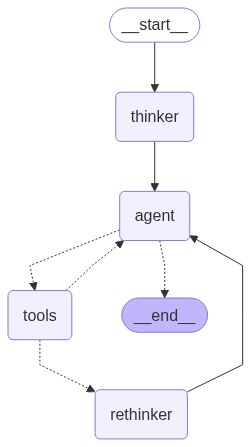

In [ ]:
from IPython.display import Image, display
from langchain_core.language_models.fake import FakeListLLM

clauses_input = [[-1, 2], [1, -2]]
solver = ReactSatSolver(chat_model=chat_model, clauses=clauses_input)
graph_image = solver.graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [ ]:
from NP_problems import verify_3sat_solution, generate_3sat_instance

# clauses_input = [[-1, 2, -3], [-1, -2, 3], [-1, 2, 3], [-1, -2, -3], [-4, 3, 1], [-4, -3, -1]]
clauses_input, known_solution = generate_3sat_instance(num_vars=8, num_clauses=50, use_random_weights=False)
solver = ReactSatSolver(chat_model, clauses_input)
solution, execution_time = solver.solve(verbose=True)
print(f"Execution Time: {execution_time}s")
print(f"Final Assignment: {solution}")

############################ Solving 3-SAT Problem #############################
Clauses: [[-8, 1, -3], [3, 5, -8], [-6, 2, -3], [5, 7, -8], [-1, -3, -7], [8, 4, -7], [1, 4, 6], [4, -2, 8], [8, 5, -3], [-3, -7, 2], [-3, 1, -8], [-2, -4, -3], [3, 6, 2], [5, 2, 7], [-3, -6, -8], [-7, -5, 2], [-5, 3, 6], [7, 2, 1], [-8, -4, 3], [5, 3, 2], [-1, 3, 2], [5, 6, -2], [-5, 8, -2], [-7, 2, 1], [-5, -3, 7], [4, 6, 8], [-3, 1, 5], [-8, 6, 3], [6, 7, 8], [-3, 6, -7], [-5, 4, -2], [8, -5, -3], [7, -8, 1], [-1, 4, 6], [-3, -4, 2], [3, 2, -8], [-7, -1, -2], [-5, -4, 3], [-1, 2, 5], [-2, 1, 7], [-5, -7, 8], [3, -8, 5], [3, -1, 6], [-5, -7, -3], [8, 7, -3], [2, -7, 5], [7, -2, 3], [6, 2, 7], [7, -3, 6], [-8, -6, 7]]

==================================== Step 1 ====================================
================================ Human Message =================================

Please find a satisfying assignment for the following clauses: [[-8, 1, -3], [3, 5, -8], [-6, 2, -3], [5, 7, -8], [-1, -3, -7], 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 32
}
].


=================================== Step 25 ====================================
================================== Ai Message ==================================

Reasoning: I am in the Standard Backtracking phase. The previous assignment `{"1": true, "2": true, "3": true, "4": true, "5": true, "6": true, "7": true}` resulted in an "Incomplete" status with `v8` as the only unassigned variable. According to the rules, I should make a strategic guess by setting the first unassigned variable (`v8`) to `True`. I will now check this complete assignment.
Tool Calls:
  check_assignment (4462c07b-ca38-46e9-bd65-f2b338fe2b49)
 Call ID: 4462c07b-ca38-46e9-bd65-f2b338fe2b49
  Args:
    assignment_str: {"1": true, "2": true, "3": true, "4": true, "5": true, "6": true, "7": true, "8": true}
=================================== Step 26 ====================================
================================= Tool Message =================================
Name: check_assignment

{"status": "Contradiction

ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 29
}
]

## Hamilton Cycle

### ReAct Agent 1

#### Model

In [ ]:
import re
import time
import json
import random
from time import sleep
from langchain_core.tools import tool
from typing import List, Dict, Set, Any
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from NP_problems import generate_hamiltonian_cycle_graph, verify_hamiltonian_cycle, solve_hamiltonian_cycle_with_z3, visualize_hamiltonian_cycle_graph
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState


class ReactHamiltonCycleSolver:
    def __init__(self, chat_model: Any, input_graph: Dict[int, List[int]], known_solution: List[int]):
        self.input_graph = input_graph
        self.known_solution = known_solution
        self.known_solution.append(known_solution[0])
        self.found_solution = None
        self.execution_time = None
        self.num_vertices = len(input_graph)
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def verify_solution(solution_path_str: str) -> Dict:
            """
            Checks if a proposed path is a valid Hamiltonian cycle for the graph.
            A Hamiltonian cycle must visit every vertex exactly once and return to the starting vertex.

            Args:
                solution_path_str: A JSON string representing a list of vertices, e.g., '[0, 1, 3, 2, 0]'.

            Returns:
                A dictionary indicating if the solution is valid and providing details.
            """
            try:
                path = json.loads(solution_path_str)
            except json.JSONDecodeError:
                return {"is_valid": False, "reason": f"Invalid input. Not a valid JSON list."}

            if not isinstance(path, list):
                 return {"is_valid": False, "reason": f"Input must be a list of nodes."}

            if path[0] != path[-1]:
                return {"is_valid": False, "reason": f"The path is not a cycle. It starts at {path[0]} and ends at {path[-1]}."}

            required_nodes = set(self.input_graph.keys())
            visited_nodes = set(path[:-1])
            if visited_nodes != required_nodes:
                missing = required_nodes - visited_nodes
                extra = visited_nodes - required_nodes
                reason = ""
                if missing:
                    reason += f"The path does not visit all vertices. Missing: {missing}. "
                if extra:
                    reason += f"The path visits invalid vertices: {extra}. "
                if len(path[:-1]) != len(visited_nodes):
                    reason += "The path visits some vertices more than once. "
                return {"is_valid": False, "reason": reason.strip()}

            invalid_edges = []
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if v not in self.input_graph.get(u, []):
                    invalid_edges.append((u, v))
                    # return {"is_valid": False, "reason": f"The edge ({u}, {v}) does not exist in the graph."}

            if invalid_edges:
                return {"is_valid": False, "reason": f"these edges do not exist in the graph: {invalid_edges}."}

            return {"is_valid": True, "reason": "This is a valid Hamiltonian Cycle."}

        @tool
        def get_neighbors(node: int) -> Dict:
            """
            Returns the list of neighbors for a given node in the graph.
            Args:
                node: The integer representing the node.

            Returns:
                A dictionary containing the node and its neighbors.
            """
            if node not in self.input_graph:
                return {"error": f"Node {node} not in graph."}
            return {"node": node, "neighbors": self.input_graph[node]}

        @tool
        def get_all_nodes() -> Dict:
            """
            Returns a list of all nodes in the graph.

            Returns:
                A dictionary containing the list of all nodes.
            """
            return {"nodes": list(self.input_graph.keys())}

        @tool
        def get_final_answer(solution_path_str: str) -> Dict:
            """
            Formats the final, verified solution and concludes the process.
            Call this tool ONLY when `verify_solution` has returned `is_valid: True`.

            Args:
                solution_path_str: A JSON string of the list representing the final verified Hamiltonian cycle.

            Returns:
                A dictionary containing the final solution.
            """
            try:
                solution = json.loads(solution_path_str)
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_path_str' must be a valid JSON string representing a list. You provided: {solution_path_str}"
                }
            return {"status": "SUCCESS", "final_solution": solution}

        tools = [verify_solution, get_neighbors, get_all_nodes, get_final_answer]
        return tools

    def _thinker_node(self, state: MessagesState) -> MessagesState:
        system_content = (
            f"You are a graph theory expert. Your task is to find a Hamiltonian cycle in the following undirected graph:\n"
            f"Graph (Adjacency List): {json.dumps(self.input_graph)}\n\n"
            "A Hamiltonian cycle is a closed loop that visits every vertex in the graph exactly once.\n"
            "Analyze the graph, consider the degrees of the vertices, and try to construct a path step-by-step. "
            "A good heuristic is to start with a node of a low degree.\n"
            "Provide your detailed thought process and then state your proposed complete Hamiltonian cycle as a list of vertices, "
            "starting and ending at the same vertex. Your output should be just your reasoning and the proposed path."
        )
        sys_msg = SystemMessage(content=system_content)
        human_msg = state['messages'][0]
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        system_content = (
            "You are a diligent assistant that verifies and corrects a proposed solution for the Hamiltonian Cycle problem.\n"
            f"The graph is: {json.dumps(self.input_graph)}\n"
            f"Your goal is to find a valid Hamiltonian Cycle, which visits every one of the {self.num_vertices} vertices exactly once and forms a closed loop.\n\n"
            "Follow these steps:\n"
            "1. **Analyze the proposed path** provided in the previous step.\n"
            "2. **Verify the path**: Use the `verify_solution` tool to check its validity.\n"
            "3. **If Correct**: Call `get_final_answer` with the verified path to finish.\n"
            "4. **If Incorrect**: The `verify_solution` tool will explain why. Use other tools like `get_neighbors` and `get_all_nodes` to understand the graph's structure. Reason about the error and construct a NEW, corrected path. Then, go back to step 2 to verify your new path.\n"
            "5. **Iterate**: Continue this cycle of proposing a new path and verifying it until a valid solution is found. A solution is guaranteed to exist."
        )
        react_system_prompt = SystemMessage(content=system_content)
        new_message = self.model_with_tools.invoke([react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)

        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")

        return builder.compile()

    def solve(self, verbose = True):
        user_prompt = f"Please find a Hamiltonian cycle for the graph provided in the system instructions."
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_message = " Solving Hamiltonian Cycle Problem "
            bold_initial_message = f"\033[1m{initial_message}\033[0m"
            print(f"{bold_initial_message:#^88}")
            print(f"Graph: {json.dumps(self.input_graph)}\n")

        final_state = None
        start_time = time.time()
        for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
            if verbose:
                node_name = list(chunk.keys())[0]
                step = f" Step {i+1}: Executing '{node_name}' Node "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                chunk["messages"][-1].pretty_print()
            final_state = chunk
        end_time = time.time()
        self.execution_time = end_time - start_time

        if verbose:
            step = f" Final Result "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            if tool_call['name'] == 'get_final_answer':
                args = tool_call['args']
                if 'solution_path_str' in args:
                    try:
                        self.found_solution = json.loads(args['solution_path_str'])
                        is_correct = verify_hamiltonian_cycle(self.input_graph, self.found_solution)
                        if (verbose):
                            print(f"Input Graph: {json.dumps(self.input_graph)}")
                            print(f"Execution Time: {self.execution_time:.2f} seconds")
                            print(f"A Known Correct Solution: {self.known_solution}")
                            print(f"Agent's Found Solution:   {self.found_solution}")
                            if (is_correct):
                                print("\n\033[92m\033[1mFound Solution Is Correct\033[0m")
                            if (not is_correct):
                                print("\n\033[91m\033[1mFound Solution Is Incorrect\033[0m")
                        return self.found_solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        if (verbose):
            print("\033[91m\033[1mCould not find a solution.\033[0m")
        return None, self.execution_time

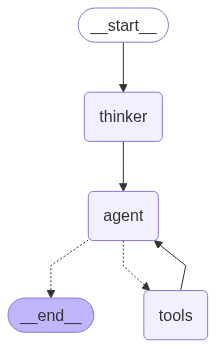

In [ ]:
from IPython.display import Image, display

input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=8, edge_density=0.3)
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
graph_image = solver.graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

#### Result 1

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=20, edge_density=0.5)

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

Execution Time: 143.16 seconds
A Known Correct Solution: [5, 16, 2, 9, 4, 0, 17, 3, 18, 1, 13, 11, 12, 6, 8, 19, 10, 7, 15, 14]
z3's Found Solution:      [2, 15, 7, 5, 17, 0, 12, 19, 1, 11, 14, 16, 13, 3, 10, 8, 6, 4, 18, 9]


In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [4, 17, 1, 5, 7, 8, 10, 12, 15, 16, 18], "1": [18, 13, 0, 5, 8, 11, 12, 15, 16, 17, 19], "2": [16, 9, 7, 11, 15, 19], "3": [17, 18, 4, 7, 9, 10, 11, 12, 13, 14, 19], "4": [9, 0, 3, 6, 12, 13, 16, 18], "5": [16, 14, 0, 1, 7, 8, 12, 15, 17, 18], "6": [12, 8, 4, 9, 17, 19], "7": [10, 15, 0, 2, 3, 5, 8, 9, 11, 13, 14, 18, 19], "8": [6, 19, 0, 1, 5, 7, 10, 12, 14, 15, 17], "9": [2, 4, 3, 6, 7, 10, 13, 14, 15, 18, 19], "10": [19, 7, 0, 3, 8, 9, 12, 13, 14, 16, 18], "11": [13, 12, 1, 2, 3, 7, 14, 19], "12": [11, 6, 0, 1, 3, 4, 5, 8, 10, 13, 14, 16, 17, 18, 19], "13": [1, 11, 3, 4, 7, 9, 10, 12, 15, 16, 17, 18], "14": [15, 5, 3, 7, 8, 9, 10, 11, 12, 16], "15": [7, 14, 0, 1, 2, 5, 8, 9, 13, 16], "16": [5, 2, 0, 1, 4, 10, 12, 13, 14, 15, 19], "17": [0, 3, 1, 5, 6, 8, 12, 13], "18": [3, 1, 0, 4, 5, 7, 9, 10, 12, 13], "19": [8, 10, 1, 2, 3, 6, 7, 9, 11, 12, 16]}

====================== Step 1: Executing '

#### Result 2

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=20, edge_density=0.2)

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

Execution Time: 2609.11 seconds
Z3 could not find a Hamiltonian Cycle.


In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [13, 9, 4, 6, 7, 10], "1": [18, 13, 12], "2": [8, 12, 4, 5, 9, 10, 15], "3": [7, 16, 8], "4": [14, 5, 0, 2, 11, 16, 19], "5": [17, 4, 2, 8], "6": [16, 11, 0, 10, 13, 17], "7": [9, 3, 0], "8": [10, 2, 3, 5, 16, 17], "9": [0, 7, 2, 11, 12, 13, 14, 16], "10": [11, 8, 0, 2, 6, 17], "11": [6, 10, 4, 9, 17], "12": [2, 19, 1, 9], "13": [1, 0, 6, 9], "14": [15, 4, 9, 16], "15": [19, 14, 2], "16": [3, 6, 4, 8, 9, 14, 17, 18], "17": [5, 18, 6, 8, 10, 11, 16], "18": [17, 1, 16, 19], "19": [12, 15, 4, 18]}

====================== Step 1: Executing 'messages' Node =======================
================================ Human Message =================================

Please find a Hamiltonian cycle for the graph provided in the system instructions.
====================== Step 2: Executing 'messages' Node =======================
================================== Ai Message ================================

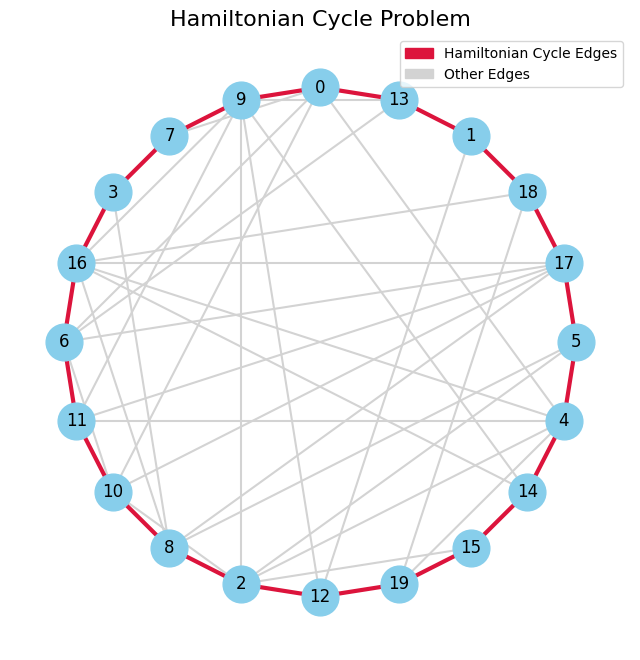

In [ ]:
visualize_hamiltonian_cycle_graph(input_graph, known_solution)

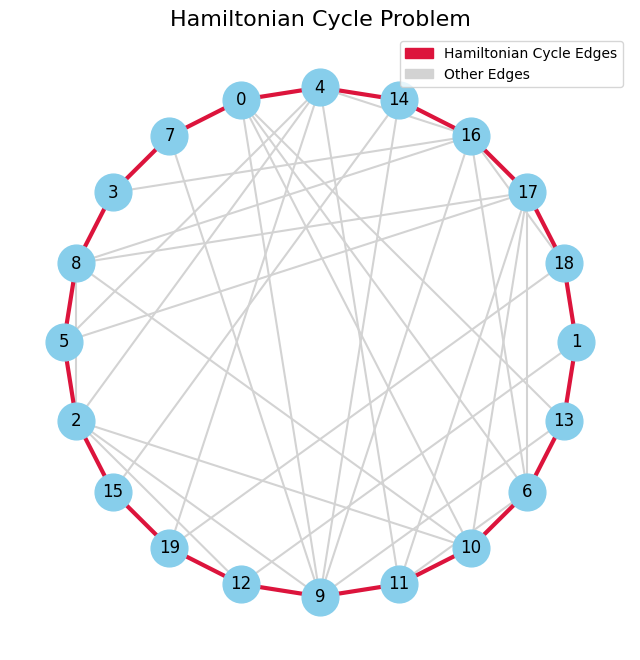

In [ ]:
visualize_hamiltonian_cycle_graph(input_graph, agent_solution)

#### Result 3

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=25, edge_density=0.3)
for key, value in input_graph.items():
    input_graph[key] = sorted(input_graph[key])

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

Execution Time: 811.67 seconds
Z3 could not find a Hamiltonian Cycle.


In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [1, 2, 3, 5, 9, 10, 11, 13, 16, 17, 18, 19, 20, 22], "1": [0, 10, 11, 14, 17, 19, 20], "2": [0, 6, 7, 8, 10, 14, 17, 20, 21, 23], "3": [0, 4, 6, 7, 8, 11, 14, 16, 19, 22, 24], "4": [3, 5, 9, 10, 14, 15, 16, 18], "5": [0, 4, 6, 8, 10, 11, 12, 14, 17, 21, 23, 24], "6": [2, 3, 5, 9, 15, 16, 18, 19, 22, 23, 24], "7": [2, 3, 8, 10, 12, 13, 16, 17, 22], "8": [2, 3, 5, 7, 9, 19, 22], "9": [0, 4, 6, 8, 10, 13, 14, 15, 20, 21, 22, 23], "10": [0, 1, 2, 4, 5, 7, 9, 11, 14, 20, 24], "11": [0, 1, 3, 5, 10, 14, 17, 19], "12": [5, 7, 16, 19, 21, 24], "13": [0, 7, 9, 15, 18, 20, 23], "14": [1, 2, 3, 4, 5, 9, 10, 11, 16, 18, 22, 24], "15": [4, 6, 9, 13, 17, 21], "16": [0, 3, 4, 6, 7, 12, 14, 17, 21, 22], "17": [0, 1, 2, 5, 7, 11, 15, 16, 18, 20, 21, 24], "18": [0, 4, 6, 13, 14, 17, 22], "19": [0, 1, 3, 6, 8, 11, 12, 21, 22, 23, 24], "20": [0, 1, 2, 9, 10, 13, 17, 21, 24], "21": [2, 5, 9, 12, 15, 16, 17, 19, 20

#### Result 4

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=25, edge_density=0.7)
for key, value in input_graph.items():
    input_graph[key] = sorted(input_graph[key])

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

Execution Time: 10.28 seconds
A Known Correct Solution: [11, 8, 0, 23, 6, 20, 22, 21, 3, 19, 7, 24, 12, 10, 4, 13, 1, 16, 14, 9, 5, 15, 18, 2, 17]
z3's Found Solution:      [11, 24, 8, 3, 22, 17, 10, 1, 12, 15, 4, 14, 18, 2, 13, 21, 6, 9, 20, 16, 7, 5, 23, 19, 0]


In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], "1": [0, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 18, 21, 22], "2": [0, 1, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24], "3": [0, 1, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24], "4": [0, 1, 3, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24], "5": [0, 1, 3, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24], "6": [0, 1, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 23, 24], "7": [1, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, 18, 19, 20, 22, 23, 24], "8": [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 23, 24], "9": [0, 2, 3, 5, 6, 8, 10, 11, 14, 16, 17, 18, 19, 20, 21, 24], "10": [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 16, 17, 19, 21], "11": [0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24], "12": [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 13, 14, 

#### Result 5

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=30, edge_density=0.3)
input_graph = {key: sorted(value) for key, value in input_graph.items()}

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

Execution Time: 1129.27 seconds
Z3 could not find a Hamiltonian Cycle.


In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [3, 5, 15, 18, 19, 20, 25], "1": [2, 4, 6, 7, 11, 14, 15, 16, 19, 20], "2": [1, 4, 5, 10, 13, 19, 22, 27], "3": [0, 8, 9, 11, 14, 19, 23, 25], "4": [1, 2, 5, 6, 7, 9, 11, 16, 19, 21, 26, 27, 29], "5": [0, 2, 4, 7, 16, 17, 23, 26, 27, 28], "6": [1, 4, 7, 10, 13, 16, 18, 20, 21, 24, 25, 28], "7": [1, 4, 5, 6, 8, 9, 11, 14, 28, 29], "8": [3, 7, 13, 14, 17, 18, 19, 22, 29], "9": [3, 4, 7, 10, 13, 16, 17, 21, 23, 28], "10": [2, 6, 9, 14, 17, 23, 26, 29], "11": [1, 3, 4, 7, 14, 15, 23, 27], "12": [14, 15, 16, 17, 18, 23, 27], "13": [2, 6, 8, 9, 14, 17, 20, 23, 24], "14": [1, 3, 7, 8, 10, 11, 12, 13, 15, 17, 18, 20, 22, 24], "15": [0, 1, 11, 12, 14, 18, 23, 24, 26], "16": [1, 4, 5, 6, 9, 12, 19, 20, 24, 25, 28, 29], "17": [5, 8, 9, 10, 12, 13, 14, 20, 28, 29], "18": [0, 6, 8, 12, 14, 15, 20, 21, 29], "19": [0, 1, 2, 3, 4, 8, 16, 22], "20": [0, 1, 6, 13, 14, 16, 17, 18, 22, 29], "21": [4, 6, 9, 18, 24

#### Result 6

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=40, edge_density=0.3)
input_graph = {key: sorted(value) for key, value in input_graph.items()}

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [1, 4, 7, 9, 14, 16, 18, 19, 21, 25, 27, 28, 29, 37, 38], "1": [0, 2, 3, 10, 14, 16, 18, 20, 23, 24, 27, 29, 32, 38], "2": [1, 4, 7, 11, 12, 14, 16, 17, 18, 23, 27, 29, 30, 34, 36, 37], "3": [1, 6, 7, 9, 10, 13, 18, 21, 31, 33, 35, 37, 38, 39], "4": [0, 2, 5, 6, 7, 8, 9, 10, 17, 18, 22, 24, 25, 30, 31, 32, 34, 35], "5": [4, 9, 22, 26, 33, 34, 36, 38], "6": [3, 4, 9, 13, 14, 19, 20, 26, 27, 30, 31, 32, 36], "7": [0, 2, 3, 4, 8, 9, 15, 23, 24, 26, 27, 29, 32, 33, 34, 36, 37], "8": [4, 7, 9, 11, 12, 13, 16, 19, 22, 23, 28, 31, 32, 37], "9": [0, 3, 4, 5, 6, 7, 8, 10, 19, 21, 23, 25, 28, 30, 31, 33, 37], "10": [1, 3, 4, 9, 13, 18, 20, 21, 25, 27, 30, 33, 37, 39], "11": [2, 8, 13, 16, 20, 21, 23, 25, 26, 30, 37], "12": [2, 8, 18, 20, 21, 22, 28, 33, 35, 37], "13": [3, 6, 8, 10, 11, 16, 19, 27, 29, 30, 32, 33, 34, 35, 37, 39], "14": [0, 1, 2, 6, 15, 17, 19, 20, 22, 23, 25, 27, 34, 37, 39], "15": [7, 

====================== Step 5: Executing 'messages' Node =======================
================================== Ai Message ==================================
Tool Calls:
  verify_solution (c7ec2635-6987-4138-b07b-f6b34f55c155)
 Call ID: c7ec2635-6987-4138-b07b-f6b34f55c155
  Args:
    solution_path_str: [5, 38, 31, 3, 1, 0, 4, 2, 12, 8, 11, 20, 6, 13, 39, 10, 30, 15, 14, 17, 18, 24, 22, 23, 7, 9, 19, 21, 16, 35, 25, 32, 27, 29, 26, 36, 28, 34, 37, 33, 5]
====================== Step 6: Executing 'messages' Node =======================
================================= Tool Message =================================
Name: verify_solution

{"is_valid": true, "reason": "This is a valid Hamiltonian Cycle."}
====================== Step 7: Executing 'messages' Node =======================
================================== Ai Message ==================================

The proposed Hamiltonian cycle `[5, 38, 31, 3, 1, 0, 4, 2, 12, 8, 11, 20, 6, 13, 39, 10, 30, 15, 14, 17, 18, 24, 22, 23, 7

#### Result 7:

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=50, edge_density=0.5)
input_graph = {key: sorted(value) for key, value in input_graph.items()}

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [1, 2, 3, 4, 5, 7, 9, 10, 11, 13, 18, 20, 23, 25, 27, 29, 32, 35, 36, 39, 41, 43, 44, 45, 46, 47, 48, 49], "1": [0, 5, 6, 7, 8, 11, 12, 19, 23, 24, 25, 26, 27, 28, 29, 30, 32, 39, 40, 42, 44, 45, 48, 49], "2": [0, 3, 4, 7, 8, 9, 11, 12, 14, 21, 22, 23, 26, 27, 30, 33, 34, 36, 39, 40, 41, 42, 44, 48], "3": [0, 2, 4, 5, 6, 9, 11, 13, 14, 15, 16, 17, 19, 21, 22, 26, 27, 28, 29, 35, 38, 40, 44, 45, 46, 47, 48, 49], "4": [0, 2, 3, 5, 6, 7, 8, 11, 13, 20, 21, 23, 24, 25, 26, 28, 31, 33, 36, 37, 38, 39, 41, 43, 45, 47, 48], "5": [0, 1, 3, 4, 7, 8, 9, 14, 15, 16, 17, 18, 19, 21, 22, 24, 26, 27, 29, 33, 35, 37, 40, 41, 45, 46, 47, 48, 49], "6": [1, 3, 4, 8, 10, 11, 14, 16, 17, 18, 20, 21, 29, 34, 36, 38, 41, 42, 44, 45, 48], "7": [0, 1, 2, 4, 5, 8, 11, 12, 13, 15, 18, 19, 21, 22, 24, 25, 26, 28, 29, 30, 31, 33, 38, 39, 41, 48], "8": [1, 2, 4, 5, 6, 7, 9, 11, 13, 16, 17, 18, 19, 20, 24, 25, 26, 28, 32, 

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

### ReAct Agent 2

#### Tests

In [ ]:
import time
from z3 import *

def solve_hamiltonian_cycle_with_hint(graph, hint_path=None):
    start_time = time.time()
    num_vertices = len(graph)

    solver = Optimize()

    pos_vars = {v: Int(f"pos_{v}") for v in graph.keys()}

    for v in graph.keys():
        solver.add(And(pos_vars[v] >= 0, pos_vars[v] < num_vertices))

    solver.add(Distinct(list(pos_vars.values())))

    all_vertices = list(graph.keys())
    for i in range(num_vertices):
        u = all_vertices[i]
        for j in range(num_vertices):
            if i == j:
                continue
            v = all_vertices[j]
            if v not in graph[u]:
                solver.add((pos_vars[u] + 1) % num_vertices != pos_vars[v])


    if hint_path and len(hint_path) == num_vertices:
        matches = []
        for i, v in enumerate(hint_path):
            if v in pos_vars:
                matches.append(If(pos_vars[v] == i, 1, 0))

        solver.maximize(Sum(matches))

    check_result = solver.check()
    end_time = time.time()
    execution_time = end_time - start_time

    if check_result == sat:
        model = solver.model()
        path_map = {model.eval(pos_vars[v]).as_long(): v for v in graph.keys()}
        hamiltonian_cycle = [path_map[i] for i in range(num_vertices)]
        return hamiltonian_cycle, execution_time
    else:
        return None, execution_time

graph = {
    0: [1, 3],
    1: [0, 2],
    2: [1, 3],
    3: [2, 0]
}

good_hint = [0, 1, 2, 3]

bad_hint = [0, 1, 3, 2]

print("Solving with a good hint...")
cycle, exec_time = solve_hamiltonian_cycle_with_hint(graph, good_hint)
print(f"Found cycle: {cycle} in {exec_time:.6f} seconds\n")

print("Solving with a slightly incorrect hint...")
cycle, exec_time = solve_hamiltonian_cycle_with_hint(graph, bad_hint)
print(f"Found cycle: {cycle} in {exec_time:.6f} seconds\n")

print("Solving with no hint...")
cycle, exec_time = solve_hamiltonian_cycle_with_hint(graph)
print(f"Found cycle: {cycle} in {exec_time:.6f} seconds")

Solving with a good hint...
Found cycle: [0, 1, 2, 3] in 0.043915 seconds

Solving with a slightly incorrect hint...
Found cycle: [0, 1, 2, 3] in 0.068573 seconds

Solving with no hint...
Found cycle: [0, 3, 2, 1] in 0.007365 seconds


In [ ]:
graph = {
    0: [1, 4, 7, 9, 14, 16, 18, 19, 21, 25, 27, 28, 29, 37, 38],
    1: [0, 2, 3, 10, 14, 16, 18, 20, 23, 24, 27, 29, 32, 38],
    2: [1, 4, 7, 11, 12, 14, 16, 17, 18, 23, 27, 29, 30, 34, 36, 37],
    3: [1, 6, 7, 9, 10, 13, 18, 21, 31, 33, 35, 37, 38, 39],
    4: [0, 2, 5, 6, 7, 8, 9, 10, 17, 18, 22, 24, 25, 30, 31, 32, 34, 35],
    5: [4, 9, 22, 26, 33, 34, 36, 38],
    6: [3, 4, 9, 13, 14, 19, 20, 26, 27, 30, 31, 32, 36],
    7: [0, 2, 3, 4, 8, 9, 15, 23, 24, 26, 27, 29, 32, 33, 34, 36, 37],
    8: [4, 7, 9, 11, 12, 13, 16, 19, 22, 23, 28, 31, 32, 37],
    9: [0, 3, 4, 5, 6, 7, 8, 10, 19, 21, 23, 25, 28, 30, 31, 33, 37],
    10: [1, 3, 4, 9, 13, 18, 20, 21, 25, 27, 30, 33, 37, 39],
    11: [2, 8, 13, 16, 20, 21, 23, 25, 26, 30, 37],
    12: [2, 8, 18, 20, 21, 22, 28, 33, 35, 37],
    13: [3, 6, 8, 10, 11, 16, 19, 27, 29, 30, 32, 33, 34, 35, 37, 39],
    14: [0, 1, 2, 6, 15, 17, 19, 20, 22, 23, 25, 27, 34, 37, 39],
    15: [7, 14, 16, 17, 21, 22, 23, 27, 30, 33, 34, 37],
    16: [0, 1, 2, 8, 11, 13, 15, 19, 21, 22, 27, 28, 33, 35, 37],
    17: [2, 4, 14, 15, 18, 19, 21, 22, 23, 25, 26, 27, 28, 33, 35, 38],
    18: [0, 1, 2, 3, 4, 10, 12, 17, 20, 24, 27, 28, 29, 31, 32, 36, 38, 39],
    19: [0, 6, 8, 9, 13, 14, 16, 17, 21, 22, 25, 26, 28, 29, 30, 38, 39],
    20: [1, 6, 10, 11, 12, 14, 18, 21, 26, 27, 29, 34, 36],
    21: [0, 3, 9, 10, 11, 12, 15, 16, 17, 19, 20, 23, 25, 28, 32, 35, 36, 37, 39],
    22: [4, 5, 8, 12, 14, 15, 16, 17, 19, 23, 24, 27, 28, 33, 35, 37, 39],
    23: [1, 2, 7, 8, 9, 11, 14, 15, 17, 21, 22, 24, 27, 30, 32, 37],
    24: [1, 4, 7, 18, 22, 23, 25, 26, 29, 31, 33, 35, 39],
    25: [0, 4, 9, 10, 11, 14, 17, 19, 21, 24, 27, 32, 34, 35, 39],
    26: [5, 6, 7, 11, 17, 19, 20, 24, 28, 29, 35, 36, 38],
    27: [0, 1, 2, 6, 7, 10, 13, 14, 15, 16, 17, 18, 20, 22, 23, 25, 29, 30, 32, 34, 35, 37, 38],
    28: [0, 8, 9, 12, 16, 17, 18, 19, 21, 22, 26, 29, 30, 34, 35, 36, 38, 39],
    29: [0, 1, 2, 7, 13, 18, 19, 20, 24, 26, 27, 28, 36, 37, 39],
    30: [2, 4, 6, 9, 10, 11, 13, 15, 19, 23, 27, 28, 39],
    31: [3, 4, 6, 8, 9, 18, 24, 32, 33, 36, 38],
    32: [1, 4, 6, 7, 8, 13, 18, 21, 23, 25, 27, 31],
    33: [3, 5, 7, 9, 10, 12, 13, 15, 16, 17, 22, 24, 31, 34, 36, 37],
    34: [2, 4, 5, 7, 13, 14, 15, 20, 25, 27, 28, 33, 35, 37, 39],
    35: [3, 4, 12, 13, 16, 17, 21, 22, 24, 25, 26, 27, 28, 34, 36, 39],
    36: [2, 5, 6, 7, 18, 20, 21, 26, 28, 29, 31, 33, 35],
    37: [0, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 21, 22, 23, 27, 29, 33, 34, 38, 39],
    38: [0, 1, 3, 5, 17, 18, 19, 26, 27, 28, 31, 37],
    39: [3, 10, 13, 14, 18, 19, 21, 22, 24, 25, 28, 29, 30, 34, 35, 37]
}

# good_hint = [5, 38, 31, 3, 1, 0, 4, 2, 12, 8, 11, 20, 6, 13, 39, 10, 30, 15, 14, 17, 18, 24, 22, 23, 7, 9, 19, 21, 16, 35, 25, 32, 27, 28, 26, 36, 29, 37, 34, 33]
good_hint = [35, 38, 31, 1, 12, 17, 5, 2, 0, 8, 11, 20, 6, 13, 39, 10, 30, 15, 14, 3, 18, 24, 4, 25, 7, 9, 19, 21, 16, 37, 23, 32, 27, 28, 26, 36, 29, 22, 34, 33]
# good_hint = [5, 38, 31, 3, 1, 0, 4, 2, 12, 8, 11, 20, 6, 13, 39, 10, 30, 15, 14, 17, 18, 24, 22, 23, 7, 9, 19, 21, 16, 35, 25, 32, 27, 29, 26, 36, 28, 34, 37, 33]

# print("Solving with a good hint...")
# cycle, exec_time = solve_hamiltonian_cycle_with_hint(graph, good_hint)
# print(f"Found cycle: {cycle} in {exec_time:.6f} seconds\n")

In [ ]:
verify_hamiltonian_cycle(good_hint, graph)

(False,
 'Verification FAILED: Path is not connected (Missing edge between 35 and 38)')

In [ ]:
from NP_problems import generate_hamiltonian_cycle_graph, verify_hamiltonian_cycle, solve_hamiltonian_cycle_with_z3, visualize_hamiltonian_cycle_graph

a, b = solve_with_local_search_repair(graph, good_hint)

print(b)
print(a)
verify_hamiltonian_cycle(a, graph)

1
[0, 38, 3, 33, 5, 26, 11, 23, 30, 39, 29, 13, 32, 31, 24, 25, 4, 6, 14, 15, 16, 37, 34, 35, 36, 7, 8, 9, 10, 27, 18, 17, 2, 1, 20, 21, 28, 12, 22, 19]


(True, 'Verification PASSED: The solution is a valid Hamiltonian Cycle.')

In [ ]:
from NP_problems import generate_hamiltonian_cycle_graph, verify_hamiltonian_cycle, solve_hamiltonian_cycle_with_z3, visualize_hamiltonian_cycle_graph
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=1000, edge_density=0.3)

a, b = solve_with_local_search_repair(input_graph, list(range(1000)))

print(b)
print(a)
verify_hamiltonian_cycle(a, input_graph)



0


KeyboardInterrupt: 

In [ ]:
def count_broken_edges(graph, path):
    num_vertices = len(graph)
    broken_count = 0
    edges = {node: set(neighbors) for node, neighbors in graph.items()}
    for i in range(num_vertices):
        u = path[i]
        v = path[(i + 1) % num_vertices]
        if v not in edges.get(u, set()):
            broken_count += 1
    return broken_count

def perform_2_opt_swap(path, i, j):
    new_path = path[:i+1]
    segment_to_reverse = path[j:i:-1]
    new_path.extend(segment_to_reverse)
    new_path.extend(path[j+1:])
    return new_path

def solve_with_local_search_repair(graph, hint_path, max_iterations: int = 1000):
    current_path = list(hint_path)
    num_vertices = len(graph)
    best_cost = count_broken_edges(graph, current_path)

    if best_cost == 0:
        return current_path, 0

    for iteration in range(max_iterations):
        print(iteration)
        improved_in_this_pass = False
        for i in range(num_vertices - 1):
            for j in range(i + 2, num_vertices):

                new_path = perform_2_opt_swap(current_path, i, j)
                new_cost = count_broken_edges(graph, new_path)

                if new_cost < best_cost:
                    current_path = new_path
                    best_cost = new_cost
                    improved_in_this_pass = True
                    if best_cost == 0:
                        return current_path, iteration + 1

        if not improved_in_this_pass:
            return None, iteration + 1

    return None, max_iterations

In [ ]:
graph = {
    0: [1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
    1: [0, 2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 18, 21, 22],
    2: [0, 1, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24],
    3: [0, 1, 4, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24],
    4: [0, 1, 3, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24],
    5: [0, 1, 3, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24],
    6: [0, 1, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 21, 23, 24],
    7: [1, 4, 5, 6, 8, 10, 11, 12, 13, 14, 16, 18, 19, 20, 22, 23, 24],
    8: [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 23, 24],
    9: [0, 2, 3, 5, 6, 8, 10, 11, 14, 16, 17, 18, 19, 20, 21, 24],
    10: [1, 2, 3, 4, 6, 7, 8, 9, 11, 12, 16, 17, 19, 21],
    11: [0, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24],
    12: [0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 20, 21, 22, 24],
    13: [0, 1, 2, 4, 5, 7, 8, 11, 12, 14, 15, 20, 21, 22, 23, 24],
    14: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24],
    15: [0, 1, 3, 4, 5, 6, 8, 11, 12, 13, 14, 18, 19, 20, 21, 22, 23, 24],
    16: [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 18, 19, 20, 22, 24],
    17: [0, 2, 4, 5, 6, 8, 9, 10, 11, 12, 18, 19, 20, 21, 22],
    18: [0, 1, 2, 3, 4, 5, 7, 8, 9, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24],
    19: [0, 2, 3, 6, 7, 9, 10, 11, 14, 15, 16, 17, 18, 20, 22, 23, 24],
    20: [0, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24],
    21: [0, 1, 2, 3, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23],
    22: [0, 1, 2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24],
    23: [0, 2, 3, 5, 6, 7, 8, 11, 13, 14, 15, 18, 19, 21, 22, 24],
    24: [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 22, 23]
}

good_hint = [0, 1, 2, 8, 3, 4, 7, 5, 6, 10, 17, 9, 14, 13, 12, 11, 15, 18, 16, 22, 21, 23, 24, 20, 19]

# print("Solving with a good hint...")
# cycle, exec_time = solve_hamiltonian_cycle_with_hint(graph, good_hint)
# print(f"Found cycle: {cycle} in {exec_time:.6f} seconds\n")

# print("Solving with no hint...")
# cycle, exec_time = solve_hamiltonian_cycle_with_hint(graph)
# print(f"Found cycle: {cycle} in {exec_time:.6f} seconds")

In [ ]:
solve_with_local_search_repair(graph, good_hint)

Hint was already a valid solution!


([0,
  1,
  2,
  8,
  3,
  4,
  7,
  5,
  6,
  10,
  17,
  9,
  14,
  13,
  12,
  11,
  15,
  18,
  16,
  22,
  21,
  23,
  24,
  20,
  19],
 0)

In [ ]:
from NP_problems import generate_hamiltonian_cycle_graph, verify_hamiltonian_cycle, solve_hamiltonian_cycle_with_z3, visualize_hamiltonian_cycle_graph

input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=12, edge_density=0.4)
print(known_solution)

[11, 10, 0, 4, 9, 5, 3, 6, 7, 8, 2, 1]


In [ ]:
print("Solving with no hint...")
cycle, exec_time = solve_hamiltonian_cycle_with_hint(input_graph)
print(f"Found cycle: {cycle} in {exec_time:.6f} seconds")

Solving with no hint...
Found cycle: [2, 1, 7, 8, 6, 3, 5, 9, 11, 10, 0, 4] in 27.096315 seconds


In [ ]:
good_hint = [11, 0, 10, 4, 9, 5, 3, 6, 7, 8, 2, 1]

print("Solving with a good hint...")
cycle, exec_time = solve_hamiltonian_cycle_with_hint(input_graph, good_hint)
print(f"Found cycle: {cycle} in {exec_time:.6f} seconds\n")

Solving with a good hint...
Found cycle: [11, 10, 0, 4, 9, 5, 3, 6, 7, 8, 2, 1] in 53.438403 seconds



In [ ]:
solve_with_local_search_repair(input_graph, [11, 0, 10, 4, 9, 5, 3, 6, 7, 8, 2, 1])

([11, 10, 0, 4, 9, 5, 3, 6, 7, 8, 2, 1], 1)

In [ ]:
import random

def count_broken_edges(graph, path):
    num_vertices = len(graph)
    broken_count = 0
    for i in range(num_vertices):
        u = path[i]
        v = path[(i + 1) % num_vertices]
        if v not in graph[u]:
            broken_count += 1
    return broken_count

def perform_2_opt_swap(path, i, j):
    new_path = path[:i+1]
    segment_to_reverse = path[j:i:-1]
    new_path.extend(segment_to_reverse)
    new_path.extend(path[j+1:])
    return new_path

def solve_with_local_search_repair(graph, hint_path, max_iterations=1000):

    current_path = list(hint_path)
    num_vertices = len(graph)

    best_cost = count_broken_edges(graph, current_path)

    if best_cost == 0:
        print("Hint was already a valid solution!")
        return current_path, 0

    for iteration in range(max_iterations):
        improved_in_this_pass = False
        for i in range(num_vertices - 1):
            for j in range(i + 2, num_vertices):

                new_path = perform_2_opt_swap(current_path, i, j)

                new_cost = count_broken_edges(graph, new_path)

                if new_cost < best_cost:
                    current_path = new_path
                    best_cost = new_cost
                    improved_in_this_pass = True

                    if best_cost == 0:
                        return current_path, iteration + 1

        if not improved_in_this_pass:
            return None, iteration + 1

    return None, max_iterations

#### Model:

In [ ]:
import re
import time
import json
import random
from time import sleep
from typing import List, Dict, Any

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from NP_problems import generate_hamiltonian_cycle_graph, verify_hamiltonian_cycle, solve_hamiltonian_cycle_with_z3, visualize_hamiltonian_cycle_graph
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode

def count_broken_edges(graph, path):
    num_vertices = len(graph)
    broken_count = 0
    edges = {node: set(neighbors) for node, neighbors in graph.items()}
    for i in range(num_vertices):
        u = path[i]
        v = path[(i + 1) % num_vertices]
        if v not in edges.get(u, set()):
            broken_count += 1
    return broken_count

def perform_2_opt_swap(path, i, j):
    new_path = path[:i+1]
    segment_to_reverse = path[j:i:-1]
    new_path.extend(segment_to_reverse)
    new_path.extend(path[j+1:])
    return new_path

def solve_with_local_search_repair(graph, hint_path, max_iterations = 10):
    current_path = list(hint_path)
    num_vertices = len(graph)
    best_cost = count_broken_edges(graph, current_path)

    if best_cost == 0:
        return current_path, 0

    for iteration in range(max_iterations):
        improved_in_this_pass = False
        for i in range(num_vertices - 1):
            for j in range(i + 2, num_vertices):

                new_path = perform_2_opt_swap(current_path, i, j)
                new_cost = count_broken_edges(graph, new_path)

                if new_cost < best_cost:
                    current_path = new_path
                    best_cost = new_cost
                    improved_in_this_pass = True
                    if best_cost == 0:
                        return current_path, iteration + 1, True

        if not improved_in_this_pass:
            return current_path, iteration + 1, False

    return current_path, max_iterations, False


class ReactHamiltonCycleSolver:
    def __init__(self, chat_model, input_graph, known_solution):
        self.input_graph = input_graph
        self.known_solution = known_solution
        if known_solution and known_solution[0] != known_solution[-1]:
            self.known_solution.append(known_solution[0])
        self.found_solution = None
        self.execution_time = None
        self.num_vertices = len(input_graph)
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def verify_solution(solution_path_str: str) -> Dict:
            """
            Checks if a proposed path is a valid Hamiltonian cycle for the graph.
            A Hamiltonian cycle must visit every vertex exactly once and return to the starting vertex.

            Args:
                solution_path_str: A JSON string representing a list of vertices, e.g., '[0, 1, 3, 2, 0]'.

            Returns:
                A dictionary indicating if the solution is valid and providing details.
            """
            try:
                path = json.loads(solution_path_str)
            except json.JSONDecodeError:
                return {"is_valid": False, "reason": "Invalid input. Not a valid JSON list."}

            if not isinstance(path, list):
                return {"is_valid": False, "reason": "Input must be a list of nodes."}

            if not path or path[0] != path[-1]:
                return {"is_valid": False, "reason": f"The path is not a cycle. It starts at {path[0]} and ends at {path[-1]}."}

            required_nodes = set(self.input_graph.keys())
            visited_nodes = set(path[:-1])
            if visited_nodes != required_nodes:
                missing = required_nodes - visited_nodes
                extra = visited_nodes - required_nodes
                reason = ""
                if missing:
                  reason += f"The path does not visit all vertices. Missing: {missing}. "
                if extra:
                  reason += f"The path visits invalid vertices: {extra}. "
                if len(path[:-1]) != len(visited_nodes):
                  reason += "The path visits some vertices more than once. "
                return {"is_valid": False, "reason": reason.strip()}

            invalid_edges = []
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if v not in self.input_graph.get(u, []):
                    invalid_edges.append((u, v))
            if invalid_edges:
                return {"is_valid": False, "reason": f"These edges do not exist in the graph: {invalid_edges}."}
            return {"is_valid": True, "reason": "This is a valid Hamiltonian Cycle."}

        @tool
        def repair_path_with_2_opt(hint_path_str: str) -> Dict:
            """
            Attempts to repair an invalid path into a valid Hamiltonian cycle using the 2-opt algorithm.
            Use this tool when 'verify_solution' fails due to non-existent edges, but the path correctly includes all vertices.

            Args:
                hint_path_str: A JSON string of a list of ALL graph vertices, e.g., '[0, 1, 3, 2, 0]'.

            Returns:
                A dictionary with the outcome. On success, returns the repaired path (as a closed cycle). On failure, gives a reason.
            """
            try:
                path = json.loads(hint_path_str)
            except json.JSONDecodeError:
                return {"status": "Error", "reason": f"Invalid input '{hint_path_str}'. Not a valid JSON list."}

            required_nodes = set(self.input_graph.keys())
            if set(path) != required_nodes:
                return {"status": "Error", "reason": "The hint path must contain all graph vertices exactly once."}

            if (path[0] == path[-1]):
                path.pop()

            repaired_path, iterations, status = solve_with_local_search_repair(self.input_graph, path)

            if status:
                repaired_path.append(repaired_path[0])
                return {"status": "SUCCESS", "repaired_path": repaired_path, "iterations_taken": iterations}
            else:
                repaired_path.append(repaired_path[0])
                return {"status": "FAILURE", "reason": f"2-opt algorithm failed after {iterations} iterations."}

        @tool
        def get_neighbors(node: int) -> Dict:
            """
            Returns the list of neighbors for a given node in the graph.
            Args:
                node: The integer representing the node.

            Returns:
                A dictionary containing the node and its neighbors.
            """
            if node not in self.input_graph:
                return {"error": f"Node {node} not in graph."}
            return {"node": node, "neighbors": self.input_graph[node]}

        @tool
        def get_all_nodes() -> Dict:
            """
            Returns a list of all nodes in the graph.

            Returns:
                A dictionary containing the list of all nodes.
            """
            return {"nodes": list(self.input_graph.keys())}

        @tool
        def get_final_answer(solution_path_str: str) -> Dict:
            """
            Formats the final, verified solution and concludes the process.
            Call this tool ONLY when `verify_solution` has returned `is_valid: True`.

            Args:
                solution_path_str: A JSON string of the list representing the final verified Hamiltonian cycle.

            Returns:
                A dictionary containing the final solution.
            """
            try:
                solution = json.loads(solution_path_str)
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_path_str' must be a valid JSON string representing a list. You provided: {solution_path_str}"
                }
            return {"status": "SUCCESS", "final_solution": solution}

        tools = [verify_solution, repair_path_with_2_opt, get_neighbors, get_all_nodes, get_final_answer]
        return tools

    def _thinker_node(self, state: MessagesState) -> MessagesState:
        system_content = (
            f"You are a Hamiltonian Cycle problem solver. Your task is to propose an initial path for the following graph:\n"
            f"Graph (Adjacency List): {json.dumps(self.input_graph)}\n\n"
            "A Hamiltonian cycle visits every vertex exactly once.\n"
            # "Provide a quick, simple guess for a path. A good first guess is to simply list all the vertices in numerical order. "
            "Do not perform too much complex analysis. The next step will repair your guess if it's wrong.\n"
            "Think enough and try your best to give the correct cycle for the problem. Your solution must almost correct."
            "providing a answer is more important. so try to give a solution in any matter."
            "Your output must be only the proposed complete Hamiltonian cycle as a list of vertices, starting and ending at the same vertex."
        )
        sys_msg = SystemMessage(content=system_content)
        human_msg = state["messages"][0]
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        system_content = (
            "You are a diligent assistant that finds a Hamiltonian Cycle using a powerful repair tool.\n"
            f"The graph is: {json.dumps(self.input_graph)}\n"
            f"Your goal is to find a valid Hamiltonian Cycle, visiting all {self.num_vertices} vertices exactly once in a closed loop.\n\n"
            "**Your Workflow:**\n"
            "1. **Verify Initial Path**: You'll receive a proposed path. Immediately use the `verify_solution` tool on it.\n"
            "2. **If Correct**: Great! Call `get_final_answer` with the verified path to finish.\n"
            "3. **If Incorrect**: Analyze the reason from `verify_solution`.\n"
            "   - If the path has **non-existent edges** but includes all vertices, use the `repair_path_with_2_opt` tool. For its `hint_path_str` argument.\n"
            "   - After getting a `repaired_path` from the tool, you MUST verify it again with `verify_solution`.\n"
            "   - If the path is wrong for other reasons (e.g., missing nodes), you can try to fix it manually.\n"
            "4. **Iterate**: Always verify any new path before submitting it as the final answer. A solution is guaranteed to exist."
        )
        react_system_prompt = SystemMessage(content=system_content)
        new_message = self.model_with_tools.invoke([react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        # if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        #     return END
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)
        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")
        return builder.compile()

    def solve(self, verbose = True):
        user_prompt = f"Please find a Hamiltonian cycle for the graph provided in the system instructions."
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_message = " Solving Hamiltonian Cycle Problem "
            bold_initial_message = f"\033[1m{initial_message}\033[0m"
            print(f"{bold_initial_message:#^88}")
            # print(f"\033[1m{' Solving Hamiltonian Cycle Problem ':#^88}\033[0m")
            print(f"Graph: {json.dumps(self.input_graph)}\n")

        final_state = None
        start_time = time.time()
        for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
            if verbose:
                node_name = list(chunk.keys())[0]
                step = f" Step {i+1}: Executing '{node_name}' Node "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                # print(f"\033[1m{f' Step {i+1}: Executing `{node_name}` Node ':=^88}\033[0m")
                chunk["messages"][-1].pretty_print()
            final_state = chunk
        end_time = time.time()
        self.execution_time = end_time - start_time

        if verbose:
            step = f" Final Result "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")
            # print(f"\033[1m{' Final Result ':=^88}\033[0m")

        last_message = final_state["messages"][-1]
        # if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            if tool_call['name'] == 'get_final_answer':
                args = tool_call['args']
                if 'solution_path_str' in args:
                    try:
                        self.found_solution = json.loads(args['solution_path_str'])
                        is_correct = verify_hamiltonian_cycle(self.input_graph, self.found_solution)
                        if verbose:
                            print(f"Input Graph: {json.dumps(self.input_graph)}")
                            print(f"Execution Time: {self.execution_time:.2f} seconds")
                            print(f"A Known Correct Solution: {self.known_solution}")
                            print(f"Agent's Found Solution:   {self.found_solution}")
                            if is_correct:
                                print("\n\033[92m\033[1mFound Solution Is Correct\033[0m")
                            else:
                                print("\n\033[91m\033[1mFound Solution Is Incorrect\033[0m")
                        return self.found_solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        if verbose:
            print("\033[91m\033[1mCould not find a valid solution.\033[0m")
        return None, self.execution_time

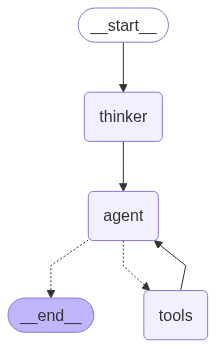

In [ ]:
from IPython.display import Image, display

input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=8, edge_density=0.3)
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
graph_image = solver.graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

#### Result 1:

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=10, edge_density=0.3)

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

Execution Time: 2.68 seconds
A Known Correct Solution: [6, 7, 9, 4, 1, 3, 5, 8, 0, 2]
z3's Found Solution:      [7, 3, 1, 0, 8, 6, 2, 5, 4, 9]


In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [8, 2, 1, 3], "1": [4, 3, 0], "2": [0, 6, 5, 7], "3": [1, 5, 0, 7], "4": [9, 1, 5], "5": [3, 8, 2, 4, 6, 7], "6": [7, 2, 5, 8], "7": [6, 9, 2, 3, 5], "8": [5, 0, 6], "9": [7, 4]}

====================== Step 1: Executing 'messages' Node =======================
================================ Human Message =================================

Please find a Hamiltonian cycle for the graph provided in the system instructions.
====================== Step 2: Executing 'messages' Node =======================
================================== Ai Message ==================================

[0, 2, 5, 3, 1, 4, 9, 7, 6, 8, 0]
====================== Step 3: Executing 'messages' Node =======================
================================== Ai Message ==================================
Tool Calls:
  verify_solution (f791fe24-a73b-4785-9150-5e70adb09276)
 Call ID: f791fe24-a73b-4785-9150-5e70adb09276
  Arg

#### Result 2

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=30, edge_density=0.3)

In [ ]:
z3_solution, z3_solve_time = solve_hamiltonian_cycle_with_z3(input_graph)

if z3_solution is not None:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print(f"A Known Correct Solution: {known_solution}")
    print(f"z3's Found Solution:      {z3_solution}")
else:
    print(f"Execution Time: {z3_solve_time:.2f} seconds")
    print("Z3 could not find a Hamiltonian Cycle.")

Execution Time: 258.78 seconds
Z3 could not find a Hamiltonian Cycle.


In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [12, 27, 3, 9, 10, 13, 14, 15, 16, 17, 18, 19, 20, 24], "1": [2, 5, 6, 14, 16, 21, 24], "2": [18, 1, 8, 9, 11, 12, 17, 22, 26, 27], "3": [23, 9, 0, 8, 15, 16, 18, 19, 20, 24, 25, 26], "4": [17, 16, 5, 6, 11, 13, 14, 18, 19, 23, 24, 28, 29], "5": [1, 7, 4, 6, 13, 18, 22, 24, 28], "6": [16, 21, 1, 4, 5, 10, 14, 24, 25, 27], "7": [5, 19, 8, 21, 28], "8": [26, 10, 2, 3, 7, 11, 15, 20], "9": [3, 28, 0, 2, 14, 15, 16, 18, 19, 22, 26], "10": [8, 22, 0, 6, 11, 16, 19, 20, 25, 28, 29], "11": [22, 25, 2, 4, 8, 10, 12, 17, 24, 27], "12": [14, 0, 2, 11, 13, 21, 23, 27], "13": [24, 26, 0, 4, 5, 12, 22, 23, 27, 28], "14": [19, 12, 0, 1, 4, 6, 9, 18, 28, 29], "15": [17, 28, 0, 3, 8, 9, 16, 21, 22, 25, 27], "16": [4, 6, 0, 1, 3, 9, 10, 15, 19, 25, 26, 28], "17": [15, 4, 0, 2, 11, 21, 23], "18": [20, 2, 0, 3, 4, 5, 9, 14, 23, 25, 28], "19": [7, 14, 0, 3, 4, 9, 10, 16, 29], "20": [21, 18, 0, 3, 8, 10, 22, 28], 

#### Result 3

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=30, edge_density=0.3)

In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [14, 20, 1, 5, 18, 22], "1": [11, 3, 0, 5, 8, 14, 15, 19, 20, 24, 26], "2": [21, 23, 4, 11, 12, 16, 28, 29], "3": [12, 1, 4, 7, 10, 19, 20, 21, 23, 24, 26], "4": [7, 16, 2, 3, 5, 18, 21, 26, 28], "5": [11, 27, 0, 1, 4, 9, 13, 15, 18, 20, 22, 23], "6": [27, 9, 7, 12, 13, 19, 21, 22, 25, 26], "7": [8, 4, 3, 6, 18, 19, 21, 22, 25, 27], "8": [9, 7, 1, 13, 17, 18, 19, 20, 25, 26, 29], "9": [6, 8, 5, 12, 15, 26, 29], "10": [28, 13, 3, 12, 14, 19, 22, 24, 25, 26], "11": [1, 5, 2, 14, 17, 21, 23, 24, 28, 29], "12": [20, 3, 2, 6, 9, 10, 14, 19, 21, 24], "13": [10, 22, 5, 6, 8, 15, 19, 24, 26, 29], "14": [15, 0, 1, 10, 11, 12, 18, 19, 22, 24, 26], "15": [18, 14, 1, 5, 9, 13, 17, 21, 23], "16": [4, 25, 2, 18], "17": [23, 19, 8, 11, 15], "18": [24, 15, 0, 4, 5, 7, 8, 14, 16, 21], "19": [17, 24, 1, 3, 6, 7, 8, 10, 12, 13, 14, 29], "20": [0, 12, 1, 3, 5, 8], "21": [26, 2, 3, 4, 6, 7, 11, 12, 15, 18, 23, 27,

#### Result 4:

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=50, edge_density=0.3)

In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [43, 14, 2, 6, 8, 9, 10, 13, 19, 27, 30, 31, 34, 36, 42, 45, 46, 49], "1": [20, 25, 4, 13, 17, 18, 24, 27, 31, 33, 35, 36, 38, 41, 46], "2": [19, 15, 0, 3, 10, 13, 21, 26, 28, 29, 30, 31, 35, 36, 38], "3": [28, 34, 2, 7, 8, 9, 12, 16, 37, 39, 40, 44], "4": [32, 40, 1, 10, 12, 13, 16, 18, 20, 22, 24, 30, 33, 35, 47, 48], "5": [21, 24, 7, 10, 15, 16, 19, 25, 26, 28, 31, 35, 40, 42, 44, 45, 49], "6": [41, 44, 0, 13, 16, 18, 19, 21, 23, 26, 29, 34, 45], "7": [31, 47, 3, 5, 10, 11, 14, 15, 19, 20, 21, 22, 29, 32, 36, 37, 40, 43, 48], "8": [48, 41, 0, 3, 12, 14, 18, 19, 20, 21, 27, 33, 35, 37, 38, 39, 43, 46], "9": [30, 46, 0, 3, 10, 14, 19, 21, 22, 23, 25, 27, 34, 35, 41, 44, 45, 48], "10": [27, 21, 0, 2, 4, 5, 7, 9, 14, 23, 25, 28, 30, 32, 34, 37, 40, 46, 49], "11": [18, 13, 7, 20, 23, 24, 25, 30, 31, 39, 45, 46, 48], "12": [23, 13, 3, 4, 8, 15, 24, 26, 29, 30, 32, 36, 42, 45, 47], "13": [11, 12, 

#### Result 5

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=75, edge_density=0.3)

In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [19, 74, 11, 14, 15, 17, 25, 29, 31, 33, 34, 36, 38, 39, 49, 52, 60, 61, 63, 65, 67, 71], "1": [50, 24, 2, 9, 12, 20, 21, 23, 29, 31, 36, 49, 53, 54, 56, 58, 61, 62, 64, 69, 70, 72, 73, 74], "2": [18, 36, 1, 4, 8, 11, 12, 15, 16, 19, 20, 22, 29, 30, 33, 37, 40, 41, 42, 44, 46, 49, 50, 51, 57, 60, 61, 62, 67], "3": [29, 43, 4, 11, 14, 19, 21, 22, 27, 32, 35, 36, 38, 48, 49, 60, 61, 67, 68, 70], "4": [49, 8, 2, 3, 6, 17, 18, 32, 36, 40, 41, 44, 45, 53, 59, 62, 64, 67, 68, 71, 72, 74], "5": [53, 56, 6, 8, 10, 14, 16, 17, 18, 25, 27, 28, 29, 31, 32, 33, 35, 46, 58, 60, 61, 63, 69, 72, 74], "6": [34, 29, 4, 5, 10, 16, 21, 24, 37, 42, 46, 50, 51, 54, 56, 57, 58, 61, 62, 65, 68], "7": [30, 39, 10, 13, 14, 16, 19, 22, 25, 35, 36, 37, 38, 41, 42, 43, 44, 47, 48, 55, 60, 61, 62, 67, 68, 69, 70, 71, 72], "8": [4, 53, 2, 5, 10, 13, 14, 15, 18, 23, 30, 35, 37, 39, 47, 48, 54, 60, 64, 65, 66, 69, 71], "9": 

### ReAct Agent 3

#### Model

In [ ]:
import re
import time
import json
import random
from time import sleep
from typing import List, Dict, Any

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from NP_problems import generate_hamiltonian_cycle_graph, verify_hamiltonian_cycle, solve_hamiltonian_cycle_with_z3, visualize_hamiltonian_cycle_graph
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode

def count_broken_edges(graph, path):
    num_vertices = len(graph)
    broken_count = 0
    edges = {node: set(neighbors) for node, neighbors in graph.items()}
    for i in range(num_vertices):
        u = path[i]
        v = path[(i + 1) % num_vertices]
        if v not in edges.get(u, set()):
            broken_count += 1
    return broken_count

def perform_2_opt_swap(path, i, j):
    new_path = path[:i+1]
    segment_to_reverse = path[j:i:-1]
    new_path.extend(segment_to_reverse)
    new_path.extend(path[j+1:])
    return new_path

def solve_with_local_search_repair(graph, hint_path, max_iterations = 10):
    current_path = list(hint_path)
    num_vertices = len(graph)
    best_cost = count_broken_edges(graph, current_path)

    if best_cost == 0:
        return current_path, 0

    for iteration in range(max_iterations):
        improved_in_this_pass = False
        for i in range(num_vertices - 1):
            for j in range(i + 2, num_vertices):

                new_path = perform_2_opt_swap(current_path, i, j)
                new_cost = count_broken_edges(graph, new_path)

                if new_cost < best_cost:
                    current_path = new_path
                    best_cost = new_cost
                    improved_in_this_pass = True
                    if best_cost == 0:
                        return current_path, iteration + 1, True

        if not improved_in_this_pass:
            return current_path, iteration + 1, False

    return current_path, max_iterations, False


class ReactHamiltonCycleSolver:
    def __init__(self, chat_model, input_graph, known_solution):
        self.input_graph = input_graph
        self.known_solution = known_solution
        if known_solution and known_solution[0] != known_solution[-1]:
            self.known_solution.append(known_solution[0])
        self.found_solution = None
        self.execution_time = None
        self.num_vertices = len(input_graph)
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def verify_solution(solution_path_str: str) -> Dict:
            """
            Checks if a proposed path is a valid Hamiltonian cycle for the graph.
            A Hamiltonian cycle must visit every vertex exactly once and return to the starting vertex.

            Args:
                solution_path_str: A JSON string representing a list of vertices, e.g., '[0, 1, 3, 2, 0]'.

            Returns:
                A dictionary indicating if the solution is valid and providing details.
            """
            try:
                path = json.loads(solution_path_str)
            except json.JSONDecodeError:
                return {"is_valid": False, "reason": "Invalid input. Not a valid JSON list."}

            if not isinstance(path, list):
                return {"is_valid": False, "reason": "Input must be a list of nodes."}

            if not path or path[0] != path[-1]:
                return {"is_valid": False, "reason": f"The path is not a cycle. It starts at {path[0]} and ends at {path[-1]}."}

            required_nodes = set(self.input_graph.keys())
            visited_nodes = set(path[:-1])
            if visited_nodes != required_nodes:
                missing = required_nodes - visited_nodes
                extra = visited_nodes - required_nodes
                reason = ""
                if missing:
                  reason += f"The path does not visit all vertices. Missing: {missing}. "
                if extra:
                  reason += f"The path visits invalid vertices: {extra}. "
                if len(path[:-1]) != len(visited_nodes):
                  reason += "The path visits some vertices more than once. "
                return {"is_valid": False, "reason": reason.strip()}

            invalid_edges = []
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if v not in self.input_graph.get(u, []):
                    invalid_edges.append((u, v))
            if invalid_edges:
                return {"is_valid": False, "reason": f"These edges do not exist in the graph: {invalid_edges}."}
            return {"is_valid": True, "reason": "This is a valid Hamiltonian Cycle."}

        @tool
        def repair_path_with_2_opt(hint_path_str: str) -> Dict:
            """
            Attempts to repair an invalid path into a valid Hamiltonian cycle using the 2-opt algorithm.
            Use this tool when 'verify_solution' fails due to non-existent edges, but the path correctly includes all vertices.

            Args:
                hint_path_str: A JSON string of a list of ALL graph vertices, e.g., '[0, 1, 3, 2, 0]'.

            Returns:
                A dictionary with the outcome. On success, returns the repaired path (as a closed cycle). On failure, gives a reason.
            """
            try:
                path = json.loads(hint_path_str)
            except json.JSONDecodeError:
                return {"status": "Error", "reason": f"Invalid input '{hint_path_str}'. Not a valid JSON list."}

            required_nodes = set(self.input_graph.keys())
            if set(path) != required_nodes:
                return {"status": "Error", "reason": "The hint path must contain all graph vertices exactly once."}

            if (path[0] == path[-1]):
                path.pop()

            repaired_path, iterations, status = solve_with_local_search_repair(self.input_graph, path)

            if status:
                repaired_path.append(repaired_path[0])
                return {"status": "SUCCESS", "repaired_path": repaired_path, "iterations_taken": iterations}
            else:
                repaired_path.append(repaired_path[0])
                return {"status": "FAILURE", "reason": f"2-opt algorithm failed after {iterations} iterations."}

        @tool
        def get_neighbors(node: int) -> Dict:
            """
            Returns the list of neighbors for a given node in the graph.
            Args:
                node: The integer representing the node.

            Returns:
                A dictionary containing the node and its neighbors.
            """
            if node not in self.input_graph:
                return {"error": f"Node {node} not in graph."}
            return {"node": node, "neighbors": self.input_graph[node]}

        @tool
        def get_all_nodes() -> Dict:
            """
            Returns a list of all nodes in the graph.

            Returns:
                A dictionary containing the list of all nodes.
            """
            return {"nodes": list(self.input_graph.keys())}

        @tool
        def get_final_answer(solution_path_str: str) -> Dict:
            """
            Formats the final, verified solution and concludes the process.
            Call this tool ONLY when `verify_solution` has returned `is_valid: True`.

            Args:
                solution_path_str: A JSON string of the list representing the final verified Hamiltonian cycle.

            Returns:
                A dictionary containing the final solution.
            """
            try:
                solution = json.loads(solution_path_str)
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_path_str' must be a valid JSON string representing a list. You provided: {solution_path_str}"
                }
            return {"status": "SUCCESS", "final_solution": solution}

        tools = [verify_solution, repair_path_with_2_opt, get_neighbors, get_all_nodes, get_final_answer]
        return tools

    def _thinker_node(self, state: MessagesState) -> MessagesState:
        system_content = (
            f"You are a Hamiltonian Cycle problem solver. Your task is to propose an initial path for the following graph:\n"
            f"Graph (Adjacency List): {json.dumps(self.input_graph)}\n\n"
            "A Hamiltonian cycle visits every vertex exactly once.\n"
            # "Provide a quick, simple guess for a path. A good first guess is to simply list all the vertices in numerical order. "
            "Do not perform too much complex analysis. The next step will repair your guess if it's wrong.\n"
            "Think enough and try your best to give the correct cycle for the problem. Your solution must almost correct."
            "providing a answer is more important. so try to give a solution in any matter."
            "Your output must be only the proposed complete Hamiltonian cycle as a list of vertices, starting and ending at the same vertex."
        )
        sys_msg = SystemMessage(content=system_content)
        human_msg = state["messages"][0]
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        system_content = (
            "You are a diligent assistant that finds a Hamiltonian Cycle using a powerful repair tool.\n"
            f"The graph is: {json.dumps(self.input_graph)}\n"
            f"Your goal is to find a valid Hamiltonian Cycle, visiting all {self.num_vertices} vertices exactly once in a closed loop.\n\n"
            "**Your Workflow:**\n"
            "1. **Verify Initial Path**: You'll receive a proposed path. Immediately use the `verify_solution` tool on it.\n"
            "2. **If Correct**: Great! Call `get_final_answer` with the verified path to finish.\n"
            "3. **If Incorrect**: Analyze the reason from `verify_solution`.\n"
            "   - If the path has **non-existent edges** but includes all vertices, use the `repair_path_with_2_opt` tool. For its `hint_path_str` argument.\n"
            "   - After getting a `repaired_path` from the tool, you MUST verify it again with `verify_solution`.\n"
            "   - If the path is wrong for other reasons (e.g., missing nodes), you can try to fix it manually.\n"
            "4. **Iterate**: Always verify any new path before submitting it as the final answer. A solution is guaranteed to exist."
        )
        react_system_prompt = SystemMessage(content=system_content)
        new_message = self.model_with_tools.invoke([react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        # if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        #     return END
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)
        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")
        return builder.compile()

    def solve(self, verbose = True):
        user_prompt = f"Please find a Hamiltonian cycle for the graph provided in the system instructions."
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_message = " Solving Hamiltonian Cycle Problem "
            bold_initial_message = f"\033[1m{initial_message}\033[0m"
            print(f"{bold_initial_message:#^88}")
            # print(f"\033[1m{' Solving Hamiltonian Cycle Problem ':#^88}\033[0m")
            print(f"Graph: {json.dumps(self.input_graph)}\n")

        final_state = None
        start_time = time.time()
        for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
            if verbose:
                node_name = list(chunk.keys())[0]
                step = f" Step {i+1}: Executing '{node_name}' Node "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                # print(f"\033[1m{f' Step {i+1}: Executing `{node_name}` Node ':=^88}\033[0m")
                chunk["messages"][-1].pretty_print()
            final_state = chunk
        end_time = time.time()
        self.execution_time = end_time - start_time

        if verbose:
            step = f" Final Result "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")
            # print(f"\033[1m{' Final Result ':=^88}\033[0m")

        last_message = final_state["messages"][-1]
        # if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            if tool_call['name'] == 'get_final_answer':
                args = tool_call['args']
                if 'solution_path_str' in args:
                    try:
                        self.found_solution = json.loads(args['solution_path_str'])
                        is_correct = verify_hamiltonian_cycle(self.input_graph, self.found_solution)
                        if verbose:
                            print(f"Input Graph: {json.dumps(self.input_graph)}")
                            print(f"Execution Time: {self.execution_time:.2f} seconds")
                            print(f"A Known Correct Solution: {self.known_solution}")
                            print(f"Agent's Found Solution:   {self.found_solution}")
                            if is_correct:
                                print("\n\033[92m\033[1mFound Solution Is Correct\033[0m")
                            else:
                                print("\n\033[91m\033[1mFound Solution Is Incorrect\033[0m")
                        return self.found_solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        if verbose:
            print("\033[91m\033[1mCould not find a valid solution.\033[0m")
        return None, self.execution_time

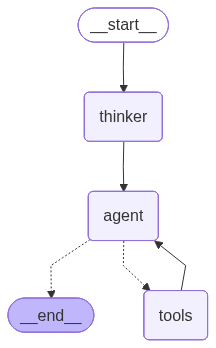

In [ ]:
from IPython.display import Image, display

input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=8, edge_density=0.3)
solver = ReactHamiltonCycleSolver(chat_model=chat_model_gpt, input_graph=input_graph, known_solution=known_solution)
graph_image = solver.graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

#### Result 1

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=20, edge_density=0.3)

In [ ]:
# 0.03$ 💸🤯
# Its not fair 😭😭

solver = ReactHamiltonCycleSolver(chat_model=chat_model_gpt, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [12, 14, 4, 7, 10, 11, 13, 17, 18, 19], "1": [9, 18, 5, 6, 12, 14], "2": [6, 4, 5, 8], "3": [4, 10, 8, 13, 16, 17], "4": [2, 3, 0, 5, 7, 9, 17, 19], "5": [13, 7, 1, 2, 4, 15, 17], "6": [15, 2, 1, 9, 11, 14, 17], "7": [5, 8, 0, 4, 10], "8": [7, 19, 2, 3, 14, 15, 16, 17], "9": [11, 1, 4, 6, 10, 12, 14], "10": [3, 16, 0, 7, 9, 13, 17, 18], "11": [16, 9, 0, 6, 12, 14, 18], "12": [19, 0, 1, 9, 11, 14, 17], "13": [17, 5, 0, 3, 10, 14, 19], "14": [0, 15, 1, 6, 8, 9, 11, 12, 13, 18, 19], "15": [6, 14, 5, 8, 16, 17, 18, 19], "16": [10, 11, 3, 8, 15, 19], "17": [18, 13, 0, 3, 4, 5, 6, 8, 10, 12, 15], "18": [1, 17, 0, 10, 11, 14, 15], "19": [8, 12, 0, 4, 13, 14, 15, 16]}

====================== Step 1: Executing 'messages' Node =======================
================================ Human Message =================================

Please find a Hamiltonian cycle for the graph provided in the system inst

#### Result 2

In [ ]:
# 0.06$ 💸🤯
# Its not fair 😭😭

input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=40, edge_density=0.3)

In [ ]:
solver = ReactHamiltonCycleSolver(chat_model=chat_model_gpt, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [4, 9, 6, 8, 14, 16, 19, 21, 26, 27, 30, 37], "1": [16, 30, 4, 6, 7, 10, 12, 14, 15, 24, 27, 28, 31, 33, 35], "2": [9, 26, 3, 4, 12, 19, 20, 23, 27, 28, 29, 30, 32, 34], "3": [21, 24, 2, 4, 8, 11, 13, 14, 17, 19, 27, 28, 31, 36, 37], "4": [38, 0, 1, 2, 3, 6, 9, 15, 16, 17, 18, 19, 24, 26, 27, 28, 30, 31, 33, 35, 39], "5": [20, 33, 6, 8, 9, 10, 13, 15, 16, 18, 21, 27, 29, 32], "6": [24, 17, 0, 1, 4, 5, 7, 9, 12, 13, 15, 23, 25, 30, 33, 36], "7": [37, 21, 1, 6, 9, 13, 22, 30], "8": [28, 15, 0, 3, 5, 12, 13, 14, 16, 17, 19, 22, 23, 31, 35, 37], "9": [0, 2, 4, 5, 6, 7, 12, 14, 15, 17, 23, 27, 29, 39], "10": [22, 13, 1, 5, 15, 21, 25, 31, 38, 39], "11": [30, 27, 3, 16, 22, 23, 29, 31, 35, 39], "12": [29, 16, 1, 2, 6, 8, 9, 18, 19, 23, 25, 27, 32, 36, 37, 38], "13": [10, 29, 3, 5, 6, 7, 8, 16, 18, 33, 35, 36, 39], "14": [17, 36, 0, 1, 3, 8, 9, 15, 18, 19, 22, 29, 30, 35, 39], "15": [8, 38, 1, 4, 5, 

#### Result 3

In [ ]:
input_graph, known_solution = generate_hamiltonian_cycle_graph(num_vertices=100, edge_density=0.3)

In [ ]:
# 0.1$ 💸🤯
# Its not fair 😭😭

solver = ReactHamiltonCycleSolver(chat_model=chat_model_gpt, input_graph=input_graph, known_solution=known_solution)
agent_solution, agent_solve_time = solver.solve()

###################### Solving Hamiltonian Cycle Problem #######################
Graph: {"0": [42, 1, 2, 6, 13, 14, 18, 21, 22, 27, 30, 32, 38, 40, 46, 56, 57, 62, 64, 66, 68, 70, 71, 74, 75, 77, 78, 79, 80, 88, 89, 92, 98], "1": [0, 97, 4, 18, 20, 22, 30, 34, 38, 42, 43, 44, 46, 49, 51, 54, 59, 65, 73, 81, 82, 84, 86, 88, 90, 93, 94, 96, 99], "2": [75, 78, 0, 3, 4, 7, 14, 16, 17, 20, 23, 24, 27, 28, 33, 35, 37, 41, 49, 55, 58, 66, 84, 93, 94, 95], "3": [33, 38, 2, 4, 10, 11, 13, 14, 23, 30, 34, 45, 46, 50, 51, 52, 59, 60, 63, 69, 71, 72, 74, 75, 76, 78, 79, 85, 93, 95, 97], "4": [58, 73, 1, 2, 3, 6, 8, 17, 18, 19, 20, 21, 26, 31, 33, 35, 44, 45, 47, 51, 59, 61, 74, 78, 80, 81, 89, 96], "5": [14, 37, 10, 12, 17, 19, 21, 23, 25, 27, 28, 30, 32, 34, 40, 42, 44, 51, 60, 62, 68, 69, 70, 78, 85, 86, 91, 92, 99], "6": [77, 31, 0, 4, 11, 12, 14, 15, 16, 17, 18, 19, 21, 24, 28, 33, 38, 44, 46, 48, 54, 55, 56, 66, 68, 73, 79, 85, 86, 88, 89, 98], "7": [10, 76, 2, 11, 12, 13, 17, 30, 36, 37, 43,

## Hamilton Path

### ReAct Agent 1

In [ ]:
import os
import torch
from google.colab import drive
from unsloth import FastLanguageModel

drive.mount("/content/drive/")

max_prompt_length = 10296
max_completion_length = 131
max_seq_length = max_prompt_length+max_completion_length
load_in_4bit = True
dtype = None

def load_model_tokenizer(path):
  return FastLanguageModel.from_pretrained(
      path,
      max_seq_length = max_seq_length,
      dtype = dtype,
      load_in_4bit = load_in_4bit,
      # fast_inference = True,
  )

path = "/content/drive/MyDrive/sft-2-llama-instruct/"
model, tokenizer = load_model_tokenizer(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
==((====))==  Unsloth 2025.8.1: Fast Llama patching. Transformers: 4.54.1. vLLM: 0.8.5.post1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.8.1 patched 28 layers with 28 QKV layers, 0 O layers and 0 MLP layers.


In [ ]:
from NP_problems import generate_hamiltonian_path_graph, verify_hamiltonian_path, solve_hamiltonian_path_with_z3, visualize_hamiltonian_path_graph
import re

def format_graph_problem_for_llm_base(generated_graph):
    # prompt = (f"Graph:\n")
    prompt = ""
    for vertex, neighbors in sorted(generated_graph.items()):
        prompt += f"{vertex:03d}:"
        for neighbor in sorted(neighbors):
            prompt += f"{neighbor:03d}"
        prompt += "\n"

    return prompt

def create_ham_path_prompt_base(formatted_problem_str):
    system_content = (
        "You are an expert in graph theory specializing in Hamiltonian "
        "Path Problem. You will receive an undirected graph where "
        "each line contains adjacent vertices for a vertex. Your task "
        "is to return a path that visits every vertex exactly once. "
        "You must provide the sequence of vertices and no additional text.\n"
    )
    human_content = f"Graph:\n{formatted_problem_str}\nHamiltonian Path:\n"

    return system_content, human_content

def create_test_example(num_vertices, edge_density, tokenizer):
    generated_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=num_vertices, edge_density = edge_density)
    # generated_graph = {key: sorted(value) for key, value in generated_graph.items()}
    generated_graph_str = format_graph_problem_for_llm_base(generated_graph)
    system_message, human_message = create_ham_path_prompt_base(generated_graph_str)
    conversation = [
        {"role": "system", "content": system_message },
        {"role": "user", "content": human_message },
        # {"role": "assistant", "content": ""}
    ]
    llm_input = tokenizer.apply_chat_template(conversation, tokenize = False, add_generation_prompt = True)
    return generated_graph, known_solution, llm_input


def get_llm_output(model, tokenizer, llm_input, max_new_tokens=256):
    inputs = tokenizer([llm_input], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        pad_token_id=tokenizer.eos_token_id
    )

    input_length = inputs.input_ids.shape[1]
    decoded_output = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)

    return decoded_output.strip()

def extract_path_from_output(llm_output):
    pattern = re.compile(r"\d\d\d", re.IGNORECASE)
    subset = pattern.findall(llm_output.strip())
    return [int(number) for number in subset]

In [ ]:
graph, solution, prompt = create_test_example(16, 0.6, tokenizer)
print("Graph:")
for key, value in graph.items():
  print(f"{key}: {value}")
print("="*100)

print(f"Prompt: {prompt}")
print("="*100)

llm_raw_output = get_llm_output(model, tokenizer, prompt)
print(f"LLM Raw Output: {llm_raw_output}")
print("="*100)

llm_path = extract_path_from_output(llm_raw_output)
print(f"LLM Path: {llm_path}")
print("="*100)

print(verify_hamiltonian_path(llm_path, graph))

Graph:
0: [14, 12, 3, 6, 8, 9, 11, 13]
1: [6, 9, 2, 3, 4, 5, 7, 11, 12, 13, 15]
2: [15, 1, 3, 4, 7, 10, 11]
3: [7, 8, 0, 1, 2, 4, 10, 12, 14, 15]
4: [5, 14, 1, 2, 3, 8, 9, 10, 12, 15]
5: [9, 4, 1, 7, 8, 10, 12, 13, 14, 15]
6: [13, 1, 0, 7, 8, 10, 11, 12]
7: [10, 3, 1, 2, 5, 6, 8, 11, 13]
8: [3, 0, 4, 5, 6, 7, 14, 15]
9: [1, 5, 0, 4, 12, 13, 14, 15]
10: [12, 7, 2, 3, 4, 5, 6, 11, 13, 14, 15]
11: [15, 13, 0, 1, 2, 6, 7, 10, 12]
12: [0, 10, 1, 3, 4, 5, 6, 9, 11]
13: [11, 6, 0, 1, 5, 7, 9, 10, 14, 15]
14: [4, 0, 3, 5, 8, 9, 10, 13]
15: [2, 11, 1, 3, 4, 5, 8, 9, 10, 13]
Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 06 Aug 2025

You are an expert in graph theory specializing in Hamiltonian Path Problem. You will receive an undirected graph where each line contains adjacent vertices for a vertex. Your task is to return a path that visits every vertex exactly once. You must provide the sequence of vertices and no addition

In [ ]:
import re
import time
import json
import random
from time import sleep
from langchain_core.tools import tool
from typing import List, Dict, Set, Any
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from NP_problems import generate_hamiltonian_cycle_graph, verify_hamiltonian_cycle, solve_hamiltonian_cycle_with_z3, visualize_hamiltonian_cycle_graph
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState


class ReactHamiltonCycleSolver:
    def __init__(self, chat_model: Any, input_graph: Dict[int, List[int]], known_solution: List[int]):
        self.input_graph = input_graph
        self.known_solution = known_solution
        self.known_solution.append(known_solution[0])
        self.found_solution = None
        self.execution_time = None
        self.num_vertices = len(input_graph)
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def verify_solution(solution_path_str: str) -> Dict:
            """
            Checks if a proposed path is a valid Hamiltonian cycle for the graph.
            A Hamiltonian cycle must visit every vertex exactly once and return to the starting vertex.

            Args:
                solution_path_str: A JSON string representing a list of vertices, e.g., '[0, 1, 3, 2, 0]'.

            Returns:
                A dictionary indicating if the solution is valid and providing details.
            """
            try:
                path = json.loads(solution_path_str)
            except json.JSONDecodeError:
                return {"is_valid": False, "reason": f"Invalid input. Not a valid JSON list."}

            if not isinstance(path, list):
                 return {"is_valid": False, "reason": f"Input must be a list of nodes."}

            if path[0] != path[-1]:
                return {"is_valid": False, "reason": f"The path is not a cycle. It starts at {path[0]} and ends at {path[-1]}."}

            required_nodes = set(self.input_graph.keys())
            visited_nodes = set(path[:-1])
            if visited_nodes != required_nodes:
                missing = required_nodes - visited_nodes
                extra = visited_nodes - required_nodes
                reason = ""
                if missing:
                    reason += f"The path does not visit all vertices. Missing: {missing}. "
                if extra:
                    reason += f"The path visits invalid vertices: {extra}. "
                if len(path[:-1]) != len(visited_nodes):
                    reason += "The path visits some vertices more than once. "
                return {"is_valid": False, "reason": reason.strip()}

            invalid_edges = []
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if v not in self.input_graph.get(u, []):
                    invalid_edges.append((u, v))
                    # return {"is_valid": False, "reason": f"The edge ({u}, {v}) does not exist in the graph."}

            if invalid_edges:
                return {"is_valid": False, "reason": f"these edges do not exist in the graph: {invalid_edges}."}

            return {"is_valid": True, "reason": "This is a valid Hamiltonian Cycle."}

        @tool
        def get_neighbors(node: int) -> Dict:
            """
            Returns the list of neighbors for a given node in the graph.
            Args:
                node: The integer representing the node.

            Returns:
                A dictionary containing the node and its neighbors.
            """
            if node not in self.input_graph:
                return {"error": f"Node {node} not in graph."}
            return {"node": node, "neighbors": self.input_graph[node]}

        @tool
        def get_all_nodes() -> Dict:
            """
            Returns a list of all nodes in the graph.

            Returns:
                A dictionary containing the list of all nodes.
            """
            return {"nodes": list(self.input_graph.keys())}

        @tool
        def get_final_answer(solution_path_str: str) -> Dict:
            """
            Formats the final, verified solution and concludes the process.
            Call this tool ONLY when `verify_solution` has returned `is_valid: True`.

            Args:
                solution_path_str: A JSON string of the list representing the final verified Hamiltonian cycle.

            Returns:
                A dictionary containing the final solution.
            """
            try:
                solution = json.loads(solution_path_str)
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_path_str' must be a valid JSON string representing a list. You provided: {solution_path_str}"
                }
            return {"status": "SUCCESS", "final_solution": solution}

        tools = [verify_solution, get_neighbors, get_all_nodes, get_final_answer]
        return tools

    def _thinker_node(self, state: MessagesState) -> MessagesState:
        system_content = (
            f"You are a graph theory expert. Your task is to find a Hamiltonian cycle in the following undirected graph:\n"
            f"Graph (Adjacency List): {json.dumps(self.input_graph)}\n\n"
            "A Hamiltonian cycle is a closed loop that visits every vertex in the graph exactly once.\n"
            "Analyze the graph, consider the degrees of the vertices, and try to construct a path step-by-step. "
            "A good heuristic is to start with a node of a low degree.\n"
            "Provide your detailed thought process and then state your proposed complete Hamiltonian cycle as a list of vertices, "
            "starting and ending at the same vertex. Your output should be just your reasoning and the proposed path."
        )
        sys_msg = SystemMessage(content=system_content)
        human_msg = state['messages'][0]
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        system_content = (
            "You are a diligent assistant that verifies and corrects a proposed solution for the Hamiltonian Cycle problem.\n"
            f"The graph is: {json.dumps(self.input_graph)}\n"
            f"Your goal is to find a valid Hamiltonian Cycle, which visits every one of the {self.num_vertices} vertices exactly once and forms a closed loop.\n\n"
            "Follow these steps:\n"
            "1. **Analyze the proposed path** provided in the previous step.\n"
            "2. **Verify the path**: Use the `verify_solution` tool to check its validity.\n"
            "3. **If Correct**: Call `get_final_answer` with the verified path to finish.\n"
            "4. **If Incorrect**: The `verify_solution` tool will explain why. Use other tools like `get_neighbors` and `get_all_nodes` to understand the graph's structure. Reason about the error and construct a NEW, corrected path. Then, go back to step 2 to verify your new path.\n"
            "5. **Iterate**: Continue this cycle of proposing a new path and verifying it until a valid solution is found. A solution is guaranteed to exist."
        )
        react_system_prompt = SystemMessage(content=system_content)
        new_message = self.model_with_tools.invoke([react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)

        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")

        return builder.compile()

    def solve(self, verbose = True):
        user_prompt = f"Please find a Hamiltonian cycle for the graph provided in the system instructions."
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_message = " Solving Hamiltonian Cycle Problem "
            bold_initial_message = f"\033[1m{initial_message}\033[0m"
            print(f"{bold_initial_message:#^88}")
            print(f"Graph: {json.dumps(self.input_graph)}\n")

        final_state = None
        start_time = time.time()
        for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
            if verbose:
                node_name = list(chunk.keys())[0]
                step = f" Step {i+1}: Executing '{node_name}' Node "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                chunk["messages"][-1].pretty_print()
            final_state = chunk
        end_time = time.time()
        self.execution_time = end_time - start_time

        if verbose:
            step = f" Final Result "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            if tool_call['name'] == 'get_final_answer':
                args = tool_call['args']
                if 'solution_path_str' in args:
                    try:
                        self.found_solution = json.loads(args['solution_path_str'])
                        is_correct = verify_hamiltonian_cycle(self.input_graph, self.found_solution)
                        if (verbose):
                            print(f"Input Graph: {json.dumps(self.input_graph)}")
                            print(f"Execution Time: {self.execution_time:.2f} seconds")
                            print(f"A Known Correct Solution: {self.known_solution}")
                            print(f"Agent's Found Solution:   {self.found_solution}")
                            if (is_correct):
                                print("\n\033[92m\033[1mFound Solution Is Correct\033[0m")
                            if (not is_correct):
                                print("\n\033[91m\033[1mFound Solution Is Incorrect\033[0m")
                        return self.found_solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        if (verbose):
            print("\033[91m\033[1mCould not find a solution.\033[0m")
        return None, self.execution_time

### ReAct Agent 2

#### Model

In [ ]:
import re
from unsloth import FastLanguageModel
from NP_problems import generate_hamiltonian_path_graph, verify_hamiltonian_path, solve_hamiltonian_path_with_z3, visualize_hamiltonian_path_graph

max_prompt_length = 10296
max_completion_length = 131
max_seq_length = max_prompt_length+max_completion_length
load_in_4bit = True
dtype = None

def load_model_tokenizer(path):
    print(f"Loading model from: {path}")
    model, tokenizer = FastLanguageModel.from_pretrained(
        path,
        max_seq_length=max_seq_length,
        dtype=dtype,
        load_in_4bit=load_in_4bit,
        # fast_inference = True,
    )
    return model, tokenizer

def format_graph_problem_for_llm_base(generated_graph):
    prompt = ""
    for vertex, neighbors in sorted(generated_graph.items()):
        prompt += f"{vertex:03d}:"
        for neighbor in sorted(neighbors):
            prompt += f"{neighbor:03d}"
        prompt += "\n"
    return prompt

def create_ham_path_prompt_base(formatted_problem_str):
    system_content = (
        "You are an expert in graph theory specializing in Hamiltonian "
        "Path Problem. You will receive an undirected graph where "
        "each line contains adjacent vertices for a vertex. Your task "
        "is to return a path that visits every vertex exactly once. "
        "You must provide the sequence of vertices and no additional text.\n"
    )
    human_content = f"Graph:\n{formatted_problem_str}\nHamiltonian Path:\n"
    return system_content, human_content

def get_llm_output(model, tokenizer, llm_input, max_new_tokens = 256):
    inputs = tokenizer([llm_input], return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        pad_token_id=tokenizer.eos_token_id
    )
    input_length = inputs.input_ids.shape[1]
    decoded_output = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)
    return decoded_output.strip()

def extract_path_from_output(llm_output):
    pattern = re.compile(r"\d\d\d", re.IGNORECASE)
    subset = pattern.findall(llm_output.strip())
    return [int(number) for number in subset]

def create_test_example(num_vertices, edge_density, tokenizer):
    generated_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=num_vertices, edge_density = edge_density)
    # generated_graph = {key: sorted(value) for key, value in generated_graph.items()}
    generated_graph_str = format_graph_problem_for_llm_base(generated_graph)
    system_message, human_message = create_ham_path_prompt_base(generated_graph_str)
    conversation = [
        {"role": "system", "content": system_message },
        {"role": "user", "content": human_message },
        # {"role": "assistant", "content": ""}
    ]
    llm_input = tokenizer.apply_chat_template(conversation, tokenize = False, add_generation_prompt = True)
    return generated_graph, known_solution, llm_input

In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
path = "/content/drive/MyDrive/LLM_NP_Problems/models/sft-2-llama-instruct/"
model, tokenizer = load_model_tokenizer(path)

Loading model from: /content/drive/MyDrive/LLM_NP_Problems/models/sft-2-llama-instruct/


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.8: Fast Llama patching. Transformers: 4.55.2. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.8.8 patched 28 layers with 28 QKV layers, 0 O layers and 0 MLP layers.


In [ ]:
graph, solution, prompt = create_test_example(16, 0.6, tokenizer)
print("Graph:")
for key, value in graph.items():
  print(f"{key}: {value}")
print("="*100)

print(f"Prompt: {prompt}")
print("="*100)

llm_raw_output = get_llm_output(model, tokenizer, prompt)
print(f"LLM Raw Output: {llm_raw_output}")
print("="*100)

llm_path = extract_path_from_output(llm_raw_output)
print(f"LLM Path: {llm_path}")
print("="*100)

print(verify_hamiltonian_path(llm_path, graph))

Graph:
0: [1, 3, 2, 4, 5, 6, 7, 8, 9, 14]
1: [8, 0, 2, 3, 4, 6, 7, 11, 12, 13, 14]
2: [4, 11, 0, 1, 5, 6, 9, 10, 13, 14, 15]
3: [0, 9, 1, 5, 6, 7, 8, 11, 12, 14, 15]
4: [12, 2, 0, 1, 6, 8, 9, 10, 14, 15]
5: [13, 15, 0, 2, 3, 6, 7, 8, 10, 12, 14]
6: [14, 0, 1, 2, 3, 4, 5, 8, 9, 10, 15]
7: [11, 13, 0, 1, 3, 5, 9, 10, 15]
8: [1, 0, 3, 4, 5, 6, 9, 10, 11, 13, 15]
9: [3, 12, 0, 2, 4, 6, 7, 8, 10, 11, 13, 15]
10: [15, 14, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13]
11: [2, 7, 1, 3, 8, 9, 10, 14, 15]
12: [9, 4, 1, 3, 5, 10, 14, 15]
13: [7, 5, 1, 2, 8, 9, 10, 15]
14: [10, 6, 0, 1, 2, 3, 4, 5, 11, 12, 15]
15: [5, 10, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14]
Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 03 Sep 2025

You are an expert in graph theory specializing in Hamiltonian Path Problem. You will receive an undirected graph where each line contains adjacent vertices for a vertex. Your task is to return a path that visits every vertex e

In [ ]:
import re
import time
import json
import torch
from time import sleep
from typing import List, Dict, Any

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode

from NP_problems import generate_hamiltonian_path_graph, verify_hamiltonian_path

def count_broken_edges_path(graph, path):
    broken_count = 0
    edges = {node: set(neighbors) for node, neighbors in graph.items()}
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i+1]
        if v not in edges.get(u, set()):
            broken_count += 1
    return broken_count

def perform_2_opt_swap(path, i, j):
    new_path = path[:i+1]
    segment_to_reverse = path[j:i:-1]
    new_path.extend(segment_to_reverse)
    new_path.extend(path[j+1:])
    return new_path

def solve_with_local_search_repair_path(graph, hint_path, max_iterations = 10):
    current_path = list(hint_path)
    num_vertices = len(graph)
    best_cost = count_broken_edges_path(graph, current_path)

    if best_cost == 0:
        return current_path, 0, True

    for iteration in range(max_iterations):
        improved_in_this_pass = False
        for i in range(num_vertices - 2):
            for j in range(i + 2, num_vertices):
                new_path = perform_2_opt_swap(current_path, i, j)
                new_cost = count_broken_edges_path(graph, new_path)

                if new_cost < best_cost:
                    current_path = new_path
                    best_cost = new_cost
                    improved_in_this_pass = True
                    if best_cost == 0:
                        return current_path, iteration + 1, True

        if not improved_in_this_pass:
            return current_path, iteration + 1, False

    return current_path, max_iterations, False


class ReactHamiltonianPathSolver:
    def __init__(self, chat_model, ft_model, ft_tokenizer, input_graph, known_solution):
        self.input_graph = input_graph
        self.known_solution = known_solution
        self.found_solution = None
        self.execution_time = None
        self.num_vertices = len(input_graph)

        self.ft_model = ft_model
        self.ft_tokenizer = ft_tokenizer

        self.tools = self._set_up_tools()
        self.chat_model = chat_model
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def verify_path(solution_path_str: str) -> Dict:
            """
            Checks if a proposed path is a valid Hamiltonian path for the graph.
            A Hamiltonian path must visit every vertex exactly once.

            Args:
                solution_path_str: A JSON string representing a list of vertices, e.g., '[0, 1, 3, 2]'.

            Returns:
                A dictionary indicating if the solution is valid and providing details.
            """
            try:
                path = json.loads(solution_path_str)
            except json.JSONDecodeError:
                return {"is_valid": False, "reason": "Invalid input. Not a valid JSON list."}

            required_nodes = set(self.input_graph.keys())
            visited_nodes = set(path)

            if len(path) != len(visited_nodes):
                return {"is_valid": False, "reason": "The path visits some vertices more than once."}

            if visited_nodes != required_nodes:
                missing = required_nodes - visited_nodes
                extra = visited_nodes - required_nodes
                reason = f"Path must visit all {self.num_vertices} vertices exactly once. "
                if missing: reason += f"Missing: {missing}. "
                if extra: reason += f"Extra: {extra}."
                return {"is_valid": False, "reason": reason.strip()}

            invalid_edges = []
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if v not in self.input_graph.get(u, []):
                    invalid_edges.append((u, v))
            if invalid_edges:
                return {"is_valid": False, "reason": f"These edges do not exist in the graph: {invalid_edges}."}

            return {"is_valid": True, "reason": "This is a valid Hamiltonian Path."}

        @tool
        def repair_path_with_2_opt(hint_path_str: str) -> Dict:
            """
            Attempts to repair an invalid path into a valid Hamiltonian path using the 2-opt algorithm.
            Use this tool when 'verify_path' fails due to non-existent edges, but the path correctly includes all vertices.

            Args:
                hint_path_str: A JSON string of a list of ALL graph vertices, e.g., '[0, 1, 3, 2]'.

            Returns:
                A dictionary with the outcome. On success, returns the repaired path. On failure, gives a reason.
            """
            try:
                path = json.loads(hint_path_str)
            except json.JSONDecodeError:
                return {"status": "Error", "reason": f"Invalid input '{hint_path_str}'. Not a valid JSON list."}

            required_nodes = set(self.input_graph.keys())
            if set(path) != required_nodes:
                return {"status": "Error", "reason": "The hint path must contain all graph vertices exactly once."}

            repaired_path, iterations, status = solve_with_local_search_repair_path(self.input_graph, path)

            if status:
                return {"status": "SUCCESS", "repaired_path": repaired_path, "iterations_taken": iterations}
            else:
                return {"status": "FAILURE", "reason": f"2-opt algorithm failed after {iterations} iterations. Give a different Hint. This Hint was bad."}

        @tool
        def get_final_answer(solution_path_str: str) -> Dict:
            """
            Formats the final, verified solution and concludes the process.
            Call this tool ONLY when `verify_path` has returned `is_valid: True`.

            Args:
                solution_path_str: A JSON string of the list representing the final verified Hamiltonian path.

            Returns:
                A dictionary containing the final solution.
            """
            try:
                solution = json.loads(solution_path_str)
            except (json.JSONDecodeError, TypeError):
                return {"status": "Error", "details": "Invalid input. Must be a valid JSON string of a list."}
            return {"status": "SUCCESS", "final_solution": solution}

        return [verify_path, repair_path_with_2_opt, get_final_answer]

    def _initial_solver_node(self, state: MessagesState) -> MessagesState:
        print("Generating initial path with fine-tuned LLM...")
        graph_str = format_graph_problem_for_llm_base(self.input_graph)
        system_msg, human_msg = create_ham_path_prompt_base(graph_str)
        conversation = [{"role": "system", "content": system_msg}, {"role": "user", "content": human_msg}]
        llm_input = self.ft_tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

        raw_output = get_llm_output(self.ft_model, self.ft_tokenizer, llm_input)

        initial_path = extract_path_from_output(raw_output)

        print(f"Fine-tuned LLM raw output: '{raw_output}'")
        print(f"Parsed initial path: {initial_path}")

        ai_message = AIMessage(content=f"The fine-tuned model proposed the following initial path: {json.dumps(initial_path)}. I will now verify it.")
        return {"messages": [ai_message]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        system_content = (
            "You are a diligent assistant that finds a Hamiltonian Path using powerful tools.\n"
            f"The graph is: {json.dumps(self.input_graph)}\n"
            f"Your goal is to find a valid Hamiltonian Path, visiting all {self.num_vertices} vertices exactly once.\n\n"
            "**Your Workflow:**\n"
            "1. **Verify Initial Path**: You'll receive a proposed path. Immediately use the `verify_path` tool on it.\n"
            "2. **If Correct**: Great! Call `get_final_answer` with the verified path to finish.\n"
            "3. **If Incorrect**: Analyze the reason from `verify_path`.\n"
            "   - If the path has **non-existent edges** but includes all vertices, use the `repair_path_with_2_opt` tool.\n"
            "   - After getting a `repaired_path` from the tool, you MUST verify it again with `verify_path`.\n"
            "4. **Iterate**: Always verify any new path. A solution is guaranteed to exist."
        )
        react_system_prompt = SystemMessage(content=system_content)
        new_message = self.model_with_tools.invoke([react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)
        builder.add_node("initial_solver", self._initial_solver_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "initial_solver")
        builder.add_edge("initial_solver", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")
        return builder.compile()

    def solve(self, verbose = True):
        initial_messages = {"messages": [HumanMessage(content="Start the process.")]}
        if verbose:
            print(f"\033[1m{' Solving Hamiltonian Path Problem ':#^88}\033[0m")
            print(f"Graph: {json.dumps(self.input_graph)}\n")

        final_state = None
        try:
            start_time = time.time()
            for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
                if verbose:
                    node_name = list(chunk.keys())[0]
                    print(f"\033[1m{f' Step {i+1}: Executing `{node_name}` Node ':=^88}\033[0m")
                    chunk["messages"][-1].pretty_print()
                final_state = chunk
            end_time = time.time()
            self.execution_time = end_time - start_time

        except Exception as e:
            end_time = time.time()
            self.execution_time = end_time - start_time
            if verbose:
                print(f"\n\033[1m{' An Unexpected Error Occurred ':#^88}\033[0m")
                print(f"\033[91m\033[1mError during execution: {type(e).__name__} - {e}\033[0m")
                print("\033[91m\033[1mCould not find a valid solution.\033[0m")
            return None, self.execution_time

        if verbose:
            print(f"\033[1m{' Final Result ':=^88}\033[0m")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            if tool_call['name'] == 'get_final_answer':
                args = tool_call['args']
                if 'solution_path_str' in args:
                    try:
                        self.found_solution = json.loads(args['solution_path_str'])
                        is_correct = verify_hamiltonian_path(self.found_solution, self.input_graph)
                        if verbose:
                            print(f"Input Graph: {json.dumps(self.input_graph)}")
                            print(f"Execution Time: {self.execution_time:.2f} seconds")
                            print(f"A Known Correct Solution: {self.known_solution}")
                            print(f"Agent's Found Solution:   {self.found_solution}")
                            if is_correct:
                                print("\n\033[92m\033[1mFound Solution Is Correct\033[0m")
                            else:
                                print("\n\033[91m\033[1mFound Solution Is Incorrect\033[0m")
                        return self.found_solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        if verbose:
            print("\033[91m\033[1mCould not find a valid solution.\033[0m")
        return None, self.execution_time



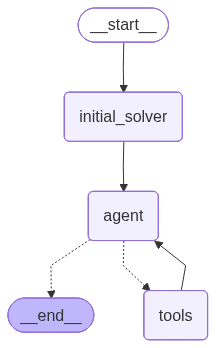

In [ ]:
from IPython.display import Image, display

ft_model, ft_tokenizer = model, tokenizer
input_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=10, edge_density=0.5)

solver = ReactHamiltonianPathSolver(
    chat_model=chat_model,
    ft_model=ft_model,
    ft_tokenizer=ft_tokenizer,
    input_graph=input_graph,
    known_solution=known_solution
)

graph_image = solver.graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

#### Result 1

In [ ]:
input_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=10, edge_density=0.5)

In [ ]:
ft_model, ft_tokenizer = model, tokenizer

solver = ReactHamiltonianPathSolver(
    chat_model=chat_model,
    ft_model=ft_model,
    ft_tokenizer=ft_tokenizer,
    input_graph=input_graph,
    known_solution=known_solution
)

found_solution, exec_time = solver.solve(verbose=True)

########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [4, 1, 3, 8, 9], "1": [8, 7, 0, 6], "2": [4, 8, 3, 5, 7], "3": [7, 5, 0, 2, 9], "4": [0, 2, 5, 8, 9], "5": [3, 6, 2, 4, 7, 9], "6": [5, 9, 1], "7": [1, 3, 2, 5], "8": [2, 1, 0, 4, 9], "9": [6, 0, 3, 4, 5, 8]}

========================== Step 1: Executing `messages` Node ===========================
================================ Human Message =================================

Start the process.
--- Generating initial path with fine-tuned LLM ---
Fine-tuned LLM raw output: '000003002004005006007009'
Parsed initial path: [0, 3, 2, 4, 5, 6, 7, 9]
========================== Step 2: Executing `messages` Node ===========================
================================== Ai Message ==================================

The fine-tuned model proposed the following initial path: [0, 3, 2, 4, 5, 6, 7, 9]. I will now verify it.
========================== Step 3: Executing `messages` Node ========

#### Result 2

In [ ]:
input_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=50, edge_density=0.4)

In [ ]:
ft_model, ft_tokenizer = model, tokenizer

solver = ReactHamiltonianPathSolver(
    chat_model=chat_model,
    ft_model=ft_model,
    ft_tokenizer=ft_tokenizer,
    input_graph=input_graph,
    known_solution=known_solution
)

found_solution, exec_time = solver.solve(verbose=True)

########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [28, 32, 1, 2, 3, 4, 5, 8, 11, 12, 13, 15, 17, 18, 20, 22, 23, 25, 26, 27, 33, 34, 42, 43, 44, 45, 47], "1": [8, 9, 0, 3, 6, 7, 13, 14, 15, 17, 20, 22, 24, 25, 29, 30, 35, 36, 37, 38, 39, 40, 41, 44], "2": [26, 25, 0, 7, 8, 12, 18, 19, 20, 27, 30, 32, 33, 34, 36, 38, 44, 45], "3": [27, 48, 0, 1, 6, 7, 10, 11, 13, 15, 16, 17, 22, 26, 33, 39, 43, 44, 45, 46, 49], "4": [11, 0, 6, 8, 12, 16, 17, 20, 21, 23, 26, 28, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 43, 49], "5": [38, 43, 0, 6, 7, 13, 14, 15, 16, 18, 21, 27, 29, 30, 32, 34, 37], "6": [30, 21, 1, 3, 4, 5, 8, 9, 10, 11, 13, 15, 18, 19, 20, 22, 23, 25, 28, 29, 31, 41], "7": [9, 42, 1, 2, 3, 5, 10, 14, 15, 17, 24, 25, 26, 27, 30, 34, 36, 40, 41, 44, 46, 47, 48, 49], "8": [16, 1, 0, 2, 4, 6, 12, 15, 17, 22, 23, 28, 29, 31, 36, 38, 40, 43, 45, 47], "9": [1, 7, 6, 12, 13, 16, 18, 19, 20, 21, 22, 25, 27, 32, 33, 36, 37, 38, 40, 41, 43, 44, 45

#### Result 3

In [ ]:
input_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=100, edge_density=0.3)

In [ ]:
ft_model, ft_tokenizer = model, tokenizer

solver = ReactHamiltonianPathSolver(
    chat_model=chat_model,
    ft_model=ft_model,
    ft_tokenizer=ft_tokenizer,
    input_graph=input_graph,
    known_solution=known_solution
)

found_solution, exec_time = solver.solve(verbose=True)

########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [77, 4, 5, 6, 8, 12, 13, 14, 16, 18, 21, 23, 25, 28, 30, 34, 36, 40, 49, 52, 55, 58, 60, 61, 71, 81, 89, 95, 97], "1": [23, 18, 3, 4, 7, 8, 9, 11, 16, 17, 20, 37, 41, 43, 44, 48, 52, 53, 55, 58, 61, 63, 64, 65, 69, 70, 71, 73, 75, 76, 77, 79, 86, 87, 90, 91, 95, 98], "2": [43, 44, 3, 7, 15, 16, 17, 18, 20, 21, 28, 31, 34, 36, 37, 39, 41, 42, 48, 50, 51, 55, 58, 61, 63, 66, 68, 70, 75, 81, 83, 95], "3": [77, 41, 1, 2, 5, 8, 10, 14, 16, 28, 49, 51, 54, 57, 70, 72, 79, 83, 84, 93], "4": [91, 67, 0, 1, 8, 9, 10, 13, 19, 24, 27, 29, 39, 45, 47, 52, 57, 59, 60, 62, 70, 73, 76, 81, 82, 83, 84, 89, 95, 97], "5": [51, 94, 0, 3, 6, 7, 8, 17, 28, 31, 33, 37, 41, 47, 56, 58, 62, 63, 64, 66, 73, 76, 77, 78, 80, 81, 88, 89, 95, 96, 99], "6": [93, 89, 0, 5, 8, 11, 12, 15, 20, 22, 23, 28, 29, 31, 32, 36, 37, 42, 44, 46, 47, 48, 50, 51, 52, 57, 60, 72, 73, 79, 85, 90, 91, 92, 94], "7": [60, 54, 1, 2, 5

#### Result 4

In [ ]:
input_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=100, edge_density=0.5)

In [ ]:
ft_model, ft_tokenizer = model, tokenizer

solver = ReactHamiltonianPathSolver(
    chat_model=chat_model,
    ft_model=ft_model,
    ft_tokenizer=ft_tokenizer,
    input_graph=input_graph,
    known_solution=known_solution
)

found_solution, exec_time = solver.solve(verbose=True)

########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [56, 24, 1, 5, 6, 8, 10, 11, 12, 14, 17, 18, 19, 20, 22, 23, 27, 28, 29, 30, 31, 34, 35, 36, 38, 39, 42, 47, 49, 54, 55, 57, 58, 59, 60, 62, 64, 65, 66, 67, 69, 70, 72, 75, 76, 78, 79, 82, 83, 85, 86, 89, 91, 92, 93, 96, 97], "1": [46, 8, 0, 3, 4, 6, 7, 12, 17, 18, 26, 29, 30, 31, 32, 35, 36, 38, 40, 41, 42, 45, 47, 48, 49, 50, 51, 52, 53, 54, 56, 59, 62, 63, 65, 66, 69, 71, 72, 75, 77, 78, 80, 81, 85, 86, 88, 89, 90, 93, 96, 99], "2": [99, 50, 6, 7, 8, 9, 10, 12, 13, 17, 21, 23, 24, 26, 27, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 48, 53, 57, 58, 59, 60, 62, 64, 68, 70, 76, 77, 78, 79, 83, 84, 86, 88, 89, 91, 96, 98], "3": [68, 39, 1, 6, 7, 9, 11, 13, 14, 16, 17, 25, 26, 27, 28, 29, 30, 34, 35, 36, 38, 41, 43, 46, 52, 55, 56, 57, 58, 63, 67, 70, 73, 75, 76, 77, 79, 81, 83, 84, 85, 95, 96, 98], "4": [7, 77, 1, 5, 8, 9, 12, 13, 17, 18, 19, 21, 23, 24, 30, 33, 34, 36, 37, 39, 

#### Result 5

In [ ]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import pickle
import time
import json
from scipy.stats import randint, uniform
from sklearn.model_selection import ParameterSampler, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from NP_problems import generate_hamiltonian_path_graph, verify_hamiltonian_path

class TestProblemArgs():
  def __init__(self, chat_model=None, ft_model=None, ft_tokenizer=None, generator=None, verifier=None, solver=None, generator_args=None):
    self.chat_model = chat_model
    self.ft_model=ft_model
    self.ft_tokenizer=ft_tokenizer
    self.generator = generator
    self.verifier = verifier
    self.solver = solver
    self.generator_args = generator_args

def run_experiment(args, n_problems, random_state=42):
    results = []
    param_sampler = ParameterSampler(
        param_distributions=args.generator_args,
        n_iter=n_problems,
        random_state=random_state
    )

    for i, generator_params in enumerate(param_sampler):
        print(f"\n{'='*35} Problem {i+1}/{n_problems} {'='*35}")
        print(f"Generator Parameters: {generator_params}")

        input_graph, known_solution = args.generator(**generator_params)

        solver = args.solver(
            chat_model=args.chat_model,
            ft_model=args.ft_model,
            ft_tokenizer=args.ft_tokenizer,
            input_graph=input_graph,
            known_solution=known_solution
        )

        found_solution, exec_time = solver.solve(verbose=True)

        is_correct = int(args.verifier(found_solution, input_graph)[0])

        results.append({
            'Generator Parameters': generator_params,
            'Input Graph': input_graph,
            'Known Solution': known_solution,
            'Found Solution': found_solution,
            'Execution Time': exec_time,
            'Is Correct': is_correct,
        })

    return results

def scatter_plot_correctness(X, y):
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) < 2:
        print("Not enough numeric features for a scatter plot.")
        return

    for c1, c2 in itertools.combinations(numeric_cols, 2):
        plt.figure(figsize=(8, 6))
        colors = ['green' if res else 'red' for res in y.values]
        plt.scatter(X[c1], X[c2], c=colors, alpha=0.7)
        plt.xlabel(c1)
        plt.ylabel(c2)
        plt.title(f"Problem Success (Green) vs. Failure (Red)")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

def plot_correctness_distribution(X, y, n_bins=8):
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    for feature in numeric_cols:
        plt.figure(figsize=(8, 5))
        feature_values = X[feature]
        bins = pd.qcut(feature_values, q=min(n_bins, feature_values.nunique()), duplicates='drop').cat.categories
        proportions = []
        bin_labels = []

        for interval in bins:
            lower, upper = interval.left, interval.right
            mask = (feature_values > lower) & (feature_values <= upper)
            if mask.sum() > 0:
                proportion = y[mask].mean()
                proportions.append(proportion)
                bin_labels.append(f"{lower:.1f}-{upper:.1f}")

        plt.bar(bin_labels, proportions, color='skyblue')
        plt.xlabel(f"Bins of '{feature}'")
        plt.ylabel('Proportion of Correct Solutions')
        plt.title(f'Success Rate by {feature}')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def plot_feature_importance(X, y):
    feature_names = X.columns
    if len(feature_names) == 0:
        return

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    importance = model.feature_importances_
    indices = np.argsort(importance)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importance[indices], color='mediumpurple')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Predicting Success')
    plt.tight_layout()
    plt.show()

    y_pred = model.predict(X_test)
    print(f"Classifier Accuracy (for feature importance): {accuracy_score(y_test, y_pred):.2f}")
    print(f"Classifier F1 Score (for feature importance): {f1_score(y_test, y_pred, zero_division=0):.2f}")


def report_results(results):
    if not results:
        print("No results to report.")
        return

    df = pd.DataFrame([res['Generator Parameters'] for res in results])
    df['Is Correct'] = [res['Is Correct'] for res in results]

    features = [key for key in results[0]['Generator Parameters'] if isinstance(results[0]['Generator Parameters'][key], (int, float))]

    if not features:
        print("No numeric features found to plot.")
    else:
        X = df[features]
        y = df['Is Correct']
        scatter_plot_correctness(X, y)
        plot_correctness_distribution(X, y)
        plot_feature_importance(X, y)

    solve_times = [res['Execution Time'] for res in results if res['Execution Time'] is not None]
    if solve_times:
        print(f"\nAverage Solve Time: {np.mean(solve_times):.2f} seconds")
        print(f"Solve Time STD: {np.std(solve_times):.2f} seconds")

    total_correct = sum(res['Is Correct'] for res in results)
    print(f"Overall Accuracy: {total_correct / len(results):.2%}")

def save_results(results, path):
    with open(path, 'wb') as f:
        pickle.dump(results, f)
    print(f"Results saved to {path}")

def load_results(path):
    with open(path, 'rb') as f:
        results = pickle.load(f)
    print(f"Results loaded from {path}")
    return results

def save_results_json(results, path):
    with open(path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {path}")

def load_results_json(path):
    with open(path, 'r') as f:
        results = json.load(f)
    print(f"Results loaded from {path}")
    return results


=================================== Problem 1/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.3745401188473625), 'num_vertices': 97}
########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [27, 45, 2, 14, 16, 20, 23, 26, 28, 30, 31, 32, 35, 37, 41, 42, 49, 51, 52, 54, 55, 58, 59, 62, 66, 74, 79, 87, 89, 91, 92, 93], "1": [29, 66, 8, 9, 11, 12, 17, 18, 21, 22, 28, 33, 34, 40, 41, 45, 47, 48, 51, 52, 58, 61, 62, 63, 64, 65, 67, 82, 84, 86, 87, 89, 94, 95], "2": [17, 61, 0, 4, 7, 8, 10, 11, 12, 14, 16, 24, 25, 27, 28, 29, 33, 38, 44, 46, 47, 51, 54, 56, 59, 63, 66, 67, 76, 78, 81, 83, 84, 85, 90, 91, 92, 93, 95], "3": [72, 77, 4, 6, 8, 12, 13, 14, 16, 21, 24, 28, 31, 33, 34, 36, 38, 42, 43, 44, 46, 47, 51, 52, 56, 59, 63, 65, 67, 73, 74, 75, 78, 80, 85, 87, 88, 89, 95], "4": [41, 50, 2, 3, 5, 8, 11, 13, 15, 17, 20, 24, 27, 32, 38, 39, 43, 48, 55, 56, 57, 61, 63, 72, 75, 76, 77, 80, 81, 85, 86, 93], "

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 56
}
].


========================== Step 9: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (e2808ae0-0952-4e95-b702-fafa4ebde40f)
 Call ID: e2808ae0-0952-4e95-b702-fafa4ebde40f
  Args:
    solution_path_str: [0, 61, 26, 17, 52, 2, 66, 6, 12, 65, 13, 16, 32, 44, 43, 42, 41, 37, 63, 64, 22, 5, 54, 53, 1, 57, 50, 33, 46, 20, 19, 4, 28, 27, 40, 30, 15, 8, 9, 11, 36, 35, 34, 49, 23, 45, 21, 47, 10, 18, 48, 51, 31, 24, 38, 39, 25, 3, 58, 55, 56, 59, 60, 29, 62, 14, 7, 67]
========================== Step 10: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}
========================== Step 11: Executing `messages` Node ==========================
================================== Ai Message ==================================

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 3
}
].


========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (77db097e-5dcc-4b09-b308-4ea1d6179b37)
 Call ID: 77db097e-5dcc-4b09-b308-4ea1d6179b37
  Args:
    solution_path_str: [32, 30, 0, 34, 41, 8, 46, 15, 14, 38, 0, 35, 3, 23, 24, 7, 5, 1, 39, 35, 41, 42, 0, 29, 27, 11, 36, 33, 55, 52, 2, 48, 13, 1, 17, 20, 22, 51, 51, 56, 54, 47, 15, 4, 53, 0, 44, 0, 31, 9, 10, 53, 0, 39, 32, 0, 45, 0, 5, 1, 23, 0, 0, 12, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].


========================== Step 5: Executing `messages` Node ===========================
================================== Ai Message ==================================

The path is invalid because it visits some vertices more than once. I will attempt to repair it using the `repair_path_with_2_opt` tool.
Tool Calls:
  repair_path_with_2_opt (2ea95d09-7fdc-4da2-9ff2-2939f75e197c)
 Call ID: 2ea95d09-7fdc-4da2-9ff2-2939f75e197c
  Args:
    hint_path_str: [32, 30, 0, 34, 41, 8, 46, 15, 14, 38, 0, 35, 3, 23, 24, 7, 5, 1, 39, 35, 41, 42, 0, 29, 27, 11, 36, 33, 55, 52, 2, 48, 13, 1, 17, 20, 22, 51, 51, 56, 54, 47, 15, 4, 53, 0, 44, 0, 31, 9, 10, 53, 0, 39, 32, 0, 45, 0, 5, 1, 23, 0, 0, 12, 0, 41, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 18
}
].


========================== Step 7: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  repair_path_with_2_opt (73503d74-5874-4551-9986-26005f16ab9a)
 Call ID: 73503d74-5874-4551-9986-26005f16ab9a
  Args:
    hint_path_str: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
========================== Step 8: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: repair_path_with_2_opt

{"status": "SUCCESS", "repaired_path": [0, 7, 2, 1, 39, 24, 23, 21, 26, 33, 30, 3, 18, 17, 16, 28, 15, 14, 19, 13, 11, 36, 37, 34, 12, 35, 29, 22, 31, 10, 5, 40, 27, 8, 20, 9, 4, 32, 6, 38, 25, 41, 42], "iterations_taken": 2}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 16
}
].


========================== Step 9: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (8d162ffb-4b02-447b-9710-ebec16e7196d)
 Call ID: 8d162ffb-4b02-447b-9710-ebec16e7196d
  Args:
    solution_path_str: [0, 7, 2, 1, 39, 24, 23, 21, 26, 33, 30, 3, 18, 17, 16, 28, 15, 14, 19, 13, 11, 36, 37, 34, 12, 35, 29, 22, 31, 10, 5, 40, 27, 8, 20, 9, 4, 32, 6, 38, 25, 41, 42]
========================== Step 10: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}
========================== Step 11: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  get_final_answer (c5676430-abf7-4e94-8b7f-e21a57658e04)
 Call ID: c5676430-abf7-4e94-

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 5
}
].


Fine-tuned LLM raw output: '002000091081015018043073070082049060054044064038089074008007053078081029032024045066057005079022060034067086028062047033052065088046090040020059013061083030027035071016017040082'
Parsed initial path: [2, 0, 91, 81, 15, 18, 43, 73, 70, 82, 49, 60, 54, 44, 64, 38, 89, 74, 8, 7, 53, 78, 81, 29, 32, 24, 45, 66, 57, 5, 79, 22, 60, 34, 67, 86, 28, 62, 47, 33, 52, 65, 88, 46, 90, 40, 20, 59, 13, 61, 83, 30, 27, 35, 71, 16, 17, 40, 82]
========================== Step 2: Executing `messages` Node ===========================
================================== Ai Message ==================================

The fine-tuned model proposed the following initial path: [2, 0, 91, 81, 15, 18, 43, 73, 70, 82, 49, 60, 54, 44, 64, 38, 89, 74, 8, 7, 53, 78, 81, 29, 32, 24, 45, 66, 57, 5, 79, 22, 60, 34, 67, 86, 28, 62, 47, 33, 52, 65, 88, 46, 90, 40, 20, 59, 13, 61, 83, 30, 27, 35, 71, 16, 17, 40, 82]. I will now verify it.


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 3
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_c

========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (f20f2e59-f725-456b-a820-c089749c6d61)
 Call ID: f20f2e59-f725-456b-a820-c089749c6d61
  Args:
    solution_path_str: [2, 0, 91, 81, 15, 18, 43, 73, 70, 82, 49, 60, 54, 44, 64, 38, 89, 74, 8, 7, 53, 78, 81, 29, 32, 24, 45, 66, 57, 5, 79, 22, 60, 34, 67, 86, 28, 62, 47, 33, 52, 65, 88, 46, 90, 40, 20, 59, 13, 61, 83, 30, 27, 35, 71, 16, 17, 40, 82]
========================== Step 4: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": false, "reason": "The path visits some vertices more than once."}
========================== Step 5: Executing `messages` Node ===========================
================================== Ai Message ==================================

The path is inva

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 7
}
].


========================== Step 9: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (477392d5-1083-402c-aa42-93e33f4b9105)
 Call ID: 477392d5-1083-402c-aa42-93e33f4b9105
  Args:
    solution_path_str: [2, 56, 52, 0, 60, 5, 3, 7, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 61, 62, 63, 59, 58, 57, 53, 47, 12, 13, 14, 15, 50, 54, 55, 49, 36, 21, 20, 19, 18, 17, 51, 48, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 35, 34, 6, 8, 9, 10, 11, 16, 1, 4]
========================== Step 10: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 5
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_co

========================== Step 11: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  get_final_answer (e41ccf45-6182-4618-8b3e-9688a1384465)
 Call ID: e41ccf45-6182-4618-8b3e-9688a1384465
  Args:
    solution_path_str: [2, 56, 52, 0, 60, 5, 3, 7, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 61, 62, 63, 59, 58, 57, 53, 47, 12, 13, 14, 15, 50, 54, 55, 49, 36, 21, 20, 19, 18, 17, 51, 48, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 35, 34, 6, 8, 9, 10, 11, 16, 1, 4]
===================================== Final Result =====================================
Input Graph: {"0": [17, 2, 4, 7, 8, 9, 10, 11, 14, 15, 19, 20, 22, 23, 24, 25, 26, 28, 30, 31, 33, 36, 37, 39, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 60, 61, 62, 63], "1": [60, 15, 4, 6, 7, 8, 9, 10, 13, 16, 17, 18, 19, 21, 22, 23, 25, 26, 27, 30, 31, 32, 33, 34, 35, 37, 38, 40, 41, 42, 44, 45, 47, 49, 50, 53, 54, 55, 57, 6

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 11
}
].


========================== Step 14: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: repair_path_with_2_opt

{"status": "FAILURE", "reason": "2-opt algorithm failed after 3 iterations. Give a different Hint. This Hint was bad."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 6
}
].


========================== Step 15: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  repair_path_with_2_opt (9f444448-02df-4a79-9424-86796addbd23)
 Call ID: 9f444448-02df-4a79-9424-86796addbd23
  Args:
    hint_path_str: [0, 11, 30, 34, 36, 2, 13, 1, 29, 61, 7, 6, 4, 16, 54, 18, 9, 67, 21, 48, 8, 35, 76, 10, 72, 3, 58, 32, 44, 17, 62, 51, 23, 50, 24, 27, 42, 39, 60, 20, 52, 41, 5, 19, 37, 49, 14, 79, 68, 77, 28, 38, 81, 53, 59, 64, 66, 71, 80, 26, 15, 55, 70, 73, 74, 57, 47, 12, 69, 63, 75, 43, 33, 56, 22, 65, 25, 40, 31, 46]
========================== Step 16: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: repair_path_with_2_opt

{"status": "Error", "reason": "The hint path must contain all graph vertices exactly once."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 4
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_ti

========================== Step 17: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  repair_path_with_2_opt (cbf0b1d5-3cab-4eaf-8263-49810529e782)
 Call ID: cbf0b1d5-3cab-4eaf-8263-49810529e782
  Args:
    hint_path_str: [0, 48, 8, 31, 18, 7, 6, 4, 10, 76, 35, 57, 66, 71, 80, 26, 15, 55, 70, 73, 74, 54, 16, 52, 41, 1, 2, 36, 3, 58, 32, 44, 17, 62, 51, 23, 50, 24, 21, 67, 9, 78, 65, 72, 25, 49, 37, 19, 5, 22, 69, 12, 56, 39, 42, 27, 63, 43, 33, 68, 79, 14, 40, 61, 29, 75, 77, 28, 34, 30, 11, 45, 46, 53, 81, 38, 59, 64, 60, 20, 13]
========================== Step 18: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: repair_path_with_2_opt

{"status": "Error", "reason": "The hint path must contain all graph vertices exactly once."}
========================== Step 19: Executing `messages` Node ==========

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 2
}
].


========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (dac4025a-9d9d-4a6f-a07b-b664b4ac61b3)
 Call ID: dac4025a-9d9d-4a6f-a07b-b664b4ac61b3
  Args:
    solution_path_str: [0, 4, 2, 3, 1, 5]
========================== Step 4: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
}
].


========================== Step 5: Executing `messages` Node ===========================
================================== Ai Message ==================================

The path `[0, 4, 2, 3, 1, 5]` is a valid Hamiltonian Path. I will now submit the final answer.
Tool Calls:
  get_final_answer (61687084-e29e-465c-9cf0-c6209822d060)
 Call ID: 61687084-e29e-465c-9cf0-c6209822d060
  Args:
    solution_path_str: [0, 4, 2, 3, 1, 5]
===================================== Final Result =====================================
Input Graph: {"0": [5, 4], "1": [4, 2, 3, 5], "2": [1, 3, 4], "3": [2, 5, 1], "4": [1, 0, 2], "5": [3, 0, 1]}
Execution Time: 9.13 seconds
A Known Correct Solution: [4, 1, 2, 3, 5, 0]
Agent's Found Solution:   [0, 4, 2, 3, 1, 5]

Found Solution Is Correct

=================================== Problem 28/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.4251558744912447), 'num_vertices': 58}
########################### Solving Hamilton

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 50
}
].


Fine-tuned LLM raw output: '026030045038055056052029001043035037017052000005018039044027046049033048014012005051004022020043010037024033024032047051020033024021015031031039050046001034022004005032033050038026035030040031001002015041043032040034041044048044051047048041'
Parsed initial path: [26, 30, 45, 38, 55, 56, 52, 29, 1, 43, 35, 37, 17, 52, 0, 5, 18, 39, 44, 27, 46, 49, 33, 48, 14, 12, 5, 51, 4, 22, 20, 43, 10, 37, 24, 33, 24, 32, 47, 51, 20, 33, 24, 21, 15, 31, 31, 39, 50, 46, 1, 34, 22, 4, 5, 32, 33, 50, 38, 26, 35, 30, 40, 31, 1, 2, 15, 41, 43, 32, 40, 34, 41, 44, 48, 44, 51, 47, 48, 41]
========================== Step 2: Executing `messages` Node ===========================
================================== Ai Message ==================================

The fine-tuned model proposed the following initial path: [26, 30, 45, 38, 55, 56, 52, 29, 1, 43, 35, 37, 17, 52, 0, 5, 18, 39, 44, 27, 46, 49, 33, 48, 14, 12, 5, 51, 4, 22, 20, 43, 10, 37, 24, 33, 24, 32, 47, 51, 20, 33, 24, 2

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 48
}
].


========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (c6a04147-e00b-4605-b73c-841a2be1f792)
 Call ID: c6a04147-e00b-4605-b73c-841a2be1f792
  Args:
    solution_path_str: [26, 30, 45, 38, 55, 56, 52, 29, 1, 43, 35, 37, 17, 52, 0, 5, 18, 39, 44, 27, 46, 49, 33, 48, 14, 12, 5, 51, 4, 22, 20, 43, 10, 37, 24, 33, 24, 32, 47, 51, 20, 33, 24, 21, 15, 31, 31, 39, 50, 46, 1, 34, 22, 4, 5, 32, 33, 50, 38, 26, 35, 30, 40, 31, 1, 2, 15, 41, 43, 32, 40, 34, 41, 44, 48, 44, 51, 47, 48, 41]
========================== Step 4: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": false, "reason": "The path visits some vertices more than once."}
========================== Step 5: Executing `messages` Node ===========================
===================

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 49
}
].


========================== Step 24: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: repair_path_with_2_opt

{"status": "FAILURE", "reason": "2-opt algorithm failed after 3 iterations. Give a different Hint. This Hint was bad."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
].


========================== Step 25: Executing `messages` Node ==========================
================================== Ai Message ==================================

The path I received was invalid because it visited some vertices more than once. I attempted to repair it using `repair_path_with_2_opt`, but it failed because the hint path must contain all graph vertices exactly once. I then tried to use a simple ordered list of all vertices as a hint for `repair_path_with_2_opt` multiple times, but it consistently failed. I will try this approach one more time.
Tool Calls:
  repair_path_with_2_opt (ba14a2fe-e026-496c-94c5-847007ffc197)
 Call ID: ba14a2fe-e026-496c-94c5-847007ffc197
  Args:
    hint_path_str: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
].


========================== Step 9: Executing `messages` Node ===========================
================================== Ai Message ==================================

I have successfully repaired the path. Now I will verify the repaired path.
Tool Calls:
  verify_path (2dcb94a9-f0be-49d0-b679-e9b4615c35da)
 Call ID: 2dcb94a9-f0be-49d0-b679-e9b4615c35da
  Args:
    solution_path_str: [0, 53, 9, 10, 11, 19, 18, 17, 16, 15, 14, 13, 12, 20, 32, 33, 34, 35, 36, 37, 38, 39, 40, 44, 45, 46, 47, 48, 49, 50, 52, 31, 30, 25, 24, 23, 22, 21, 8, 7, 6, 1, 2, 3, 4, 5, 26, 27, 28, 29, 41, 42, 43, 51, 54, 55, 56]
========================== Step 10: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}
========================== Step 11: Executing `messages` Node ==========================
================================== Ai Message =

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 11
}
].


========================== Step 7: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  repair_path_with_2_opt (e9bbdc16-9ce0-4a2c-bf4e-01e315ec5a5b)
 Call ID: e9bbdc16-9ce0-4a2c-bf4e-01e315ec5a5b
  Args:
    hint_path_str: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]
========================== Step 8: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: repair_path_with_2_opt

{"status": "SUCCESS", "repaired_path": [0, 4, 35, 8, 46, 21, 45, 47, 11, 33, 24, 6, 31, 43, 39, 38, 15, 25, 37, 34, 19, 29, 30, 20, 44, 36, 41, 23, 22, 40, 10, 9, 16, 13, 12, 5, 2, 7, 48, 26, 14, 27, 28, 42, 32, 18, 17, 1, 3], "iterations_taken": 1}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 9
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 3
}
].


========================== Step 9: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (ee724df9-9585-4cf6-be43-9fc057a94436)
 Call ID: ee724df9-9585-4cf6-be43-9fc057a94436
  Args:
    solution_path_str: [0, 4, 35, 8, 46, 21, 45, 47, 11, 33, 24, 6, 31, 43, 39, 38, 15, 25, 37, 34, 19, 29, 30, 20, 44, 36, 41, 23, 22, 40, 10, 9, 16, 13, 12, 5, 2, 7, 48, 26, 14, 27, 28, 42, 32, 18, 17, 1, 3]
========================== Step 10: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_c

========================== Step 11: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  get_final_answer (b63b6bdc-e66b-4ac1-92ca-b325ae4f38a6)
 Call ID: b63b6bdc-e66b-4ac1-92ca-b325ae4f38a6
  Args:
    solution_path_str: [0, 4, 35, 8, 46, 21, 45, 47, 11, 33, 24, 6, 31, 43, 39, 38, 15, 25, 37, 34, 19, 29, 30, 20, 44, 36, 41, 23, 22, 40, 10, 9, 16, 13, 12, 5, 2, 7, 48, 26, 14, 27, 28, 42, 32, 18, 17, 1, 3]
===================================== Final Result =====================================
Input Graph: {"0": [27, 23, 4, 7, 9, 11, 12, 13, 15, 18, 22, 25, 26, 29, 45, 47, 48], "1": [41, 33, 3, 7, 8, 11, 12, 17, 21, 22, 23, 39, 47], "2": [16, 5, 7, 8, 20, 21, 34, 35, 42, 44, 45], "3": [44, 47, 1, 10, 13, 14, 16, 18, 26, 45], "4": [39, 20, 0, 5, 11, 17, 18, 23, 29, 34, 35, 40, 43, 47], "5": [2, 27, 4, 9, 12, 14, 23, 25, 31, 33, 34, 36, 38, 47], "6": [24, 12, 8, 10, 17, 18, 27, 28, 29, 31, 36, 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 2
}
].


========================== Step 5: Executing `messages` Node ===========================
================================== Ai Message ==================================

The path is invalid because it contains duplicate vertices. I will attempt to repair it using the `repair_path_with_2_opt` tool.
Tool Calls:
  repair_path_with_2_opt (f2b4d778-87b2-45c0-a8a2-61ca2328e8b2)
 Call ID: f2b4d778-87b2-45c0-a8a2-61ca2328e8b2
  Args:
    hint_path_str: [44, 4, 8, 33, 35, 39, 45, 54, 5, 14, 20, 27, 38, 33, 47, 64, 59, 20, 36, 57, 52, 43, 22, 27, 19, 34, 62, 50, 1, 14, 5, 16, 35, 22, 36, 49, 48, 16, 21, 29, 32, 60, 32, 43, 47, 60, 1, 26, 30, 33, 36, 34, 47, 38, 47, 43, 5, 24, 31, 38, 37, 21, 12, 27, 16, 22, 27, 33, 29, 39, 1, 26, 31, 14, 37, 32, 35, 32, 24, 5, 38, 22, 25, 24, 26, 10, 16, 35, 15, 28, 35, 38, 1, 25, 35, 33, 22, 24, 16, 16, 15, 17, 25, 19, 28, 14, 19, 31, 21, 39, 30, 5, 34, 15, 11, 21, 31, 36, 44, 12, 17, 35, 33, 11, 17, 26, 13, 23, 32, 29, 45, 16, 14, 15, 33, 27, 17, 25, 31, 35, 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 56
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_

========================== Step 7: Executing `messages` Node ===========================
================================== Ai Message ==================================

I apologize, it seems the initial path provided was not a valid permutation of all vertices, which caused both `verify_path` and `repair_path_with_2_opt` to fail. I will now generate a path that includes all 77 vertices exactly once, from 0 to 76, and then attempt to repair it.
Tool Calls:
  repair_path_with_2_opt (43a2c063-3c68-4538-9b13-f28c8fca2217)
 Call ID: 43a2c063-3c68-4538-9b13-f28c8fca2217
  Args:
    hint_path_str: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]
========================== Step 8: Executing `messages` Node ===========================
============

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 54
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 50
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 54
}
]
Could not find a valid solution.

=================================== Problem 49/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.6232981268275579), 'num_vertices': 3

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 51
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 48
}
].


========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (5aca9795-59b9-4fdb-b9a8-f014cc39a2fc)
 Call ID: 5aca9795-59b9-4fdb-b9a8-f014cc39a2fc
  Args:
    solution_path_str: [6, 14, 15, 19, 8, 30, 10, 21, 26, 27, 29, 35, 37, 33, 16, 19, 18, 32, 24, 5, 12, 11, 0, 34, 22, 25, 28, 23, 3, 2, 0]
========================== Step 4: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": false, "reason": "The path visits some vertices more than once."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 46
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 42
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 46
}
]
Could not find a valid solution.

=================================== Problem 50/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.09541011649041131), 'num_vertices': 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 45
}
].


Fine-tuned LLM raw output: '002016014026003004005009007020012010021023000001'
Parsed initial path: [2, 16, 14, 26, 3, 4, 5, 9, 7, 20, 12, 10, 21, 23, 0, 1]
========================== Step 2: Executing `messages` Node ===========================
================================== Ai Message ==================================

The fine-tuned model proposed the following initial path: [2, 16, 14, 26, 3, 4, 5, 9, 7, 20, 12, 10, 21, 23, 0, 1]. I will now verify it.


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 43
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 42
}
]
Could not find a valid solution.


--- FINAL EXPERIMENT REPORT ---


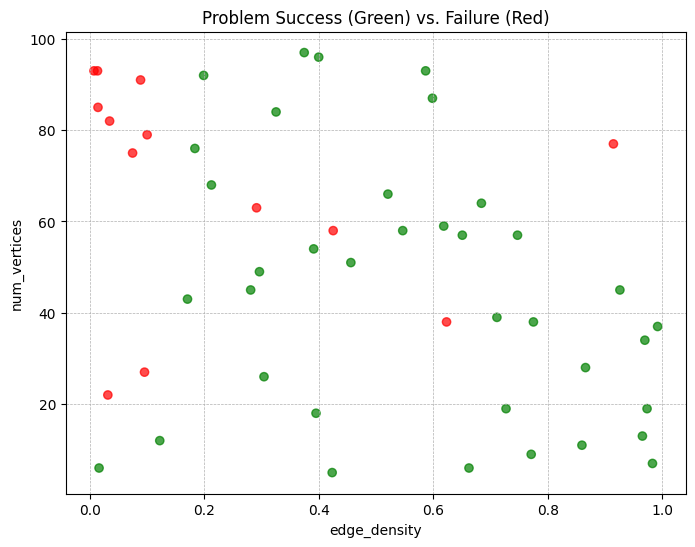

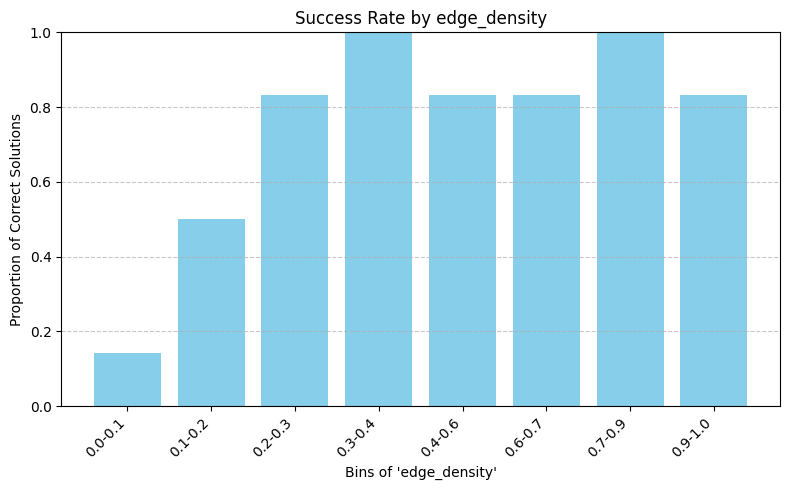

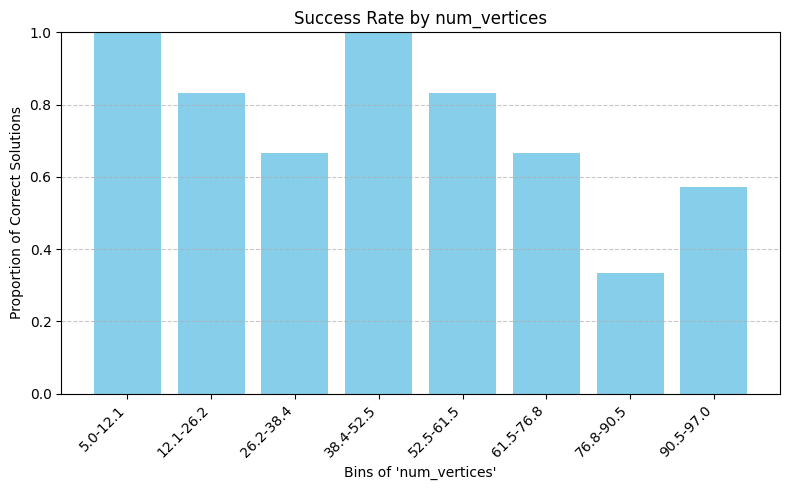

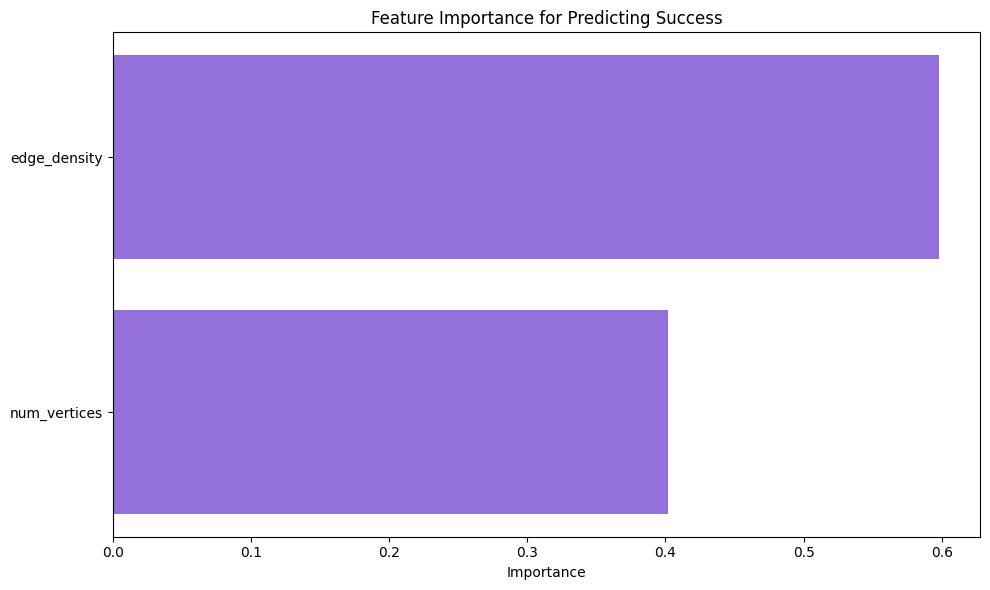

Classifier Accuracy (for feature importance): 0.90
Classifier F1 Score (for feature importance): 0.93

Average Solve Time: 66.77 seconds
Solve Time STD: 98.03 seconds
Overall Accuracy: 74.00%


In [ ]:
param_dist = {
    'num_vertices': randint(5, 100),
    'edge_density': uniform(0, 1),
}


args = TestProblemArgs(
    chat_model=chat_model,
    ft_model=model,
    ft_tokenizer=tokenizer,
    generator=generate_hamiltonian_path_graph,
    verifier=verify_hamiltonian_path,
    solver=ReactHamiltonianPathSolver,
    generator_args=param_dist
)

N_PROBLEMS_TO_SOLVE = 50
experiment_results = run_experiment(
    args=args,
    n_problems=N_PROBLEMS_TO_SOLVE,
    random_state=42
)

print("\n\n--- FINAL EXPERIMENT REPORT ---")
report_results(experiment_results)

# save_results(experiment_results, 'my_experiment_results.pkl')

In [ ]:
save_results(experiment_results, '/content/drive/MyDrive/my_experiment_results_1.pkl')

Results saved to /content/drive/MyDrive/my_experiment_results_1.pkl


In [ ]:
save_results_json(experiment_results, '/content/drive/MyDrive/my_experiment_results_1.json')

Results saved to /content/drive/MyDrive/my_experiment_results_1.json


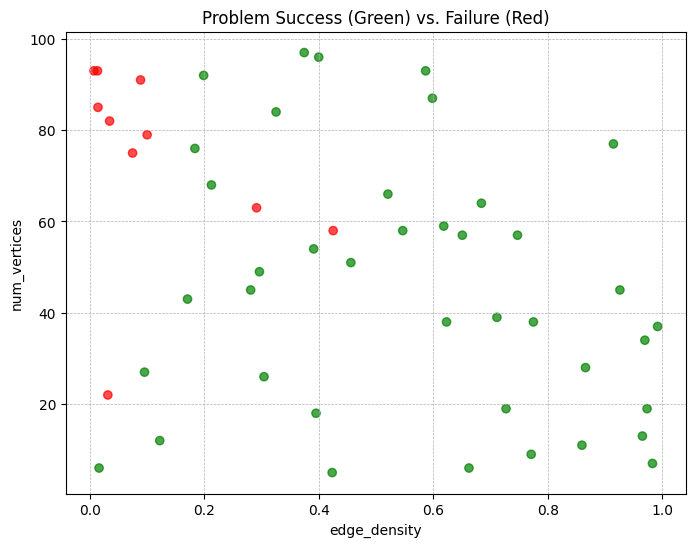

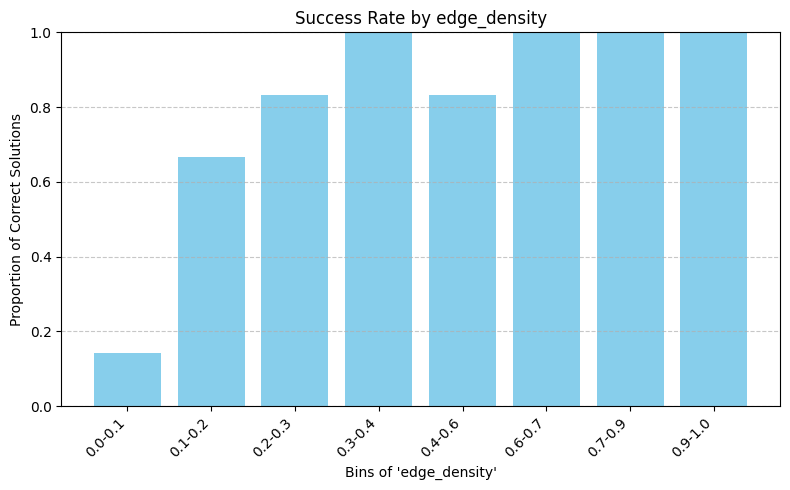

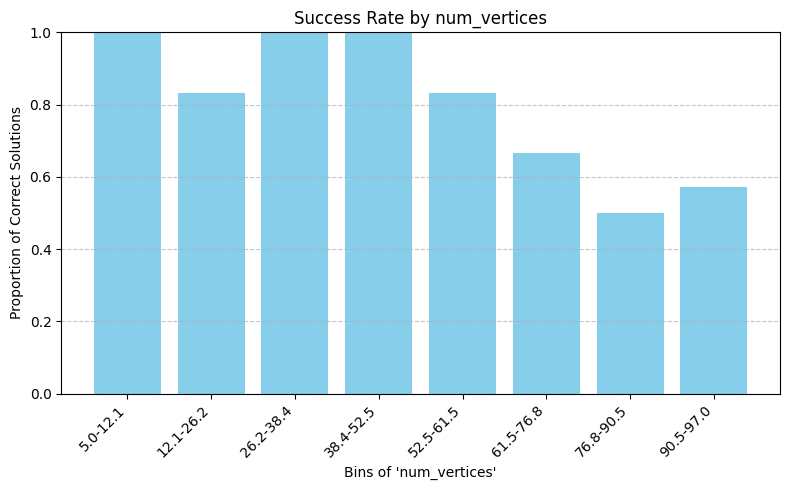

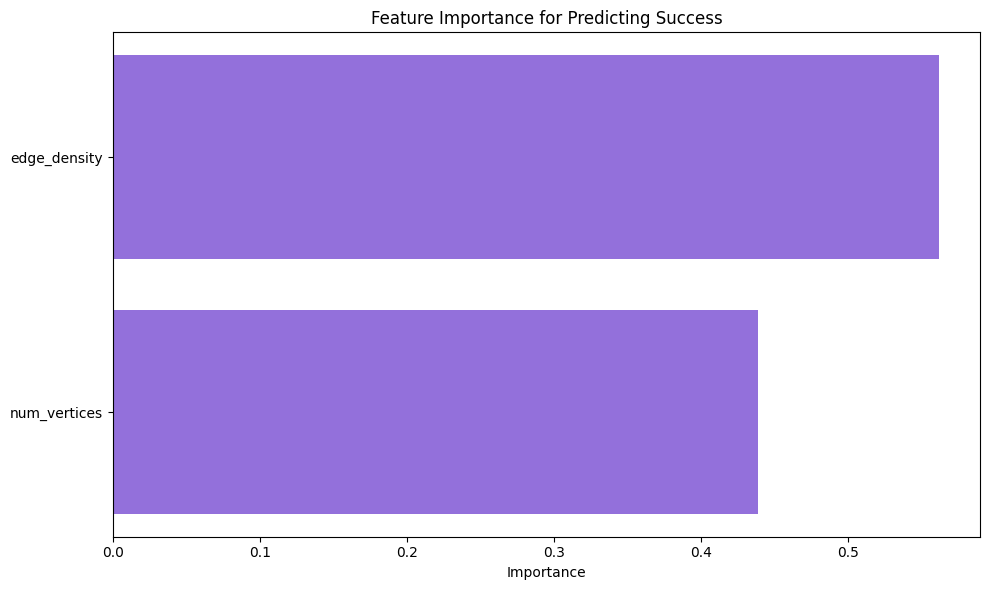

Classifier Accuracy (for feature importance): 0.90
Classifier F1 Score (for feature importance): 0.94

Average Solve Time: 66.77 seconds
Solve Time STD: 98.03 seconds
Overall Accuracy: 80.00%


In [ ]:
report_results(experiment_results)

### ReAct Agent 3

#### Model

In [ ]:
import re
from unsloth import FastLanguageModel
from NP_problems import generate_hamiltonian_path_graph, verify_hamiltonian_path, solve_hamiltonian_path_with_z3, visualize_hamiltonian_path_graph

max_prompt_length = 20296
max_completion_length = 231
max_seq_length = max_prompt_length+max_completion_length
load_in_4bit = True
dtype = None

def load_model_tokenizer(path):
    print(f"Loading model from: {path}")
    model, tokenizer = FastLanguageModel.from_pretrained(
        path,
        max_seq_length=max_seq_length,
        fast_inference = False,
        gpu_memory_utilization=1.0
    )
    return model, tokenizer


def format_graph_problem_for_llm_base(generated_graph):
    prompt = (f"Graph:\n")
    for vertex, neighbors in sorted(generated_graph.items()):
        prompt += f"{vertex:03d}:"
        for neighbor in sorted(neighbors):
            prompt += f"{neighbor:03d}"
        prompt += "\n"

    return prompt

def create_ham_path_prompt_base(formatted_problem_str):
    system_content = (
        "You are an expert in graph theory specializing in Hamiltonian "
        "Path Problem. You receive an undirected graph where "
        "each line contains adjacent vertices for vertex. Your must "
        "return a path that visits every vertex exactly once. "
        "You must provide the sequence of vertices and no additional text.\n"
    )
    human_content = f"{formatted_problem_str}\nHamiltonian Path:\n"
    return system_content, human_content


def get_llm_output(model, tokenizer, llm_input, max_new_tokens = 256):
    inputs = tokenizer([llm_input], return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        pad_token_id=tokenizer.eos_token_id
    )
    input_length = inputs.input_ids.shape[1]
    decoded_output = tokenizer.decode(outputs[0][input_length:], skip_special_tokens=True)
    return decoded_output.strip()

def extract_path_from_output(llm_output):
    pattern = re.compile(r"\d\d\d", re.IGNORECASE)
    subset = pattern.findall(llm_output.strip())
    return [int(number) for number in subset]

def create_test_example(num_vertices, edge_density, tokenizer):
    generated_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=num_vertices, edge_density = edge_density)
    # generated_graph = {key: sorted(value) for key, value in generated_graph.items()}
    generated_graph_str = format_graph_problem_for_llm_base(generated_graph)
    system_message, human_message = create_ham_path_prompt_base(generated_graph_str)
    conversation = [
        {"role": "system", "content": system_message },
        {"role": "user", "content": human_message },
        # {"role": "assistant", "content": ""}
    ]
    llm_input = tokenizer.apply_chat_template(conversation, tokenize = False, add_generation_prompt = True)
    return generated_graph, known_solution, llm_input

In [ ]:
from google.colab import drive

drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
# path = "/content/drive/MyDrive/LLM_NP_Problems/models/sft-grpo-5-llama-instruct/"
# model, tokenizer = load_model_tokenizer(path)

Loading model from: /content/drive/MyDrive/LLM_NP_Problems/models/sft-grpo-5-llama-instruct/


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.8: Fast Llama patching. Transformers: 4.55.2. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.35G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2025.8.8 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


In [ ]:
path = "/content/drive/MyDrive/LLM_NP_Problems/models/sft-3-llama-instruct/"
model, tokenizer = load_model_tokenizer(path)

Loading model from: /content/drive/MyDrive/LLM_NP_Problems/models/sft-3-llama-instruct/


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


==((====))==  Unsloth 2025.8.8: Fast Qwen3 patching. Transformers: 4.55.2. vLLM: 0.10.1.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

Unsloth 2025.8.8 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


In [ ]:
graph, solution, prompt = create_test_example(16, 0.6, tokenizer)
print("Graph:")
for key, value in graph.items():
  print(f"{key}: {value}")
print("="*100)

print(f"Prompt: {prompt}")
print("="*100)

llm_raw_output = get_llm_output(model, tokenizer, prompt)
print(f"LLM Raw Output: {llm_raw_output}")
print("="*100)

llm_path = extract_path_from_output(llm_raw_output)
print(f"LLM Path: {llm_path}")
print("="*100)

print(verify_hamiltonian_path(llm_path, graph))

Graph:
0: [12, 13, 1, 2, 3, 5, 6, 7, 8, 11, 14, 15]
1: [5, 3, 0, 4, 7, 8, 10, 12, 13, 14]
2: [15, 7, 0, 4, 5, 6, 8, 9, 10, 11, 13, 14]
3: [1, 4, 0, 5, 7, 8, 10, 12, 13, 14, 15]
4: [3, 1, 2, 5, 6, 9, 10, 11, 12, 14]
5: [8, 1, 0, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13]
6: [10, 12, 0, 2, 4, 5, 7, 9, 11, 13, 14, 15]
7: [2, 8, 0, 1, 3, 5, 6, 9, 13]
8: [7, 5, 0, 1, 2, 3, 10, 11, 12, 15]
9: [11, 14, 2, 4, 5, 6, 7, 12, 13, 15]
10: [14, 6, 1, 2, 3, 4, 5, 8, 12, 15]
11: [9, 0, 2, 4, 5, 6, 8, 14]
12: [6, 0, 1, 3, 4, 5, 8, 9, 10, 14]
13: [0, 15, 1, 2, 3, 5, 6, 7, 9, 14]
14: [9, 10, 0, 1, 2, 3, 4, 6, 11, 12, 13, 15]
15: [13, 2, 0, 3, 6, 8, 9, 10, 14]
Prompt: <|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 04 Sep 2025

You are an expert in graph theory specializing in Hamiltonian Path Problem. You receive an undirected graph where each line contains adjacent vertices for vertex. Your must return a path that visits every vertex exactly once. Yo

In [ ]:
import re
import time
import json
import torch
from time import sleep
from typing import List, Dict, Any

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode

from NP_problems import generate_hamiltonian_path_graph, verify_hamiltonian_path

def count_broken_edges_path(graph, path):
    broken_count = 0
    edges = {node: set(neighbors) for node, neighbors in graph.items()}
    for i in range(len(path) - 1):
        u = path[i]
        v = path[i+1]
        if v not in edges.get(u, set()):
            broken_count += 1
    return broken_count

def perform_2_opt_swap(path, i, j):
    new_path = path[:i+1]
    segment_to_reverse = path[j:i:-1]
    new_path.extend(segment_to_reverse)
    new_path.extend(path[j+1:])
    return new_path

def solve_with_local_search_repair_path(graph, hint_path, max_iterations = 10):
    current_path = list(hint_path)
    num_vertices = len(graph)
    best_cost = count_broken_edges_path(graph, current_path)

    if best_cost == 0:
        return current_path, 0, True

    for iteration in range(max_iterations):
        improved_in_this_pass = False
        for i in range(num_vertices - 2):
            for j in range(i + 2, num_vertices):
                new_path = perform_2_opt_swap(current_path, i, j)
                new_cost = count_broken_edges_path(graph, new_path)

                if new_cost < best_cost:
                    current_path = new_path
                    best_cost = new_cost
                    improved_in_this_pass = True
                    if best_cost == 0:
                        return current_path, iteration + 1, True

        if not improved_in_this_pass:
            return current_path, iteration + 1, False

    return current_path, max_iterations, False


class ReactHamiltonianPathSolver:
    def __init__(self, chat_model, ft_model, ft_tokenizer, input_graph, known_solution):
        self.input_graph = input_graph
        self.known_solution = known_solution
        self.found_solution = None
        self.execution_time = None
        self.num_vertices = len(input_graph)

        self.ft_model = ft_model
        self.ft_tokenizer = ft_tokenizer

        self.tools = self._set_up_tools()
        self.chat_model = chat_model
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def verify_path(solution_path_str: str) -> Dict:
            """
            Checks if a proposed path is a valid Hamiltonian path for the graph.
            A Hamiltonian path must visit every vertex exactly once.

            Args:
                solution_path_str: A JSON string representing a list of vertices, e.g., '[0, 1, 3, 2]'.

            Returns:
                A dictionary indicating if the solution is valid and providing details.
            """
            try:
                path = json.loads(solution_path_str)
            except json.JSONDecodeError:
                return {"is_valid": False, "reason": "Invalid input. Not a valid JSON list."}

            required_nodes = set(self.input_graph.keys())
            visited_nodes = set(path)

            if len(path) != len(visited_nodes):
                return {"is_valid": False, "reason": "The path visits some vertices more than once."}

            if visited_nodes != required_nodes:
                missing = required_nodes - visited_nodes
                extra = visited_nodes - required_nodes
                reason = f"Path must visit all {self.num_vertices} vertices exactly once. "
                if missing: reason += f"Missing: {missing}. "
                if extra: reason += f"Extra: {extra}."
                return {"is_valid": False, "reason": reason.strip()}

            invalid_edges = []
            for i in range(len(path) - 1):
                u, v = path[i], path[i+1]
                if v not in self.input_graph.get(u, []):
                    invalid_edges.append((u, v))
            if invalid_edges:
                return {"is_valid": False, "reason": f"These edges do not exist in the graph: {invalid_edges}."}

            return {"is_valid": True, "reason": "This is a valid Hamiltonian Path."}

        @tool
        def repair_path_with_2_opt(hint_path_str: str) -> Dict:
            """
            Attempts to repair an invalid path into a valid Hamiltonian path using the 2-opt algorithm.
            Use this tool when 'verify_path' fails due to non-existent edges, but the path correctly includes all vertices.

            Args:
                hint_path_str: A JSON string of a list of ALL graph vertices, e.g., '[0, 1, 3, 2]'.

            Returns:
                A dictionary with the outcome. On success, returns the repaired path. On failure, gives a reason.
            """
            try:
                path = json.loads(hint_path_str)
            except json.JSONDecodeError:
                return {"status": "Error", "reason": f"Invalid input '{hint_path_str}'. Not a valid JSON list."}

            required_nodes = set(self.input_graph.keys())
            if set(path) != required_nodes:
                return {"status": "Error", "reason": "The hint path must contain all graph vertices exactly once."}

            repaired_path, iterations, status = solve_with_local_search_repair_path(self.input_graph, path)

            if status:
                return {"status": "SUCCESS", "repaired_path": repaired_path, "iterations_taken": iterations}
            else:
                return {"status": "FAILURE", "reason": f"2-opt algorithm failed after {iterations} iterations. Give a different Hint. This Hint was bad."}

        @tool
        def get_final_answer(solution_path_str: str) -> Dict:
            """
            Formats the final, verified solution and concludes the process.
            Call this tool ONLY when `verify_path` has returned `is_valid: True`.

            Args:
                solution_path_str: A JSON string of the list representing the final verified Hamiltonian path.

            Returns:
                A dictionary containing the final solution.
            """
            try:
                solution = json.loads(solution_path_str)
            except (json.JSONDecodeError, TypeError):
                return {"status": "Error", "details": "Invalid input. Must be a valid JSON string of a list."}
            return {"status": "SUCCESS", "final_solution": solution}

        return [verify_path, repair_path_with_2_opt, get_final_answer]

    def _initial_solver_node(self, state: MessagesState) -> MessagesState:
        print("Generating initial path with fine-tuned LLM...")
        graph_str = format_graph_problem_for_llm_base(self.input_graph)
        system_msg, human_msg = create_ham_path_prompt_base(graph_str)
        conversation = [{"role": "system", "content": system_msg}, {"role": "user", "content": human_msg}]
        llm_input = self.ft_tokenizer.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)

        raw_output = get_llm_output(self.ft_model, self.ft_tokenizer, llm_input)

        initial_path = extract_path_from_output(raw_output)

        print(f"Fine-tuned LLM raw output: '{raw_output}'")
        print(f"Parsed initial path: {initial_path}")

        ai_message = AIMessage(content=f"The fine-tuned model proposed the following initial path: {json.dumps(initial_path)}. I will now verify it.")
        return {"messages": [ai_message]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        system_content = (
            "You are a diligent assistant that finds a Hamiltonian Path using powerful tools.\n"
            f"The graph is: {json.dumps(self.input_graph)}\n"
            f"Your goal is to find a valid Hamiltonian Path, visiting all {self.num_vertices} vertices exactly once.\n\n"
            "**Your Workflow:**\n"
            "1. **Verify Initial Path**: You'll receive a proposed path. Immediately use the `verify_path` tool on it.\n"
            "2. **If Correct**: Great! Call `get_final_answer` with the verified path to finish.\n"
            "3. **If Incorrect**: Analyze the reason from `verify_path`.\n"
            "   - If the path has **non-existent edges** but includes all vertices, use the `repair_path_with_2_opt` tool.\n"
            "   - After getting a `repaired_path` from the tool, you MUST verify it again with `verify_path`.\n"
            "4. **Iterate**: Always verify any new path. A solution is guaranteed to exist."
        )
        react_system_prompt = SystemMessage(content=system_content)
        new_message = self.model_with_tools.invoke([react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)
        builder.add_node("initial_solver", self._initial_solver_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "initial_solver")
        builder.add_edge("initial_solver", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")
        return builder.compile()

    def solve(self, verbose = True):
        initial_messages = {"messages": [HumanMessage(content="Start the process.")]}
        if verbose:
            print(f"\033[1m{' Solving Hamiltonian Path Problem ':#^88}\033[0m")
            print(f"Graph: {json.dumps(self.input_graph)}\n")

        final_state = None
        try:
            start_time = time.time()
            for i, chunk in enumerate(self.graph.stream(initial_messages, stream_mode="values")):
                if verbose:
                    node_name = list(chunk.keys())[0]
                    print(f"\033[1m{f' Step {i+1}: Executing `{node_name}` Node ':=^88}\033[0m")
                    chunk["messages"][-1].pretty_print()
                final_state = chunk
            end_time = time.time()
            self.execution_time = end_time - start_time

        except Exception as e:
            end_time = time.time()
            self.execution_time = end_time - start_time
            if verbose:
                print(f"\n\033[1m{' An Unexpected Error Occurred ':#^88}\033[0m")
                print(f"\033[91m\033[1mError during execution: {type(e).__name__} - {e}\033[0m")
                print("\033[91m\033[1mCould not find a valid solution.\033[0m")
            return None, self.execution_time

        if verbose:
            print(f"\033[1m{' Final Result ':=^88}\033[0m")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            tool_call = last_message.tool_calls[0]
            if tool_call['name'] == 'get_final_answer':
                args = tool_call['args']
                if 'solution_path_str' in args:
                    try:
                        self.found_solution = json.loads(args['solution_path_str'])
                        is_correct = verify_hamiltonian_path(self.found_solution, self.input_graph)
                        if verbose:
                            print(f"Input Graph: {json.dumps(self.input_graph)}")
                            print(f"Execution Time: {self.execution_time:.2f} seconds")
                            print(f"A Known Correct Solution: {self.known_solution}")
                            print(f"Agent's Found Solution:   {self.found_solution}")
                            if is_correct:
                                print("\n\033[92m\033[1mFound Solution Is Correct\033[0m")
                            else:
                                print("\n\033[91m\033[1mFound Solution Is Incorrect\033[0m")
                        return self.found_solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        if verbose:
            print("\033[91m\033[1mCould not find a valid solution.\033[0m")
        return None, self.execution_time



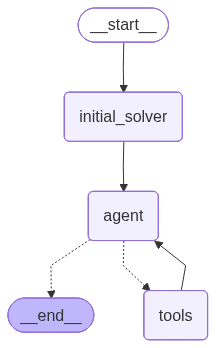

In [ ]:
from IPython.display import Image, display

ft_model, ft_tokenizer = model, tokenizer
input_graph, known_solution = generate_hamiltonian_path_graph(num_vertices=10, edge_density=0.5)

solver = ReactHamiltonianPathSolver(
    chat_model=chat_model,
    ft_model=ft_model,
    ft_tokenizer=ft_tokenizer,
    input_graph=input_graph,
    known_solution=known_solution
)

graph_image = solver.graph.get_graph().draw_mermaid_png()
display(Image(graph_image))

#### Result 1

In [ ]:
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import numpy as np
import pickle
import time
import json
from scipy.stats import randint, uniform
from sklearn.model_selection import ParameterSampler, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import ToolNode
from NP_problems import generate_hamiltonian_path_graph, verify_hamiltonian_path

class TestProblemArgs():
  def __init__(self, chat_model=None, ft_model=None, ft_tokenizer=None, generator=None, verifier=None, solver=None, generator_args=None):
    self.chat_model = chat_model
    self.ft_model=ft_model
    self.ft_tokenizer=ft_tokenizer
    self.generator = generator
    self.verifier = verifier
    self.solver = solver
    self.generator_args = generator_args

def run_experiment(args, n_problems, random_state=42):
    results = []
    param_sampler = ParameterSampler(
        param_distributions=args.generator_args,
        n_iter=n_problems,
        random_state=random_state
    )

    for i, generator_params in enumerate(param_sampler):
        print(f"\n{'='*35} Problem {i+1}/{n_problems} {'='*35}")
        print(f"Generator Parameters: {generator_params}")

        input_graph, known_solution = args.generator(**generator_params)

        solver = args.solver(
            chat_model=args.chat_model,
            ft_model=args.ft_model,
            ft_tokenizer=args.ft_tokenizer,
            input_graph=input_graph,
            known_solution=known_solution
        )

        found_solution, exec_time = solver.solve(verbose=True)

        is_correct = int(args.verifier(found_solution, input_graph)[0])

        results.append({
            'Generator Parameters': generator_params,
            'Input Graph': input_graph,
            'Known Solution': known_solution,
            'Found Solution': found_solution,
            'Execution Time': exec_time,
            'Is Correct': is_correct,
        })

    return results

def scatter_plot_correctness(X, y):
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) < 2:
        print("Not enough numeric features for a scatter plot.")
        return

    for c1, c2 in itertools.combinations(numeric_cols, 2):
        plt.figure(figsize=(8, 6))
        colors = ['green' if res else 'red' for res in y.values]
        plt.scatter(X[c1], X[c2], c=colors, alpha=0.7)
        plt.xlabel(c1)
        plt.ylabel(c2)
        plt.title(f"Problem Success (Green) vs. Failure (Red)")
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.show()

def plot_correctness_distribution(X, y, n_bins=8):
    numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
    for feature in numeric_cols:
        plt.figure(figsize=(8, 5))
        feature_values = X[feature]
        bins = pd.qcut(feature_values, q=min(n_bins, feature_values.nunique()), duplicates='drop').cat.categories
        proportions = []
        bin_labels = []

        for interval in bins:
            lower, upper = interval.left, interval.right
            mask = (feature_values > lower) & (feature_values <= upper)
            if mask.sum() > 0:
                proportion = y[mask].mean()
                proportions.append(proportion)
                bin_labels.append(f"{lower:.1f}-{upper:.1f}")

        plt.bar(bin_labels, proportions, color='skyblue')
        plt.xlabel(f"Bins of '{feature}'")
        plt.ylabel('Proportion of Correct Solutions')
        plt.title(f'Success Rate by {feature}')
        plt.ylim(0, 1)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

def plot_feature_importance(X, y):
    feature_names = X.columns
    if len(feature_names) == 0:
        return

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)

    importance = model.feature_importances_
    indices = np.argsort(importance)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importance[indices], color='mediumpurple')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Importance')
    plt.title('Feature Importance for Predicting Success')
    plt.tight_layout()
    plt.show()

    y_pred = model.predict(X_test)
    print(f"Classifier Accuracy (for feature importance): {accuracy_score(y_test, y_pred):.2f}")
    print(f"Classifier F1 Score (for feature importance): {f1_score(y_test, y_pred, zero_division=0):.2f}")


def report_results(results):
    if not results:
        print("No results to report.")
        return

    df = pd.DataFrame([res['Generator Parameters'] for res in results])
    df['Is Correct'] = [res['Is Correct'] for res in results]

    features = [key for key in results[0]['Generator Parameters'] if isinstance(results[0]['Generator Parameters'][key], (int, float))]

    if not features:
        print("No numeric features found to plot.")
    else:
        X = df[features]
        y = df['Is Correct']
        scatter_plot_correctness(X, y)
        plot_correctness_distribution(X, y)
        plot_feature_importance(X, y)

    solve_times = [res['Execution Time'] for res in results if res['Execution Time'] is not None]
    if solve_times:
        print(f"\nAverage Solve Time: {np.mean(solve_times):.2f} seconds")
        print(f"Solve Time STD: {np.std(solve_times):.2f} seconds")

    total_correct = sum(res['Is Correct'] for res in results)
    print(f"Overall Accuracy: {total_correct / len(results):.2%}")

def save_results(results, path):
    with open(path, 'wb') as f:
        pickle.dump(results, f)
    print(f"Results saved to {path}")

def load_results(path):
    with open(path, 'rb') as f:
        results = pickle.load(f)
    print(f"Results loaded from {path}")
    return results

def save_results_json(results, path):
    with open(path, 'w') as f:
        json.dump(results, f, indent=4)
    print(f"Results saved to {path}")

def load_results_json(path):
    with open(path, 'r') as f:
        results = json.load(f)
    print(f"Results loaded from {path}")
    return results


=================================== Problem 1/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.3745401188473625), 'num_vertices': 97}
########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [74, 12, 1, 4, 13, 14, 18, 21, 22, 24, 27, 28, 29, 30, 31, 32, 35, 37, 38, 42, 44, 47, 48, 50, 54, 55, 57, 59, 60, 64, 65, 67, 69, 71, 76, 79, 80, 81, 86, 87, 90, 91, 94, 96], "1": [53, 48, 0, 3, 9, 10, 18, 22, 23, 25, 27, 28, 33, 36, 37, 38, 46, 50, 52, 54, 57, 58, 61, 63, 66, 70, 71, 79, 81, 82, 83, 85, 87, 91, 92, 95, 96], "2": [3, 10, 12, 13, 21, 24, 26, 30, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 48, 49, 52, 54, 58, 60, 61, 63, 64, 66, 67, 69, 72, 76, 79, 85, 88, 90, 92, 93], "3": [39, 2, 1, 5, 8, 9, 11, 13, 15, 19, 25, 28, 30, 31, 37, 38, 43, 46, 47, 49, 50, 53, 54, 59, 62, 65, 74, 76, 78, 80, 81, 82, 85, 87, 88, 89, 90, 92, 95], "4": [9, 21, 0, 10, 13, 14, 17, 18, 19, 20, 22, 26, 27, 28, 30, 35, 38, 40, 4

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
].


========================== Step 25: Executing `messages` Node ==========================
================================== Ai Message ==================================

The initial path was invalid because it visited some vertices more than once. I have attempted to repair the path using `repair_path_with_2_opt` with several hint paths, including a simple sequential path and a reversed sequential path, but the tool has consistently failed, indicating that the provided hints were not effective. I will try again with a simple sequential path as a hint, as it ensures all vertices are present exactly once, which is a requirement for the `repair_path_with_2_opt` tool.
Tool Calls:
  repair_path_with_2_opt (089cd690-fe7d-4e24-bb3d-53e251f80aca)
 Call ID: 089cd690-fe7d-4e24-bb3d-53e251f80aca
  Args:
    hint_path_str: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]
=============

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 9
}
].


========================== Step 19: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (86ff44fe-cc54-4eea-ac97-1a81fab47188)
 Call ID: 86ff44fe-cc54-4eea-ac97-1a81fab47188
  Args:
    solution_path_str: [24, 4, 36, 38, 6, 12, 48, 41, 20, 8, 34, 11, 0, 1, 3, 2, 21, 30, 31, 32, 5, 39, 37, 33, 9, 10, 46, 45, 44, 43, 18, 17, 16, 15, 14, 13, 35, 19, 7, 42, 40, 27, 26, 25, 28, 29, 47, 22, 23]
========================== Step 20: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 4
}
].


========================== Step 21: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  get_final_answer (4e7933c4-5237-4d6e-b94f-cc2990a08f2e)
 Call ID: 4e7933c4-5237-4d6e-b94f-cc2990a08f2e
  Args:
    solution_path_str: [24, 4, 36, 38, 6, 12, 48, 41, 20, 8, 34, 11, 0, 1, 3, 2, 21, 30, 31, 32, 5, 39, 37, 33, 9, 10, 46, 45, 44, 43, 18, 17, 16, 15, 14, 13, 35, 19, 7, 42, 40, 27, 26, 25, 28, 29, 47, 22, 23]
===================================== Final Result =====================================
Input Graph: {"0": [46, 10, 1, 2, 7, 8, 9, 11, 14, 15, 16, 33, 44], "1": [41, 7, 0, 3, 6, 9, 16, 18, 34, 35, 37, 38, 44, 46], "2": [31, 39, 0, 3, 6, 7, 9, 11, 12, 19, 20, 21, 24, 29, 32, 37, 38, 44, 47], "3": [33, 28, 1, 2, 7, 9, 11, 17, 21, 25, 26, 27, 30, 34, 38, 39, 40, 41, 42], "4": [25, 12, 15, 16, 17, 22, 24, 26, 29, 33, 34, 36, 39, 46], "5": [48, 30, 7, 12, 14, 16, 17, 20, 23, 31, 32, 35, 38, 39,

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 44
}
].


========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (9aff2530-617a-4cd3-a7ab-bb664fcc7515)
 Call ID: 9aff2530-617a-4cd3-a7ab-bb664fcc7515
  Args:
    solution_path_str: [0, 12, 21, 24, 29, 25, 37, 44, 36, 44, 48, 10, 12, 27, 29, 35, 5, 27, 29, 35, 7, 36, 44, 48, 15, 20, 21, 24, 29, 31, 32, 39, 41, 42, 58, 56, 71, 11, 24, 24, 29, 25, 37, 44, 48, 10, 13, 41, 42, 57, 58, 66, 9, 11, 24, 28, 33, 41, 41, 42, 58, 66, 9, 11, 24, 28, 33, 41, 33, 41, 42, 59, 67, 26, 41, 49, 50, 55, 68, 71, 72, 14, 24, 29, 25, 37, 44, 48, 15, 20, 21, 24, 29, 35, 4, 27, 29, 35, 4, 27, 39, 66, 22, 38, 52, 56, 62, 68, 71, 72, 14, 24, 29, 25, 37, 44, 48, 15, 20, 21, 24, 29, 31, 31, 45, 47, 63, 70, 6, 9, 11, 24, 28, 33, 41, 33, 41, 42, 58, 57, 58, 52, 56, 62, 68, 71, 72, 14, 24, 29, 25, 37, 44, 48, 15, 20, 21, 24, 28, 33, 41, 33, 42, 59, 67, 49, 50, 55, 50, 56, 71, 72, 11, 24,

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 33
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 30
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 30
}
]
Could not find a valid solution.

=================================== Problem 42/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.4234014807063696), 'num_vertices': 5

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 14
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 11
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 11
}
]
Could not find a valid solution.

=================================== Problem 43/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.1987156815341724), 'num_vertices': 9

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 53
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 52
}
]
Could not find a valid solution.

=================================== Problem 44/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.014079822715084456), 'num_vertices':

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 36
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 34
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 33
}
]
Could not find a valid solution.

=================================== Problem 45/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.71134195274865), 'num_vertices': 39}

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 18
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 15
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 14
}
]
Could not find a valid solution.

=================================== Problem 46/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.7712703466859457), 'num_vertices': 9

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 56
}
]
Could not find a valid solution.

=================================== Problem 47/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.926300878513349), 'num_vertices': 45

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 41
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 38
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 37
}
]
Could not find a valid solution.

=================================== Problem 48/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.9149596755437808), 'num_vertices': 7

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 19
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 17
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 16
}
]
Could not find a valid solution.

=================================== Problem 49/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.6232981268275579), 'num_vertices': 3

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 58
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_

========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (31721f77-d09d-4c04-bf81-173eb42c123c)
 Call ID: 31721f77-d09d-4c04-bf81-173eb42c123c
  Args:
    solution_path_str: [0, 1, 3, 4, 8, 9, 10, 11, 12, 13, 14, 16, 17, 20, 21, 22, 26, 28, 29, 30, 31, 34, 35, 36, 37, 7, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 21, 22, 26, 28, 29, 30, 31, 34, 35, 36, 37, 7, 5, 6, 7, 8, 9, 15, 17, 20, 21, 22, 26, 28, 29, 30, 31, 34, 35, 36, 37, 9, 13, 14, 16, 17, 21, 23, 24, 25, 26, 28, 29, 30, 31, 34, 35, 36, 37, 9, 13, 11, 12, 15, 16, 27, 28, 29, 30, 31, 34, 35, 36, 37, 7, 5, 6, 7, 8, 9, 15, 16, 17, 20, 21, 22, 26, 28, 29, 30, 31, 34, 35, 36, 37, 9, 13, 14, 16, 27, 28, 29, 30, 31, 34, 35, 36, 37, 9, 13, 11, 12, 15, 16, 27, 28, 29, 30, 31, 34, 35, 36, 37, 7, 5, 6, 5, 3, 4, 6, 7, 8, 9, 17, 20, 21, 22, 26, 28, 29, 30, 31, 34, 35, 36, 37, 9, 13, 14, 16, 27, 28, 29, 30, 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 43
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 40
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont

========================== Step 7: Executing `messages` Node ===========================
================================== Ai Message ==================================

I understand. The initial path was invalid because it contained duplicate vertices, and the `repair_path_with_2_opt` tool requires a path that includes all vertices exactly once. I will now create a path with all vertices in numerical order and attempt to repair it.
Tool Calls:
  repair_path_with_2_opt (f9841ce1-f1a1-4039-b304-153e0f0fa556)
 Call ID: f9841ce1-f1a1-4039-b304-153e0f0fa556
  Args:
    hint_path_str: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
========================== Step 8: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: repair_path_with_2_opt

{"status": "SUCCESS", "repaired_path": [0, 22, 26, 14, 33, 32, 13, 12

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 25
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 23
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 22
}
]
Could not find a valid solution.

=================================== Problem 50/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.09541011649041131), 'num_vertices': 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 7
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 4
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_conten


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 3
}
]
Could not find a valid solution.


--- FINAL EXPERIMENT REPORT ---


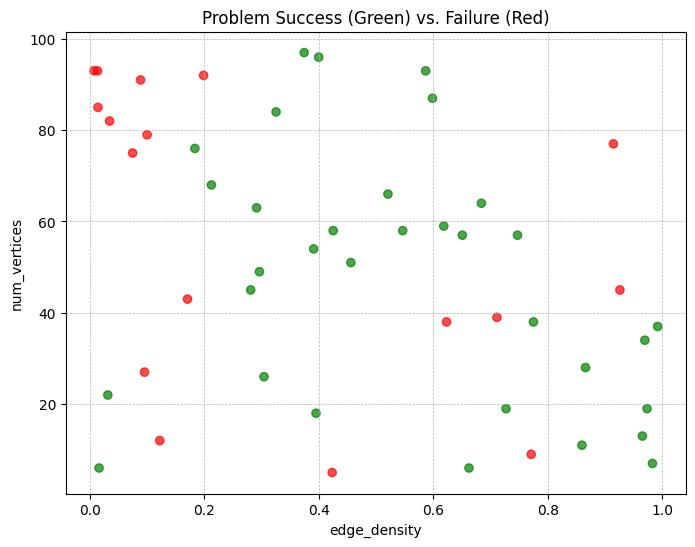

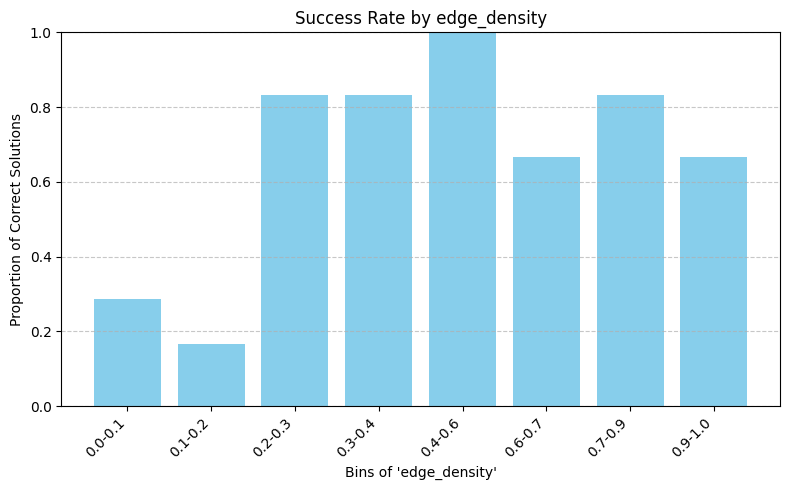

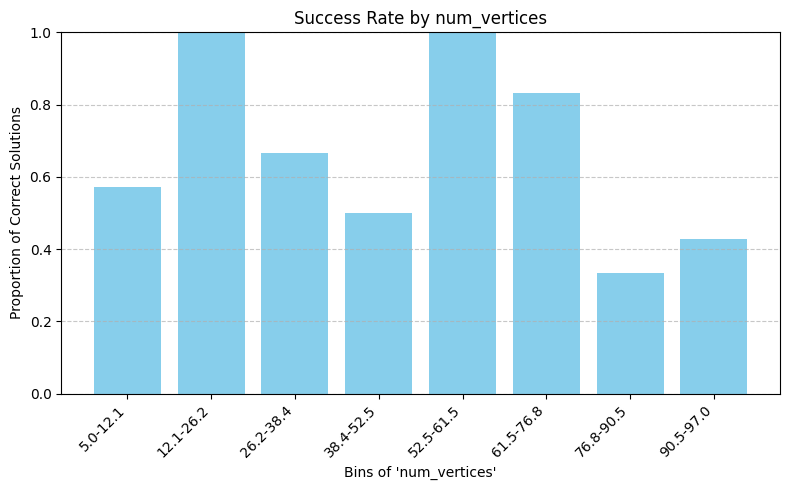

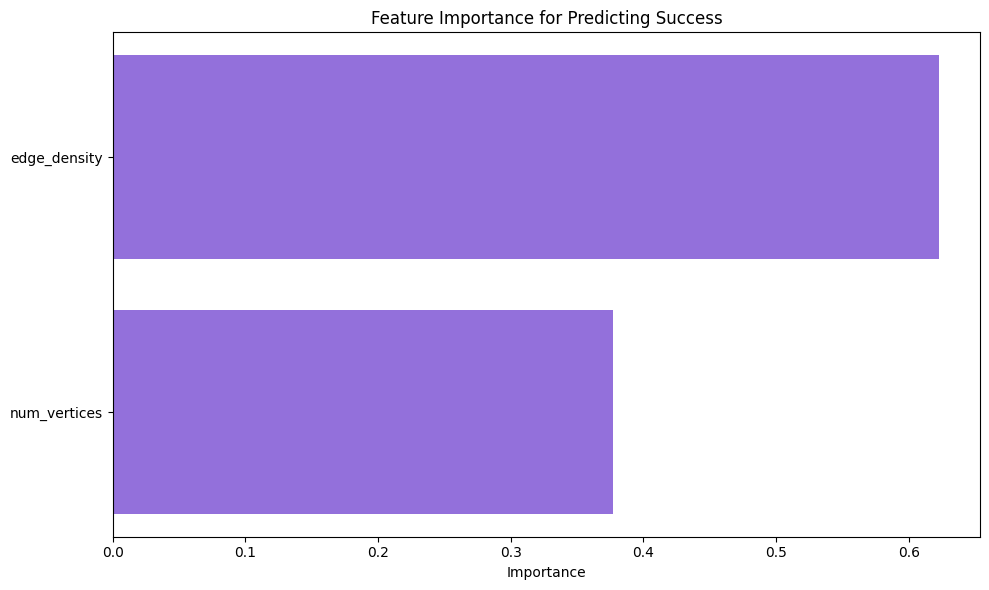

Classifier Accuracy (for feature importance): 0.70
Classifier F1 Score (for feature importance): 0.77

Average Solve Time: 121.57 seconds
Solve Time STD: 144.67 seconds
Overall Accuracy: 66.00%


In [ ]:
param_dist = {
    'num_vertices': randint(5, 100),
    'edge_density': uniform(0, 1),
}


args = TestProblemArgs(
    chat_model=chat_model,
    ft_model=model,
    ft_tokenizer=tokenizer,
    generator=generate_hamiltonian_path_graph,
    verifier=verify_hamiltonian_path,
    solver=ReactHamiltonianPathSolver,
    generator_args=param_dist
)

N_PROBLEMS_TO_SOLVE = 50
experiment_results = run_experiment(
    args=args,
    n_problems=N_PROBLEMS_TO_SOLVE,
    random_state=42
)

print("\n\n--- FINAL EXPERIMENT REPORT ---")
report_results(experiment_results)

# save_results(experiment_results, 'my_experiment_results.pkl')

In [ ]:
experiment_results_2 = experiment_results[:40]

In [ ]:
save_results(experiment_results_2, '/content/drive/MyDrive/my_experiment_results_3.pkl')
save_results_json(experiment_results_2, '/content/drive/MyDrive/my_experiment_results_3.json')

Results saved to /content/drive/MyDrive/my_experiment_results_3.pkl
Results saved to /content/drive/MyDrive/my_experiment_results_3.json


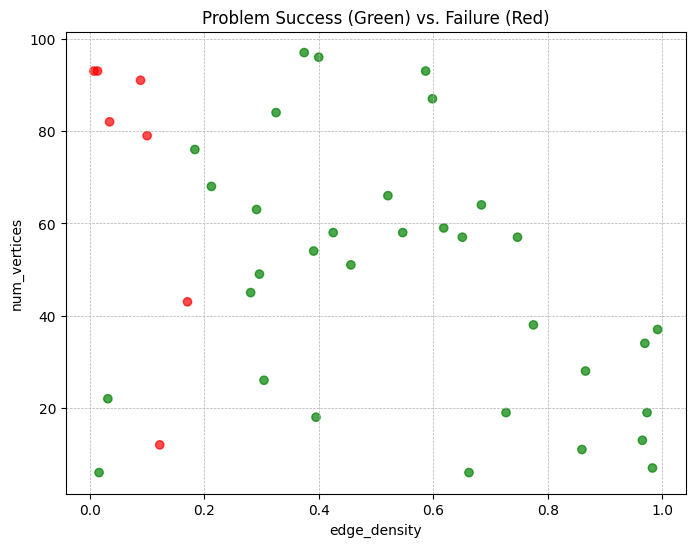

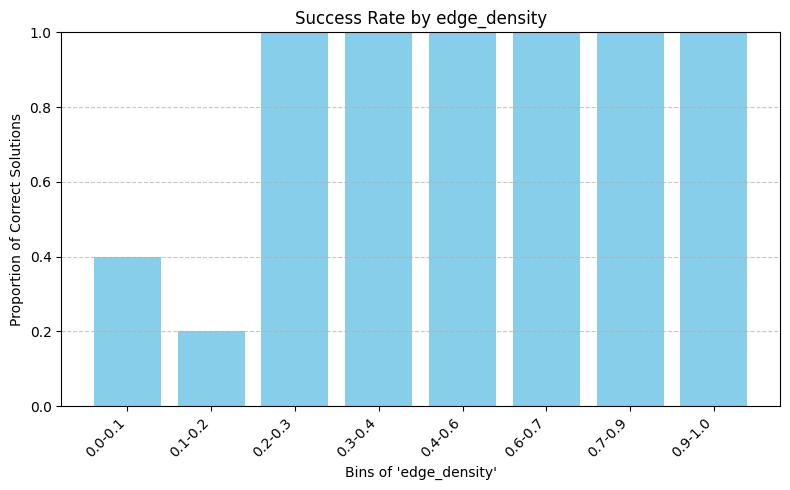

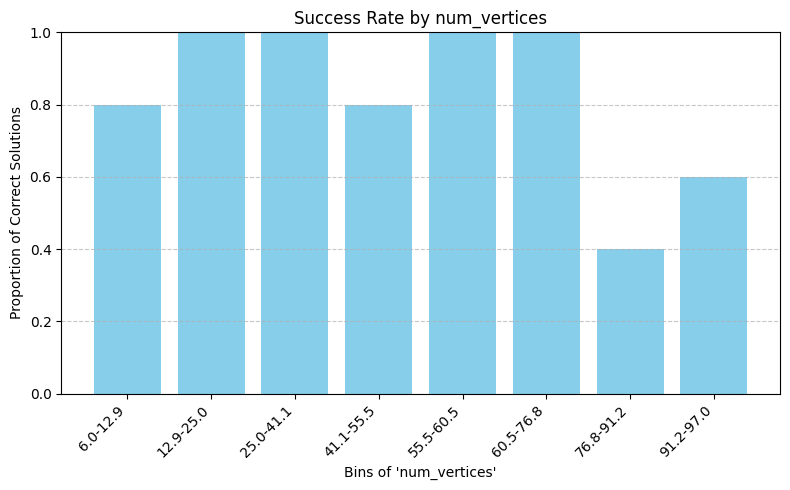

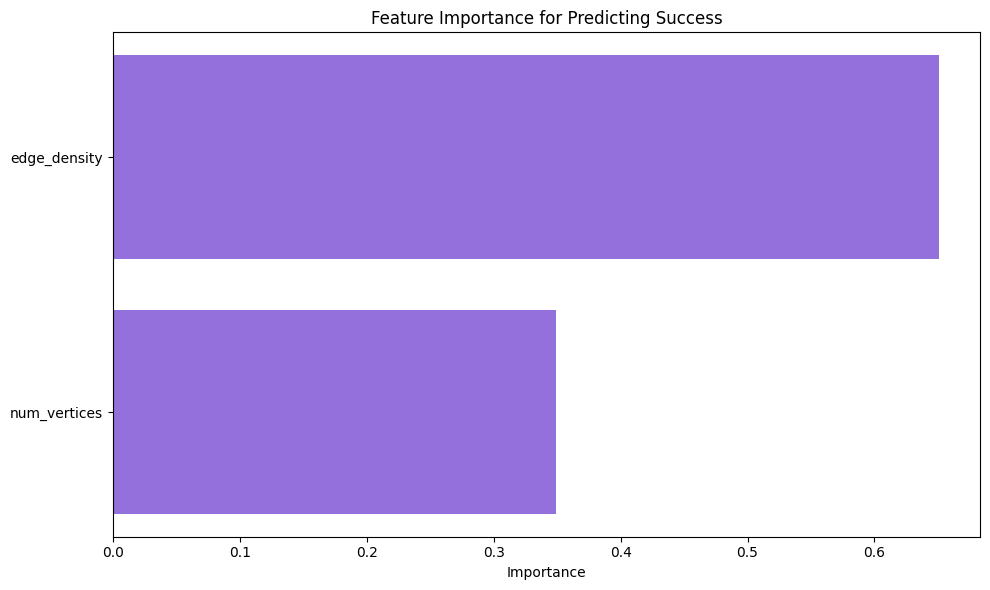

Classifier Accuracy (for feature importance): 1.00
Classifier F1 Score (for feature importance): 1.00

Average Solve Time: 129.57 seconds
Solve Time STD: 160.13 seconds
Overall Accuracy: 82.50%


In [ ]:
report_results(experiment_results_2)

#### Result 2


=================================== Problem 1/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.3745401188473625), 'num_vertices': 97}
########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [13, 87, 1, 2, 6, 10, 12, 14, 15, 17, 18, 20, 23, 31, 35, 36, 38, 49, 52, 57, 59, 64, 69, 70, 72, 83, 84, 85, 95], "1": [85, 83, 0, 3, 4, 5, 6, 15, 19, 21, 24, 27, 29, 33, 34, 37, 39, 40, 41, 43, 45, 46, 47, 48, 52, 53, 58, 62, 66, 68, 69, 72, 73, 75, 76, 77, 78, 79, 81, 82, 84, 87, 89, 92, 95, 96], "2": [10, 6, 0, 8, 9, 11, 13, 14, 16, 17, 22, 29, 30, 32, 35, 36, 39, 40, 41, 42, 46, 49, 50, 52, 57, 58, 63, 67, 71, 75, 76, 79, 80, 81, 83, 84, 85, 86, 87, 91], "3": [19, 56, 1, 4, 5, 6, 8, 9, 14, 20, 21, 23, 24, 25, 26, 27, 30, 35, 37, 41, 44, 47, 48, 63, 64, 66, 74, 76, 78, 79, 81, 82, 85, 87, 89, 90, 92, 93], "4": [76, 86, 1, 3, 5, 6, 16, 17, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 40, 42, 44, 48, 51, 52, 56, 58

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 31
}
].


========================== Step 17: Executing `messages` Node ==========================
================================== Ai Message ==================================
Tool Calls:
  get_final_answer (c8da918e-1f9a-428e-914c-0181ccb14e6b)
 Call ID: c8da918e-1f9a-428e-914c-0181ccb14e6b
  Args:
    solution_path_str: [3, 0, 4, 2, 1, 5]
===================================== Final Result =====================================
Input Graph: {"0": [3, 4], "1": [2, 5], "2": [4, 1], "3": [0], "4": [0, 2], "5": [1]}
Execution Time: 20.10 seconds
A Known Correct Solution: [3, 0, 4, 2, 1, 5]
Agent's Found Solution:   [3, 0, 4, 2, 1, 5]

Found Solution Is Correct

=================================== Problem 23/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.6842330265121569), 'num_vertices': 64}
########################### Solving Hamiltonian Path Problem ###########################
Graph: {"0": [50, 60, 1, 2, 4, 5, 6, 8, 10, 11, 12, 13, 16, 17, 18, 20, 21

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 57
}
].


========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (2eb83aef-5f47-4925-8738-dd764adb8f27)
 Call ID: 2eb83aef-5f47-4925-8738-dd764adb8f27
  Args:
    solution_path_str: [23, 43, 0, 13, 56, 25, 41, 2, 10, 54, 6, 12, 18, 22, 36, 14, 21, 1, 34, 38, 17, 7, 33, 48, 57, 27, 5, 40, 61, 19, 16, 32, 3, 8, 58, 39, 20, 46, 49, 15, 9, 29, 28, 24, 44, 31, 37, 51, 26, 53, 35, 4, 47, 52, 1, 50, 45, 60, 30, 42, 59, 11, 62, 63, 0]
========================== Step 4: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": false, "reason": "The path visits some vertices more than once."}
========================== Step 5: Executing `messages` Node ===========================
================================== Ai Message ==================================


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].


========================== Step 7: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (93553295-b1d8-4ea9-8572-39282ca3a2c5)
 Call ID: 93553295-b1d8-4ea9-8572-39282ca3a2c5
  Args:
    solution_path_str: [0, 14, 9, 10, 12, 13, 11, 8, 7, 6, 5, 4, 3, 1, 2, 15, 16, 17, 18]
========================== Step 8: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}
========================== Step 9: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  get_final_answer (bdf8970e-1185-4047-99e5-dd11b3f90019)
 Call ID: bdf8970e-1185-4047-99e5-dd11b3f90019
  Args:
    solution_path_str: [0, 14, 9, 10, 12, 13, 11, 8, 7, 6, 5, 4, 3, 1,

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 15
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 13
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont

========================== Step 9: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (a5940919-5d09-40bd-882a-d7cdd54e8205)
 Call ID: a5940919-5d09-40bd-882a-d7cdd54e8205
  Args:
    solution_path_str: [16, 12, 33, 4, 21, 10, 7, 0, 6, 31, 26, 27, 18, 19, 34, 14, 28, 36, 5, 20, 23, 22, 9, 38, 25, 1, 30, 37, 17, 35, 11, 29, 13, 24, 2, 15, 32, 8, 3]
========================== Step 10: Executing `messages` Node ==========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": true, "reason": "This is a valid Hamiltonian Path."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 58
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 56
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 55
}
]
Could not find a valid solution.

=================================== Problem 46/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.7712703466859457), 'num_vertices': 9

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 51
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 49
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont

========================== Step 3: Executing `messages` Node ===========================
================================== Ai Message ==================================
Tool Calls:
  verify_path (fd5f3479-3e88-4691-916d-654d2dd93bb9)
 Call ID: fd5f3479-3e88-4691-916d-654d2dd93bb9
  Args:
    solution_path_str: [7, 5, 1, 2, 4, 8, 6, 3, 0, 1, 3, 2, 0]
========================== Step 4: Executing `messages` Node ===========================
================================= Tool Message =================================
Name: verify_path

{"is_valid": false, "reason": "The path visits some vertices more than once."}


  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 47
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 45
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 44
}
]
Could not find a valid solution.

=================================== Problem 47/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.926300878513349), 'num_vertices': 45

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 16
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 14
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 13
}
]
Could not find a valid solution.

=================================== Problem 48/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.9149596755437808), 'num_vertices': 7

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 1
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 59
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_conte


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 58
}
]
Could not find a valid solution.

=================================== Problem 49/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.6232981268275579), 'num_vertices': 3

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 35
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 33
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 32
}
]
Could not find a valid solution.

=================================== Problem 50/50 ===================================
Generator Parameters: {'edge_density': np.float64(0.09541011649041131), 'num_vertices': 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 26
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 24
}
].
  quota_metric: "generativelanguage.googleapis.com/generate_cont


############################# An Unexpected Error Occurred #############################
Error during execution: ResourceExhausted - 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerDayPerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_value: 250
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 23
}
]
Could not find a valid solution.


--- FINAL EXPERIMENT REPORT ---


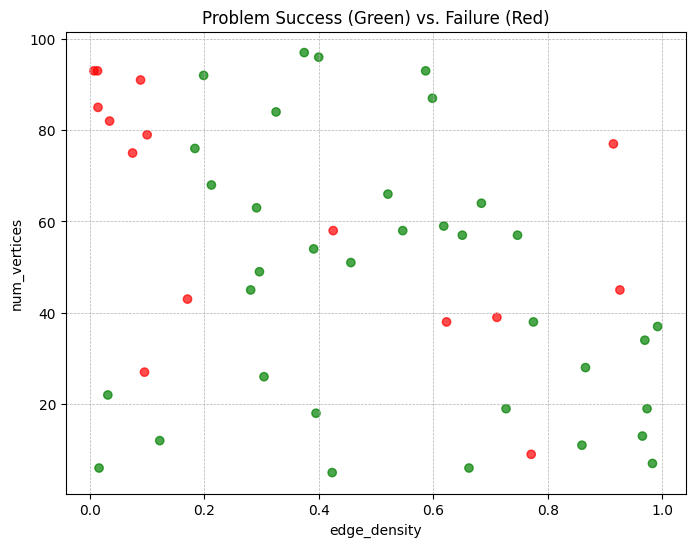

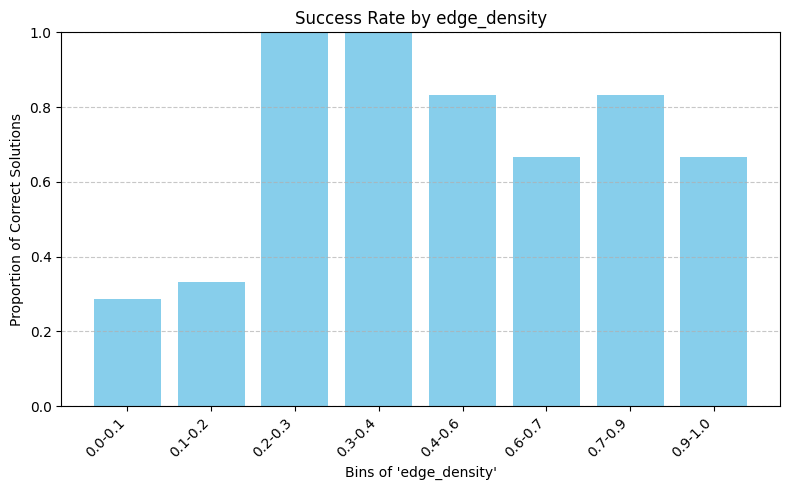

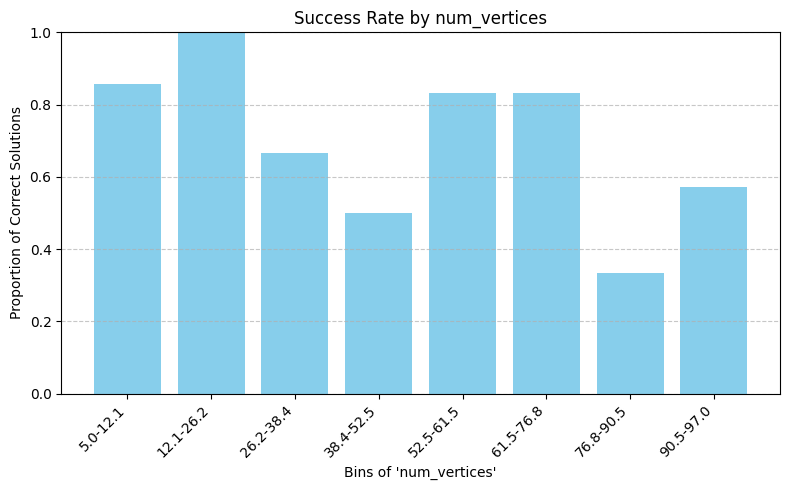

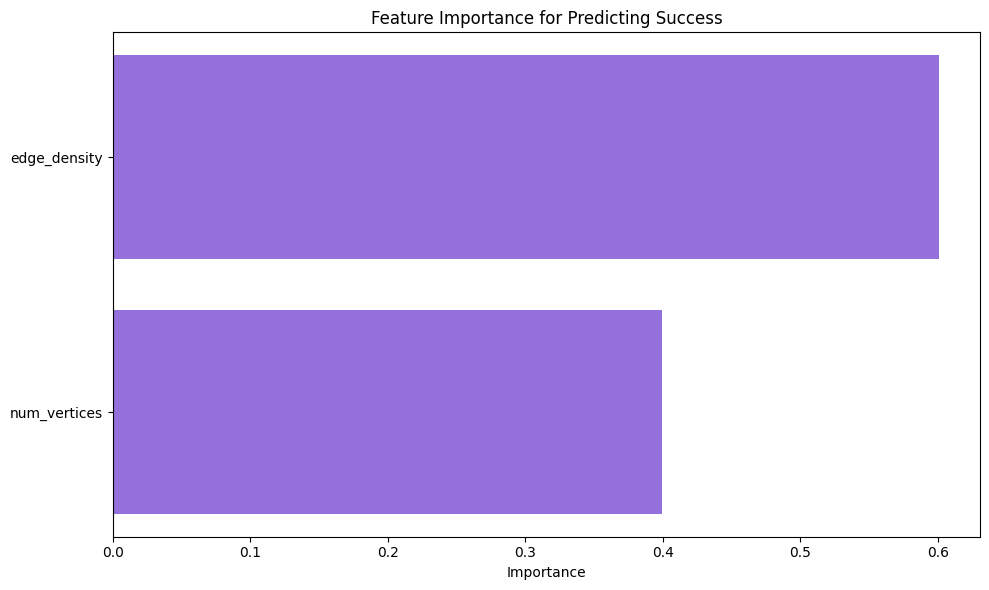

Classifier Accuracy (for feature importance): 0.70
Classifier F1 Score (for feature importance): 0.77

Average Solve Time: 74.85 seconds
Solve Time STD: 82.76 seconds
Overall Accuracy: 70.00%


In [ ]:
param_dist = {
    'num_vertices': randint(5, 100),
    'edge_density': uniform(0, 1),
}


args = TestProblemArgs(
    chat_model=chat_model,
    ft_model=model,
    ft_tokenizer=tokenizer,
    generator=generate_hamiltonian_path_graph,
    verifier=verify_hamiltonian_path,
    solver=ReactHamiltonianPathSolver,
    generator_args=param_dist
)

N_PROBLEMS_TO_SOLVE = 50
experiment_results_2 = run_experiment(
    args=args,
    n_problems=N_PROBLEMS_TO_SOLVE,
    random_state=42
)

print("\n\n--- FINAL EXPERIMENT REPORT ---")
report_results(experiment_results_2)

# save_results(experiment_results_2, 'my_experiment_results_2.pkl')

In [ ]:
experiment_results_3 = experiment_results_2[:43]

In [36]:
save_results(experiment_results_3, '/content/drive/MyDrive/my_experiment_results_3.pkl')
save_results_json(experiment_results_3, '/content/drive/MyDrive/my_experiment_results_3.json')

Results saved to /content/drive/MyDrive/my_experiment_results_3.pkl
Results saved to /content/drive/MyDrive/my_experiment_results_3.json


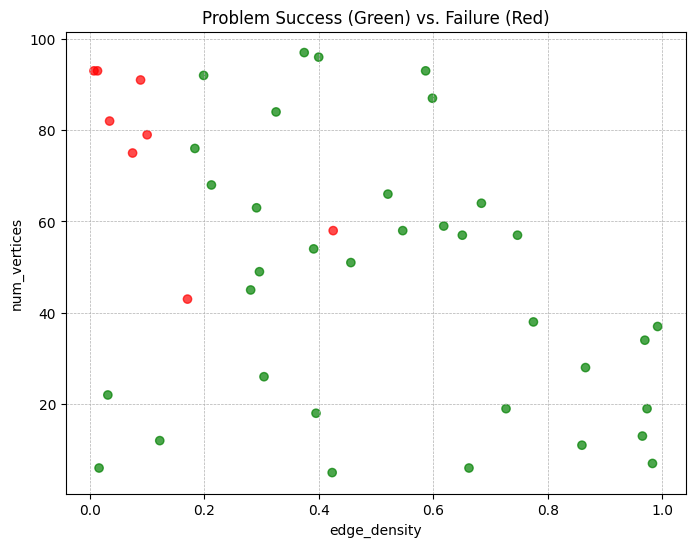

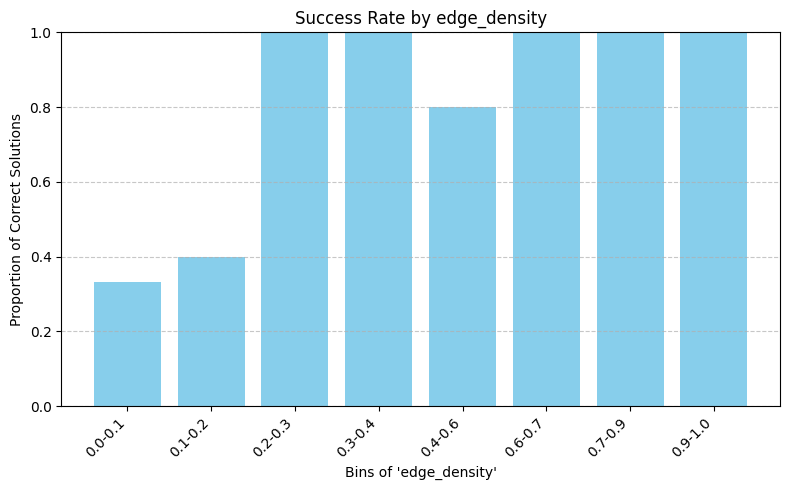

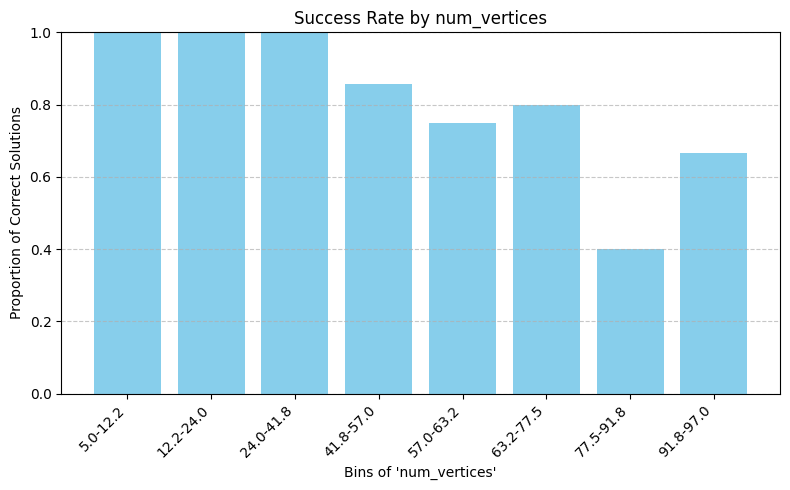

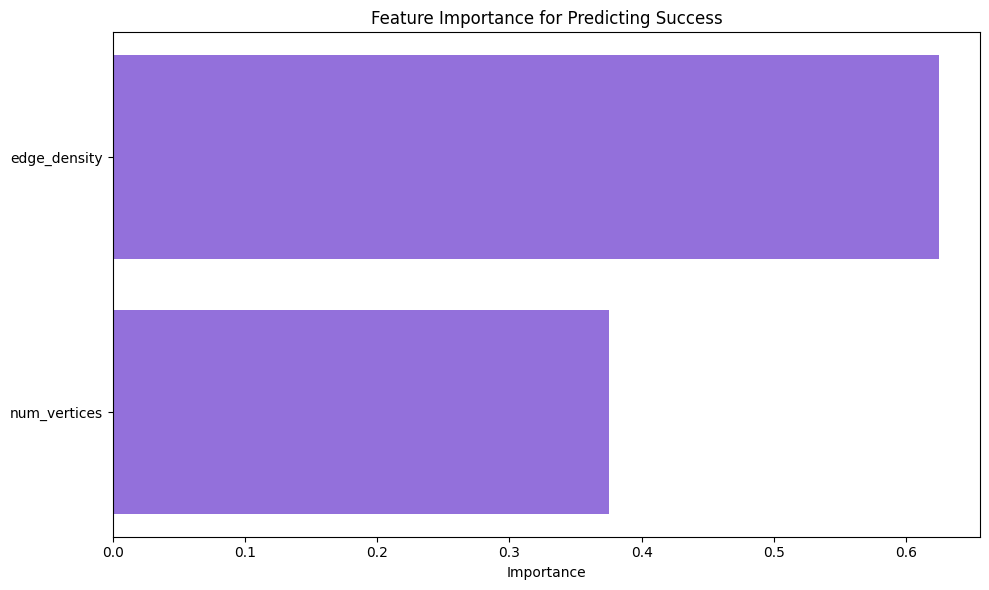

Classifier Accuracy (for feature importance): 1.00
Classifier F1 Score (for feature importance): 1.00

Average Solve Time: 68.76 seconds
Solve Time STD: 87.02 seconds
Overall Accuracy: 81.40%


In [37]:
report_results(experiment_results_3)